In [1]:
!python -c "import torch, transformers; print(torch.__version__, transformers.__version__)"

2.0.1+cu117 4.31.0


In [2]:
import transformers
import torch
from dataclasses import dataclass, field
from typing import Optional

In [3]:
@dataclass
class ModelArguments:
    model_name_or_path: Optional[str] = field(default="facebook/opt-125m")
    version: Optional[str] = field(default="v0")
    freeze_backbone: bool = field(default=False)
    tune_mm_mlp_adapter: bool = field(default=False)
    vision_tower: Optional[str] = field(default=None) # default to None
    mm_vision_select_layer: Optional[int] = field(default=-1)   # default to the last layer
    pretrain_mm_mlp_adapter: Optional[str] = field(default=None)
    mm_projector_type: Optional[str] = field(default='linear')
    mm_use_im_start_end: bool = field(default=False)
    mm_use_im_patch_token: bool = field(default=True)
    mm_patch_merge_type: Optional[str] = field(default='flat')
    mm_vision_select_feature: Optional[str] = field(default="patch")

@dataclass
class DataArguments:
    data_path: str = field(default=None,
                           metadata={"help": "Path to the training data."})
    lazy_preprocess: bool = False
    is_multimodal: bool = False
    image_folder: Optional[str] = field(default=None)
    image_aspect_ratio: str = 'square'

@dataclass
class TrainingArguments(transformers.TrainingArguments):
    cache_dir: Optional[str] = field(default=None)
    optim: str = field(default="adamw_torch")
    remove_unused_columns: bool = field(default=False)
    freeze_mm_mlp_adapter: bool = field(default=False)
    mpt_attn_impl: Optional[str] = field(default="triton")
    model_max_length: int = field(
        default=512,
        metadata={
            "help":
            "Maximum sequence length. Sequences will be right padded (and possibly truncated)."
        },
    )
    double_quant: bool = field(
        default=True,
        metadata={"help": "Compress the quantization statistics through double quantization."}
    )
    quant_type: str = field(
        default="nf4",
        metadata={"help": "Quantization data type to use. Should be one of `fp4` or `nf4`."}
    )
    bits: int = field(
        default=16,
        metadata={"help": "How many bits to use."}
    )
    lora_enable: bool = False
    lora_r: int = 64
    lora_alpha: int = 16
    lora_dropout: float = 0.05
    lora_weight_path: str = ""
    lora_bias: str = "none"
    mm_projector_lr: Optional[float] = None
    group_by_modality_length: bool = field(default=False)


/opt/venv/lib/python3.10/site-packages/bitsandbytes/cextension.py:34: UserWarning: The installed version of bitsandbytes was compiled without GPU support. 8-bit optimizers, 8-bit multiplication, and GPU quantization are unavailable.
  warn("The installed version of bitsandbytes was compiled without GPU support. "


/opt/venv/lib/python3.10/site-packages/bitsandbytes/libbitsandbytes_cpu.so: undefined symbol: cadam32bit_grad_fp32
[2025-10-06 00:51:44,882] [INFO] [real_accelerator.py:110:get_accelerator] Setting ds_accelerator to cuda (auto detect)


/opt/venv/lib/python3.10/site-packages/wandb/sdk/launch/builder/build.py:11: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [4]:
from transformers import HfArgumentParser

args_dict = {
    #"deepspeed": "./scripts/zero2.json",
    "model_name_or_path": "TinyLlama/TinyLlama-1.1B-Chat-v1.0",
    "version": "plain",
    "data_path": "/workspaces/LLaVA/CC3M_2.json",
    "image_folder": "/workspaces/LLaVA/images/",
    "vision_tower": "openai/clip-vit-large-patch14-336",
    "mm_projector_type": "mlp2x_gelu",
    "tune_mm_mlp_adapter": True,
    "mm_vision_select_layer": -2,
    "mm_use_im_start_end": False,
    "mm_use_im_patch_token": False,
    "bf16": True,
    "output_dir": "./checkpoints/llava-TinyLlama-1.1B-Chat-v1.0",

    # TrainingArguments 相当
    "num_train_epochs": 1,
    "per_device_train_batch_size": 1,
    "per_device_eval_batch_size": 1,
    "gradient_accumulation_steps": 1,
    "evaluation_strategy": "no",
    "save_strategy": "steps",
    "save_steps": 1,
    "save_total_limit": 1,
    "learning_rate": 1e-3,
    "weight_decay": 0.0, # I don't know why 0.0
    "warmup_ratio": 0.03,
    "lr_scheduler_type": "cosine",
    "logging_steps": 1,
    "tf32": False, # switched from True for TinyLlama
    "model_max_length": 2048,
    "gradient_checkpointing": True,
    "dataloader_num_workers": 2,
    "lazy_preprocess": True,
    "report_to": "none",
}

In [5]:
parser = HfArgumentParser((ModelArguments, DataArguments, TrainingArguments))
model_args, data_args, training_args = parser.parse_dict(args_dict)
print("model_args\n", model_args)
print("data_args\n", data_args)
print("training_args\n", training_args)

model_args
 ModelArguments(model_name_or_path='TinyLlama/TinyLlama-1.1B-Chat-v1.0', version='plain', freeze_backbone=False, tune_mm_mlp_adapter=True, vision_tower='openai/clip-vit-large-patch14-336', mm_vision_select_layer=-2, pretrain_mm_mlp_adapter=None, mm_projector_type='mlp2x_gelu', mm_use_im_start_end=False, mm_use_im_patch_token=False, mm_patch_merge_type='flat', mm_vision_select_feature='patch')
data_args
 DataArguments(data_path='/workspaces/LLaVA/CC3M_2.json', lazy_preprocess=True, is_multimodal=False, image_folder='/workspaces/LLaVA/images/', image_aspect_ratio='square')
training_args
 TrainingArguments(
_n_gpu=0,
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
bf16=True,
bf16_full_eval=False,
bits=16,
cache_dir=None,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=2,
dataloader_pin_memory=True,
ddp_backend=None,
ddp_broadcast_buffers=None,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeo

In [6]:
# Model Constants
IGNORE_INDEX = -100
IMAGE_TOKEN_INDEX = -200
DEFAULT_IMAGE_TOKEN = "<image>"
DEFAULT_IMAGE_PATCH_TOKEN = "<im_patch>"
DEFAULT_IM_START_TOKEN = "<im_start>"
DEFAULT_IM_END_TOKEN = "<im_end>"
IMAGE_PLACEHOLDER = "<image-placeholder>"

In [7]:
local_rank = training_args.local_rank
print("local_rank\n", local_rank)
compute_dtype = (torch.float16 if training_args.fp16 else (torch.bfloat16 if training_args.bf16 else torch.float32))
print("compute_dtype\n", compute_dtype)

local_rank
 0
compute_dtype
 torch.bfloat16


In [8]:
from transformers import CLIPVisionModel, CLIPImageProcessor, CLIPVisionConfig
import torch.nn as nn
# __init__
# load_model

# result = CLIPVisionTower(vision_tower, args=vision_tower_cfg, **kwargs)
class CLIPVisionTower(nn.Module):
    def __init__(self, vision_tower, args):
        # result = CLIPVisionTower(vision_tower, args=vision_tower_cfg, **kwargs)
        print("current file path", "llava/llava/model/multimodal_encoder/clip_encoder.py")
        print("def CLIPVisionTower.__init__(self, vision_tower, args")
        print("self\n", type(self))
        print("vision_tower\n", vision_tower) # openai/clip-vit-large-patch14-336
        print("args\n", args) # ModelArguments(model_name_or_path='lmsys/vicuna-7b-v1.5', version='plain', freeze_backbone=False, tune_mm_mlp_adapter=True, vision_tower='openai/clip-vit-large-patch14-336', mm_vision_select_layer=-2, pretrain_mm_mlp_adapter=None, mm_projector_type='mlp2x_gelu', mm_use_im_start_end=False, mm_use_im_patch_token=False, mm_patch_merge_type='flat', mm_vision_select_feature='patch')
        super().__init__()

        self.is_loaded = False

        print("self.is_loaded\n", self.is_loaded) # False

        self.vision_tower_name = vision_tower
        print("self.vision_tower_name\n", self.vision_tower_name) # openai/clip-vit-large-patch14-336
        self.select_layer = args.mm_vision_select_layer
        print("self.select_layer\n", self.select_layer) # -2
        self.select_feature = getattr(args, 'mm_vision_select_feature', 'patch')
        print("self.select_feature\n", self.select_feature) # patch

    def load_model(self):

        print("current file path", "llava/llava/model/multimodal_encoder/clip_encoder.py")
        print("def CLIPVisionTower.load_model(self)")
        print("self\n", type(self))
        print("self.vision_tower_name\n", self.vision_tower_name) # openai/clip-vit-large-patch14-336
        self.image_processor = CLIPImageProcessor.from_pretrained(self.vision_tower_name)
        print("self.image_processor\n", self.image_processor)
        """
        CLIPImageProcessor {
        "crop_size": {
            "height": 336,
            "width": 336
        },
        "do_center_crop": true,
        "do_convert_rgb": true,
        "do_normalize": true,
        "do_rescale": true,
        "do_resize": true,
        "feature_extractor_type": "CLIPFeatureExtractor",
        "image_mean": [
            0.48145466,
            0.4578275,
            0.40821073
        ],
        "image_processor_type": "CLIPImageProcessor",
        "image_std": [
            0.26862954,
            0.26130258,
            0.27577711
        ],
        "resample": 3,
        "rescale_factor": 0.00392156862745098,
        "size": {
            "shortest_edge": 336
        }
        }
        """
        self.vision_tower = CLIPVisionModel.from_pretrained(self.vision_tower_name)
        print("self.vision_tower\n", self.vision_tower)
        """
        CLIPVisionModel(
        (vision_model): CLIPVisionTransformer(
            (embeddings): CLIPVisionEmbeddings(
            (patch_embedding): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14), bias=False)
            (position_embedding): Embedding(577, 1024)
            )
            (pre_layrnorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
            (encoder): CLIPEncoder(
            (layers): ModuleList(
                (0-23): 24 x CLIPEncoderLayer(
                (self_attn): CLIPAttention(
                    (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
                    (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
                    (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
                    (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
                )
                (layer_norm1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
                (mlp): CLIPMLP(
                    (activation_fn): QuickGELUActivation()
                    (fc1): Linear(in_features=1024, out_features=4096, bias=True)
                    (fc2): Linear(in_features=4096, out_features=1024, bias=True)
                )
                (layer_norm2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
                )
            )
            )
            (post_layernorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        )
        )
        """
        self.vision_tower.requires_grad_(False)

        self.is_loaded = True
        print("self.is_loaded\n", self.is_loaded) # True

In [9]:
print(model_args)

ModelArguments(model_name_or_path='TinyLlama/TinyLlama-1.1B-Chat-v1.0', version='plain', freeze_backbone=False, tune_mm_mlp_adapter=True, vision_tower='openai/clip-vit-large-patch14-336', mm_vision_select_layer=-2, pretrain_mm_mlp_adapter=None, mm_projector_type='mlp2x_gelu', mm_use_im_start_end=False, mm_use_im_patch_token=False, mm_patch_merge_type='flat', mm_vision_select_feature='patch')


In [10]:
vision_tower_name = "openai/clip-vit-large-patch14-336"
CLIPVisionTower_model = CLIPVisionTower(vision_tower_name, args=model_args)

current file path llava/llava/model/multimodal_encoder/clip_encoder.py
def CLIPVisionTower.__init__(self, vision_tower, args
self
 <class '__main__.CLIPVisionTower'>
vision_tower
 openai/clip-vit-large-patch14-336
args
 ModelArguments(model_name_or_path='TinyLlama/TinyLlama-1.1B-Chat-v1.0', version='plain', freeze_backbone=False, tune_mm_mlp_adapter=True, vision_tower='openai/clip-vit-large-patch14-336', mm_vision_select_layer=-2, pretrain_mm_mlp_adapter=None, mm_projector_type='mlp2x_gelu', mm_use_im_start_end=False, mm_use_im_patch_token=False, mm_patch_merge_type='flat', mm_vision_select_feature='patch')
self.is_loaded
 False
self.vision_tower_name
 openai/clip-vit-large-patch14-336
self.select_layer
 -2
self.select_feature
 patch


In [11]:
CLIPVisionTower_model.load_model()

current file path llava/llava/model/multimodal_encoder/clip_encoder.py
def CLIPVisionTower.load_model(self)
self
 <class '__main__.CLIPVisionTower'>
self.vision_tower_name
 openai/clip-vit-large-patch14-336


/opt/venv/lib/python3.10/site-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


self.image_processor
 CLIPImageProcessor {
  "crop_size": {
    "height": 336,
    "width": 336
  },
  "do_center_crop": true,
  "do_convert_rgb": true,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "feature_extractor_type": "CLIPFeatureExtractor",
  "image_mean": [
    0.48145466,
    0.4578275,
    0.40821073
  ],
  "image_processor_type": "CLIPImageProcessor",
  "image_std": [
    0.26862954,
    0.26130258,
    0.27577711
  ],
  "resample": 3,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "shortest_edge": 336
  }
}

self.vision_tower
 CLIPVisionModel(
  (vision_model): CLIPVisionTransformer(
    (embeddings): CLIPVisionEmbeddings(
      (patch_embedding): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14), bias=False)
      (position_embedding): Embedding(577, 1024)
    )
    (pre_layrnorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-23): 24 x CLIPEncoderLayer(
      

In [12]:
print(CLIPVisionTower_model)

CLIPVisionTower(
  (vision_tower): CLIPVisionModel(
    (vision_model): CLIPVisionTransformer(
      (embeddings): CLIPVisionEmbeddings(
        (patch_embedding): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14), bias=False)
        (position_embedding): Embedding(577, 1024)
      )
      (pre_layrnorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (encoder): CLIPEncoder(
        (layers): ModuleList(
          (0-23): 24 x CLIPEncoderLayer(
            (self_attn): CLIPAttention(
              (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
            )
            (layer_norm1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
            (mlp): CLIPMLP(
              (activation_fn): QuickGELUActivation

In [13]:
print(CLIPVisionTower_model.vision_tower)

CLIPVisionModel(
  (vision_model): CLIPVisionTransformer(
    (embeddings): CLIPVisionEmbeddings(
      (patch_embedding): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14), bias=False)
      (position_embedding): Embedding(577, 1024)
    )
    (pre_layrnorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-23): 24 x CLIPEncoderLayer(
          (self_attn): CLIPAttention(
            (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
          )
          (layer_norm1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=1024, out_features=4096, bias=

In [14]:
print(CLIPVisionTower_model.vision_tower.config)

CLIPVisionConfig {
  "_name_or_path": "openai/clip-vit-large-patch14-336",
  "attention_dropout": 0.0,
  "dropout": 0.0,
  "hidden_act": "quick_gelu",
  "hidden_size": 1024,
  "image_size": 336,
  "initializer_factor": 1.0,
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "layer_norm_eps": 1e-05,
  "model_type": "clip_vision_model",
  "num_attention_heads": 16,
  "num_channels": 3,
  "num_hidden_layers": 24,
  "patch_size": 14,
  "projection_dim": 768,
  "transformers_version": "4.31.0"
}



In [15]:
import os

def build_vision_tower(model_args, **kwargs):
    # vision_tower = build_vision_tower(model_args)
    print("current file path", "llava/llava/model/multimodal_encoder/builder.py")
    print("def build_vision_tower(model_args, **kwargs)")
    print("model_args\n", model_args) # ModelArguments(model_name_or_path='lmsys/vicuna-7b-v1.5', version='plain', freeze_backbone=False, tune_mm_mlp_adapter=True, vision_tower='openai/clip-vit-large-patch14-336', mm_vision_select_layer=-2, pretrain_mm_mlp_adapter=None, mm_projector_type='mlp2x_gelu', mm_use_im_start_end=False, mm_use_im_patch_token=False, mm_patch_merge_type='flat', mm_vision_select_feature='patch')
    print("kwargs\n", kwargs) # {}
    vision_tower = model_args.vision_tower
    print("vision_tower from model_args\n", vision_tower) # openai/clip-vit-large-patch14-336
    CLIPVisionTower_model = CLIPVisionTower(vision_tower, args=model_args, **kwargs)
    CLIPVisionTower_model.load_model()
    print("CLIPVisionTower_model\n", CLIPVisionTower_model)
    print("【EXIT】if is_absolute_path_exists or vision_tower.startswith('openai') or vision_tower.startswith('laion') or 'ShareGPT4V' in vision_tower:")
    return CLIPVisionTower_model

In [16]:
build_vision_tower(model_args)

current file path llava/llava/model/multimodal_encoder/builder.py
def build_vision_tower(model_args, **kwargs)
model_args
 ModelArguments(model_name_or_path='TinyLlama/TinyLlama-1.1B-Chat-v1.0', version='plain', freeze_backbone=False, tune_mm_mlp_adapter=True, vision_tower='openai/clip-vit-large-patch14-336', mm_vision_select_layer=-2, pretrain_mm_mlp_adapter=None, mm_projector_type='mlp2x_gelu', mm_use_im_start_end=False, mm_use_im_patch_token=False, mm_patch_merge_type='flat', mm_vision_select_feature='patch')
kwargs
 {}
vision_tower from model_args
 openai/clip-vit-large-patch14-336
current file path llava/llava/model/multimodal_encoder/clip_encoder.py
def CLIPVisionTower.__init__(self, vision_tower, args
self
 <class '__main__.CLIPVisionTower'>
vision_tower
 openai/clip-vit-large-patch14-336
args
 ModelArguments(model_name_or_path='TinyLlama/TinyLlama-1.1B-Chat-v1.0', version='plain', freeze_backbone=False, tune_mm_mlp_adapter=True, vision_tower='openai/clip-vit-large-patch14-336',

self.vision_tower
 CLIPVisionModel(
  (vision_model): CLIPVisionTransformer(
    (embeddings): CLIPVisionEmbeddings(
      (patch_embedding): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14), bias=False)
      (position_embedding): Embedding(577, 1024)
    )
    (pre_layrnorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-23): 24 x CLIPEncoderLayer(
          (self_attn): CLIPAttention(
            (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
          )
          (layer_norm1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=1024, out_f

CLIPVisionTower(
  (vision_tower): CLIPVisionModel(
    (vision_model): CLIPVisionTransformer(
      (embeddings): CLIPVisionEmbeddings(
        (patch_embedding): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14), bias=False)
        (position_embedding): Embedding(577, 1024)
      )
      (pre_layrnorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (encoder): CLIPEncoder(
        (layers): ModuleList(
          (0-23): 24 x CLIPEncoderLayer(
            (self_attn): CLIPAttention(
              (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
            )
            (layer_norm1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
            (mlp): CLIPMLP(
              (activation_fn): QuickGELUActivation

In [17]:
import torch.nn as nn

def build_vision_projector(config, delay_load=False, **kwargs):
    # 2層MLPをハードコーディング（configからサイズのみ取得）
    return nn.Sequential(
        nn.Linear(config.mm_hidden_size, config.hidden_size),
        nn.GELU(),
        nn.Linear(config.hidden_size, config.hidden_size),
    )

In [18]:
from transformers import AutoConfig

# 公式 LLaMA-2-7B の config をロード
TinyLlama_config = AutoConfig.from_pretrained("TinyLlama/TinyLlama-1.1B-Chat-v1.0")
TinyLlama_config.mm_hidden_size = CLIPVisionTower_model.vision_tower.config.hidden_size
print(TinyLlama_config)

LlamaConfig {
  "_name_or_path": "TinyLlama/TinyLlama-1.1B-Chat-v1.0",
  "architectures": [
    "LlamaForCausalLM"
  ],
  "attention_bias": false,
  "bos_token_id": 1,
  "eos_token_id": 2,
  "hidden_act": "silu",
  "hidden_size": 2048,
  "initializer_range": 0.02,
  "intermediate_size": 5632,
  "max_position_embeddings": 2048,
  "mm_hidden_size": 1024,
  "model_type": "llama",
  "num_attention_heads": 32,
  "num_hidden_layers": 22,
  "num_key_value_heads": 4,
  "pad_token_id": 0,
  "pretraining_tp": 1,
  "rms_norm_eps": 1e-05,
  "rope_scaling": null,
  "rope_theta": 10000.0,
  "tie_word_embeddings": false,
  "torch_dtype": "bfloat16",
  "transformers_version": "4.31.0",
  "use_cache": true,
  "vocab_size": 32000
}



In [19]:
projector = build_vision_projector(TinyLlama_config)
print(projector)

Sequential(
  (0): Linear(in_features=1024, out_features=2048, bias=True)
  (1): GELU(approximate='none')
  (2): Linear(in_features=2048, out_features=2048, bias=True)
)


In [20]:
del(CLIPVisionTower_model)

In [21]:
def print_mro(cls):
    print(f"MRO for {cls.__name__}:\n")
    for i, c in enumerate(cls.mro()):
        print(f"{i:2d}: {c.__module__}.{c.__name__}")
    print("\n\n")

In [22]:
# LlavaBaseModel
# __init__
# get_vision_tower
# initialize_vision_modules
# unpad_image

class LlavaBaseModel:  # LLaMA, MPT などの全てのLLM用の共通機能をまとめたクラス

    # LlavaLlamaModelの__init__によって呼び出される
    def __init__(self):

        print("current file path", "llava/model/llava_arch.py")
        print("LlavaBaseModel.__init__(self, config)")
        # 「LlavaLlamaModelの__init__によって呼び出された時は」LlamaModelの__init_を呼び出す
        super(LlavaBaseModel, self).__init__()

In [23]:
# transformers.models.llama.modeling_llama.LlamaModel
# URL: https://github.com/huggingface/transformers/blob/main/src/transformers/models/llama/modeling_llama.py
from transformers import LlamaModel

# LlavaBaseModelにLlamaの初期化クラスをくっつけたいので、LLamaModelをMROに追加。
# MROだと、LlavaLlamaModel > LlavaBaseModel > LlamaModel の順に解決される。
class LlavaLlamaModel(LlavaBaseModel, LlamaModel): 
    def __init__(self):

        print("current file path", "llava/llava/model/language_model/llava_llama.py")
        print("def LlavaLlamaModel.__init__(self, config: LlamaConfig)")
        print("self\n", type(self))
        # LlavaBaseModelの__init__を呼ぶ
        super(LlavaLlamaModel, self).__init__() 

In [24]:
print_mro(LlavaBaseModel)
print_mro(LlavaLlamaModel)

MRO for LlavaBaseModel:

 0: __main__.LlavaBaseModel
 1: builtins.object



MRO for LlavaLlamaModel:

 0: __main__.LlavaLlamaModel
 1: __main__.LlavaBaseModel
 2: transformers.models.llama.modeling_llama.LlamaModel
 3: transformers.models.llama.modeling_llama.LlamaPreTrainedModel
 4: transformers.modeling_utils.PreTrainedModel
 5: torch.nn.modules.module.Module
 6: transformers.modeling_utils.ModuleUtilsMixin
 7: transformers.generation.utils.GenerationMixin
 8: transformers.utils.hub.PushToHubMixin
 9: builtins.object





In [25]:
# LlavaBaseModel
# __init__
# get_vision_tower
# initialize_vision_modules
# unpad_image

class LlavaBaseModel:  # LLaMA, MPT などの全てのLLM用の共通機能をまとめたクラス

    # LlavaLlamaModelの__init__によって呼び出される
    def __init__(self, config):

        print("current file path", "llava/model/llava_arch.py")
        print("LlavaBaseModel.__init__(self, config)")
        print("config\n", config)
        # 「LlavaLlamaModelの__init__によって呼び出された時は」LlamaModelの__init_を呼び出す
        super(LlavaBaseModel, self).__init__(config)

In [26]:
# transformers.models.llama.modeling_llama.LlamaModel
# URL: https://github.com/huggingface/transformers/blob/main/src/transformers/models/llama/modeling_llama.py
from transformers import LlamaConfig, LlamaModel

class LlavaLlamaConfig(LlamaConfig):
    model_type = "llava_llama"

# LlavaBaseModelにLlamaの初期化クラスをくっつけたいので、LLamaModelをMROに追加。
# MROだと、LlavaLlamaModel > LlavaBaseModel > LlamaModel の順に解決される。
class LlavaLlamaModel(LlavaBaseModel, LlamaModel): 
    config_class = LlavaLlamaConfig # from_pretrained の時にここが読みこまれる

    def __init__(self, config: LlamaConfig):

        print("current file path", "llava/llava/model/language_model/llava_llama.py")
        print("def LlavaLlamaModel.__init__(self, config: LlamaConfig)")
        print("self\n", type(self))
        print("config\n", config)
        # LlavaBaseModelの__init__を呼ぶ
        super(LlavaLlamaModel, self).__init__(config) 

In [27]:
# LlavaBaseForCausalLM
# get_vision_tower
# encode_images
# prepare_inputs_labels_for_multimodal
# initialize_vision_tokenizer

# 以下のLlavaBaseForCausalLMのselfは、継承先のLlavaLlamaForCausalLMのselfが使用される

class LlavaBaseForCausalLM:

    def get_vision_tower(self):
        print("current file path", "llava/model/llava_arch.py")
        print("class LlavaBaseForCausalLM(ABC).get_vision_tower(self)")
        result = self.get_model().get_vision_tower()
        print("LlavaBaseForCausalLM(ABC).get_vision_tower(self) result (return)\n", result)
        """
        CLIPVisionTower(
        (vision_tower): CLIPVisionModel(
            (vision_model): CLIPVisionTransformer(
            (embeddings): CLIPVisionEmbeddings(
                (patch_embedding): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14), bias=False)
                (position_embedding): Embedding(577, 1024)
            )
            (pre_layrnorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
            (encoder): CLIPEncoder(
                (layers): ModuleList(
                (0-23): 24 x CLIPEncoderLayer(
                    (self_attn): CLIPAttention(
                    (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
                    (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
                    (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
                    (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
                    )
                    (layer_norm1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
                    (mlp): CLIPMLP(
                    (activation_fn): QuickGELUActivation()
                    (fc1): Linear(in_features=1024, out_features=4096, bias=True)
                    (fc2): Linear(in_features=4096, out_features=1024, bias=True)
                    )
                    (layer_norm2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
                )
                )
            )
            (post_layernorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
            )
        )
        )
        """
        return result

In [28]:
from typing import List, Optional, Tuple, Union
from transformers.modeling_outputs import CausalLMOutputWithPast
from transformers import LlamaForCausalLM

class LlavaLlamaForCausalLM(LlamaForCausalLM, LlavaBaseForCausalLM):
    config_class = LlavaLlamaConfig # from_pretrainedの際にここが読み込まれる

    def __init__(self, config):

        print("current file path", "llava/llava/model/language_model/llava_llama.py")
        print("def LlavaLlamaForCausalLM.__init__(self, config)")
        print("self\n", type(self))
        print("config\n", config)
        super(LlamaForCausalLM, self).__init__(config)
        # LlamaForCausalLMのself.modelをLlavaLlamaModelに置き換える
        self.model = LlavaLlamaModel(config)
        print("self.model\n", self.model)
        """
        self.model
        LlavaLlamaModel(
        (embed_tokens): Embedding(32000, 4096, padding_idx=0)
        (layers): ModuleList(
            (0-31): 32 x LlamaDecoderLayer(
            (self_attn): LlamaAttention(
                (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
                (k_proj): Linear(in_features=4096, out_features=4096, bias=False)
                (v_proj): Linear(in_features=4096, out_features=4096, bias=False)
                (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
                (rotary_emb): LlamaRotaryEmbedding()
            )
            (mlp): LlamaMLP(
                (gate_proj): Linear(in_features=4096, out_features=11008, bias=False)
                (up_proj): Linear(in_features=4096, out_features=11008, bias=False)
                (down_proj): Linear(in_features=11008, out_features=4096, bias=False)
                (act_fn): SiLUActivation()
            )
            (input_layernorm): LlamaRMSNorm()
            (post_attention_layernorm): LlamaRMSNorm()
            )
        )
        (norm): LlamaRMSNorm()
        )
        """
        #print("self.pretraining_tp\n", self.pretraining_tp) # 1
        #print("self.vocab_size\n", self.vocab_size) # 32_000
        #print("self.lm_head\n", self.lm_head) # Linear(in_features=4096, out_features=32000, bias=False)

        # Initialize weights and apply final processing
        #self.post_init()

In [29]:
"""
from transformers import AutoConfig

# まず config.json をロードして Config クラスを自動判別
config = AutoConfig.from_pretrained(
    model_args.model_name_or_path,
    cache_dir=training_args.cache_dir
)

print("model_args.model_name_or_path\n", model_args.model_name_or_path)
print("training_args.cache_dir\n", training_args.cache_dir)
print("")
print("Loaded config:\n", config)
"""

'\nfrom transformers import AutoConfig\n\n# まず config.json をロードして Config クラスを自動判別\nconfig = AutoConfig.from_pretrained(\n    model_args.model_name_or_path,\n    cache_dir=training_args.cache_dir\n)\n\nprint("model_args.model_name_or_path\n", model_args.model_name_or_path)\nprint("training_args.cache_dir\n", training_args.cache_dir)\nprint("")\nprint("Loaded config:\n", config)\n'

In [30]:
print_mro(LlavaBaseForCausalLM)
print_mro(LlavaLlamaForCausalLM)

MRO for LlavaBaseForCausalLM:

 0: __main__.LlavaBaseForCausalLM
 1: builtins.object



MRO for LlavaLlamaForCausalLM:

 0: __main__.LlavaLlamaForCausalLM
 1: transformers.models.llama.modeling_llama.LlamaForCausalLM
 2: transformers.models.llama.modeling_llama.LlamaPreTrainedModel
 3: transformers.modeling_utils.PreTrainedModel
 4: torch.nn.modules.module.Module
 5: transformers.modeling_utils.ModuleUtilsMixin
 6: transformers.generation.utils.GenerationMixin
 7: transformers.utils.hub.PushToHubMixin
 8: __main__.LlavaBaseForCausalLM
 9: builtins.object





In [31]:
LlavaLlamaForCausalLM_model = LlavaLlamaForCausalLM.from_pretrained(model_args.model_name_or_path)

You are using a model of type llama to instantiate a model of type llava_llama. This is not supported for all configurations of models and can yield errors.


current file path llava/llava/model/language_model/llava_llama.py
def LlavaLlamaForCausalLM.__init__(self, config)
self
 <class '__main__.LlavaLlamaForCausalLM'>
config
 LlavaLlamaConfig {
  "_name_or_path": "TinyLlama/TinyLlama-1.1B-Chat-v1.0",
  "architectures": [
    "LlamaForCausalLM"
  ],
  "attention_bias": false,
  "bos_token_id": 1,
  "eos_token_id": 2,
  "hidden_act": "silu",
  "hidden_size": 2048,
  "initializer_range": 0.02,
  "intermediate_size": 5632,
  "max_position_embeddings": 2048,
  "model_type": "llava_llama",
  "num_attention_heads": 32,
  "num_hidden_layers": 22,
  "num_key_value_heads": 4,
  "pad_token_id": 0,
  "pretraining_tp": 1,
  "rms_norm_eps": 1e-05,
  "rope_scaling": null,
  "rope_theta": 10000.0,
  "tie_word_embeddings": false,
  "torch_dtype": "bfloat16",
  "transformers_version": "4.31.0",
  "use_cache": true,
  "vocab_size": 32000
}

current file path llava/llava/model/language_model/llava_llama.py
def LlavaLlamaModel.__init__(self, config: LlamaConfig

Some weights of LlavaLlamaForCausalLM were not initialized from the model checkpoint at TinyLlama/TinyLlama-1.1B-Chat-v1.0 and are newly initialized: ['model.layers.3.self_attn.rotary_emb.inv_freq', 'model.layers.11.self_attn.rotary_emb.inv_freq', 'model.layers.19.self_attn.rotary_emb.inv_freq', 'model.layers.10.self_attn.rotary_emb.inv_freq', 'model.layers.8.self_attn.rotary_emb.inv_freq', 'model.layers.18.self_attn.rotary_emb.inv_freq', 'model.layers.14.self_attn.rotary_emb.inv_freq', 'model.layers.12.self_attn.rotary_emb.inv_freq', 'model.layers.7.self_attn.rotary_emb.inv_freq', 'model.layers.0.self_attn.rotary_emb.inv_freq', 'model.layers.20.self_attn.rotary_emb.inv_freq', 'model.layers.1.self_attn.rotary_emb.inv_freq', 'model.layers.5.self_attn.rotary_emb.inv_freq', 'model.layers.15.self_attn.rotary_emb.inv_freq', 'model.layers.21.self_attn.rotary_emb.inv_freq', 'model.layers.13.self_attn.rotary_emb.inv_freq', 'model.layers.17.self_attn.rotary_emb.inv_freq', 'model.layers.16.self_

In [32]:
print("LlavaLlamaForCausalLM_model\n", LlavaLlamaForCausalLM_model)

LlavaLlamaForCausalLM_model
 LlavaLlamaForCausalLM(
  (model): LlavaLlamaModel(
    (embed_tokens): Embedding(32000, 2048, padding_idx=0)
    (layers): ModuleList(
      (0-21): 22 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2048, out_features=256, bias=False)
          (v_proj): Linear(in_features=2048, out_features=256, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=2048, out_features=5632, bias=False)
          (up_proj): Linear(in_features=2048, out_features=5632, bias=False)
          (down_proj): Linear(in_features=5632, out_features=2048, bias=False)
          (act_fn): SiLUActivation()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
  

In [33]:
LlavaLlamaForCausalLM_model.enable_input_require_grads()

In [34]:
import dataclasses
from typing import List
from enum import auto, Enum

class SeparatorStyle(Enum):
    """Different separator style."""
    SINGLE = auto()
    TWO = auto()
    MPT = auto()
    PLAIN = auto()
    LLAMA_2 = auto()


@dataclasses.dataclass
class Conversation:
    """A class that keeps all conversation history."""
    system: str
    roles: List[str]
    messages: List[List[str]]
    offset: int
    sep_style: SeparatorStyle = SeparatorStyle.SINGLE
    sep: str = "###"
    sep2: str = None
    version: str = "Unknown"
    skip_next: bool = False


conv_llava_plain = Conversation(
    system="",
    roles=("", ""),
    messages=(
    ),
    offset=0,
    sep_style=SeparatorStyle.PLAIN,
    sep="\n",
)


conv_templates = {
    "plain": conv_llava_plain,
}

In [35]:
"""
import inspect
print(inspect.getattr_static(LlamaForCausalLM, "from_pretrained"))
print(inspect.getattr_static(LlamaForCausalLM, "enable_input_require_grads"))
"""

'\nimport inspect\nprint(inspect.getattr_static(LlamaForCausalLM, "from_pretrained"))\nprint(inspect.getattr_static(LlamaForCausalLM, "enable_input_require_grads"))\n'

In [36]:
print(model_args.model_name_or_path)
print(training_args.cache_dir)
print(training_args.model_max_length)

TinyLlama/TinyLlama-1.1B-Chat-v1.0
None
2048


In [37]:
tokenizer = transformers.AutoTokenizer.from_pretrained(
    model_args.model_name_or_path,
    cache_dir=training_args.cache_dir,
    model_max_length=training_args.model_max_length, 
    padding_side="right", # 実際にパディングを行うのは tokenizer か DataCollator のどちらかだが、padding_side 自体はtokenizer側で行う
    use_fast=False,
)

In [38]:
tokenizer

LlamaTokenizer(name_or_path='TinyLlama/TinyLlama-1.1B-Chat-v1.0', vocab_size=32000, model_max_length=2048, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=False), 'eos_token': AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=False), 'unk_token': AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=False), 'pad_token': AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=False)}, clean_up_tokenization_spaces=False)

In [39]:
print("pad_token:", tokenizer.pad_token)
print("pad_token_id:", tokenizer.pad_token_id)
print("unk_token:", tokenizer.unk_token) # unkownの略です。類似の単語と間違えないでください。
print("unk_token_id:", tokenizer.unk_token_id)
print("tokenizer\n", tokenizer)

pad_token: </s>
pad_token_id: 2
unk_token: <unk>
unk_token_id: 0
tokenizer
 LlamaTokenizer(name_or_path='TinyLlama/TinyLlama-1.1B-Chat-v1.0', vocab_size=32000, model_max_length=2048, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=False), 'eos_token': AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=False), 'unk_token': AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=False), 'pad_token': AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=False)}, clean_up_tokenization_spaces=False)


In [40]:
tokenizer.pad_token = tokenizer.unk_token

In [41]:
print("pad_token:", tokenizer.pad_token)
print("pad_token_id:", tokenizer.pad_token_id)
print("unk_token:", tokenizer.unk_token)
print("unk_token_id:", tokenizer.unk_token_id)
print("tokenizer\n", tokenizer)

pad_token: <unk>
pad_token_id: 0
unk_token: <unk>
unk_token_id: 0
tokenizer
 LlamaTokenizer(name_or_path='TinyLlama/TinyLlama-1.1B-Chat-v1.0', vocab_size=32000, model_max_length=2048, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=False), 'eos_token': AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=False), 'unk_token': AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=False), 'pad_token': '<unk>'}, clean_up_tokenization_spaces=False)


In [42]:
print("model_args.version\n", model_args.version)
default_conversation = conv_templates[model_args.version]
print("default_conversation\n", default_conversation)

model_args.version
 plain
default_conversation
 Conversation(system='', roles=('', ''), messages=(), offset=0, sep_style=<SeparatorStyle.PLAIN: 4>, sep='\n', sep2=None, version='Unknown', skip_next=False)


In [43]:
print("model_args.vision_tower\n", model_args.vision_tower)

model_args.vision_tower
 openai/clip-vit-large-patch14-336


In [44]:
# LlavaLlamaForCausalLMの関数。LlavaLlamaModelをgetする
def get_model(self):

    print("current file path", "llava/llava/model/language_model/llava_llama.py")
    print("def LlavaLlamaForCausalLM.get_model(self)")
    print("self\n", type(self))
    print("self.model (return)\n", self.model)
    return self.model

In [45]:
LlavaLlamaForCausalLM.get_model = get_model

In [46]:
LlavaLlamaModel_model = LlavaLlamaForCausalLM_model.get_model()

current file path llava/llava/model/language_model/llava_llama.py
def LlavaLlamaForCausalLM.get_model(self)
self
 <class '__main__.LlavaLlamaForCausalLM'>
self.model (return)
 LlavaLlamaModel(
  (embed_tokens): Embedding(32000, 2048, padding_idx=0)
  (layers): ModuleList(
    (0-21): 22 x LlamaDecoderLayer(
      (self_attn): LlamaAttention(
        (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
        (k_proj): Linear(in_features=2048, out_features=256, bias=False)
        (v_proj): Linear(in_features=2048, out_features=256, bias=False)
        (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
        (rotary_emb): LlamaRotaryEmbedding()
      )
      (mlp): LlamaMLP(
        (gate_proj): Linear(in_features=2048, out_features=5632, bias=False)
        (up_proj): Linear(in_features=2048, out_features=5632, bias=False)
        (down_proj): Linear(in_features=5632, out_features=2048, bias=False)
        (act_fn): SiLUActivation()
      )
      (input_l

In [47]:
def config(self):

    print("current file path", "llava/llava/model/multimodal_encoder/clip_encoder.py")
    print("def CLIPVisionTower.config(self)")
    print("self\n", type(self))
    print("self.is_loaded\n", self.is_loaded) # True
    print(f"【COND】 is_loaded={self.is_loaded}")
    if self.is_loaded:
        # 【ENTER】
        print("【ENTER】if self.is_loaded:")
        result = self.vision_tower.config
        print("result (return)\n", type(result))
        print("【EXIT】if self.is_loaded:")
    else:
      pass
    print("result (return)\n", result)
    """
    CLIPVisionConfig {
    "_name_or_path": "openai/clip-vit-large-patch14-336",
    "attention_dropout": 0.0,
    "dropout": 0.0,
    "hidden_act": "quick_gelu",
    "hidden_size": 1024,
    "image_size": 336,
    "initializer_factor": 1.0,
    "initializer_range": 0.02,
    "intermediate_size": 4096,
    "layer_norm_eps": 1e-05,
    "model_type": "clip_vision_model",
    "num_attention_heads": 16,
    "num_channels": 3,
    "num_hidden_layers": 24,
    "patch_size": 14,
    "projection_dim": 768,
    "transformers_version": "4.31.0"
    }
    """
    return result

In [48]:
CLIPVisionTower.config = property(config)

In [49]:
def initialize_vision_modules(self, model_args, fsdp=None):

  print("current file path", "llava/model/llava_arch.py")
  print("def initialize_vision_modules(self, model_args, fsdp=None)")
  print("model_args\n", model_args) #  ModelArguments(model_name_or_path='lmsys/vicuna-7b-v1.5', version='plain', freeze_backbone=False, tune_mm_mlp_adapter=True, vision_tower='openai/clip-vit-large-patch14-336', mm_vision_select_layer=-2, pretrain_mm_mlp_adapter=None, mm_projector_type='mlp2x_gelu', mm_use_im_start_end=False, mm_use_im_patch_token=False, mm_patch_merge_type='flat', mm_vision_select_feature='patch')
  print("fsdp\n", fsdp) # []
  vision_tower = model_args.vision_tower
  print("vision_tower from model_args\n", vision_tower) # openai/clip-vit-large-patch14-336
  mm_vision_select_layer = model_args.mm_vision_select_layer
  print("mm_vision_select_layer from model_args\n", mm_vision_select_layer) # -2
  mm_vision_select_feature = model_args.mm_vision_select_feature
  print("mm_vision_select_feature from model_args\n", mm_vision_select_feature) # patch
  pretrain_mm_mlp_adapter = model_args.pretrain_mm_mlp_adapter
  print("pretrain_mm_mlp_adapter from model_args\n", pretrain_mm_mlp_adapter) # None
  mm_patch_merge_type = model_args.mm_patch_merge_type
  # 下記はself.config.mm_vision_towerに関するもの。self.vision_towerは依然としてNone
  self.config.mm_vision_tower = vision_tower
  print("self.config.mm_vision_tower\n", self.config.mm_vision_tower) # None

  print("【COND】 self.get_vision_tower()\n", self.get_vision_tower()) # None
  print(f"【COND】 get_vision_tower_is_None={self.get_vision_tower() is None}")
  if self.get_vision_tower() is None:
      #【ENTER】self.vision_tower, self.get_vision_towerはNoneなのでこの分岐に入る。
      print("【ENTER】if self.get_vision_tower() is None:")
      print("[ENTER] self.get_vision_tower() is None")
      # build_vision_tower(model_args) はちょっと奥の依存関係が深い
      vision_tower = build_vision_tower(model_args)
      print("vision_tower after build_vision_tower\n", vision_tower)
      """
      CLIPVisionTower(
      (vision_tower): CLIPVisionModel(
      (vision_model): CLIPVisionTransformer(
          (embeddings): CLIPVisionEmbeddings(
          (patch_embedding): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14), bias=False)
          (position_embedding): Embedding(577, 1024)
          )
          (pre_layrnorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (encoder): CLIPEncoder(
          (layers): ModuleList(
              (0-23): 24 x CLIPEncoderLayer(
              (self_attn): CLIPAttention(
                  (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
                  (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
                  (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
                  (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
              )
              (layer_norm1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
              (mlp): CLIPMLP(
                  (activation_fn): QuickGELUActivation()
                  (fc1): Linear(in_features=1024, out_features=4096, bias=True)
                  (fc2): Linear(in_features=4096, out_features=1024, bias=True)
              )
              (layer_norm2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
              )
          )
          )
          (post_layernorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      )
      )
      )
      """
      # 分散学習(FSDP)を使うかどうか. 今回は [] 空のリストとなるので、Noneではないが、len(fsdp) == 0
      print("【COND】 fsdp\n", fsdp) # []
      print(f"【COND】 fsdp_is_not_None={fsdp is not None} len_fsdp={len(fsdp) if fsdp is not None else 'N/A'}") # fsdp_is_not_None=True len_fsdp=0
      if fsdp is not None and len(fsdp) > 0:
        pass
      else:
          # 【ENTER】else of if fsdp is not None and len(fsdp) > 0:
          print("【COND】 else_fsdp_is_not_None_and_len_fsdp_gt_0=True")
          print("【ENTER】else of if fsdp is not None and len(fsdp) > 0:")
          self.vision_tower = vision_tower
          print("self.vision_tower\n", self.vision_tower)
          """
          CLIPVisionTower(
          (vision_tower): CLIPVisionModel(
              (vision_model): CLIPVisionTransformer(
              (embeddings): CLIPVisionEmbeddings(
                  (patch_embedding): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14), bias=False)
                  (position_embedding): Embedding(577, 1024)
              )
              (pre_layrnorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
              (encoder): CLIPEncoder(
                  (layers): ModuleList(
                  (0-23): 24 x CLIPEncoderLayer(
                      (self_attn): CLIPAttention(
                      (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
                      (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
                      (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
                      (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
                      )
                      (layer_norm1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
                      (mlp): CLIPMLP(
                      (activation_fn): QuickGELUActivation()
                      (fc1): Linear(in_features=1024, out_features=4096, bias=True)
                      (fc2): Linear(in_features=4096, out_features=1024, bias=True)
                      )
                      (layer_norm2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
                  )
                  )
              )
              (post_layernorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
              )
          )
          )
          """
          print("【EXIT】else of if fsdp is not None and len(fsdp) > 0:")

      print("【EXIT】if self.get_vision_tower() is None:")
  else:
    pass

  self.config.use_mm_proj = True
  print("self.config.use_mm_proj set to True") # True
  self.config.mm_projector_type = getattr(model_args, 'mm_projector_type', 'linear')
  print("self.config.mm_projector_type\n", self.config.mm_projector_type) # mlp2x_gelu
  self.config.mm_hidden_size = vision_tower.config.hidden_size
  print("self.config.mm_hidden_size\n", self.config.mm_hidden_size) # 1024
  self.config.mm_vision_select_layer = mm_vision_select_layer
  print("self.config.mm_vision_select_layer\n", self.config.mm_vision_select_layer) # -2
  self.config.mm_vision_select_feature = mm_vision_select_feature
  print("self.config.mm_vision_select_feature\n", self.config.mm_vision_select_feature) # patch
  self.config.mm_patch_merge_type = mm_patch_merge_type
  print("self.config.mm_patch_merge_type\n", self.config.mm_patch_merge_type) # flat

  # mm_projector_is_None=True
  print(f"【COND】 mm_projector_is_None={getattr(self, 'mm_projector', None) is None}")
  if getattr(self, 'mm_projector', None) is None:
      # 【ENTER】
      print("【ENTER】if getattr(self, 'mm_projector', None) is None:")
      self.mm_projector = build_vision_projector(self.config)
      """
      Sequential(
        (0): Linear(in_features=1024, out_features=2048, bias=True)
        (1): GELU(approximate='none')
        (2): Linear(in_features=2048, out_features=2048, bias=True)
      )
      """
      print("self.mm_projector after build_vision_projector\n", self.mm_projector)
      print("mm_patch_merge_type\n", mm_patch_merge_type) # flat
      print(f"【COND】 unpad_in_mm_patch_merge_type={'unpad' in mm_patch_merge_type}")
      if 'unpad' in mm_patch_merge_type:
        pass
      print("【EXIT】if getattr(self, 'mm_projector', None) is None:")
  else:
    pass

  print(f"【COND】 pretrain_mm_mlp_adapter_is_not_None={pretrain_mm_mlp_adapter is not None}")
  if pretrain_mm_mlp_adapter is not None:
    pass

In [50]:
LlavaBaseModel.initialize_vision_modules = initialize_vision_modules

In [51]:
def get_vision_tower(self):

    print("current file path", "llava/model/llava_arch.py")
    print("def get_vision_tower(self)")
    vision_tower = getattr(self, 'vision_tower', None)
    print("vision_tower (raw)\n", vision_tower)
    """
    CLIPVisionTower(
    (vision_tower): CLIPVisionModel(
        (vision_model): CLIPVisionTransformer(
        (embeddings): CLIPVisionEmbeddings(
            (patch_embedding): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14), bias=False)
            (position_embedding): Embedding(577, 1024)
        )
        (pre_layrnorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (encoder): CLIPEncoder(
            (layers): ModuleList(
            (0-23): 24 x CLIPEncoderLayer(
                (self_attn): CLIPAttention(
                (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
                (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
                (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
                (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
                )
                (layer_norm1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
                (mlp): CLIPMLP(
                (activation_fn): QuickGELUActivation()
                (fc1): Linear(in_features=1024, out_features=4096, bias=True)
                (fc2): Linear(in_features=4096, out_features=1024, bias=True)
                )
                (layer_norm2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
            )
            )
        )
        (post_layernorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        )
    )
    )
    """
    print("type(vision_tower)\n", type(vision_tower))
    print(f"【COND】 type_vision_tower_is_list={type(vision_tower) is list}")  # False
    if type(vision_tower) is list:
        # 【SKIP】
        print("【ENTER】if type(vision_tower) is list:")
        vision_tower = vision_tower[0]
        print("【EXIT】if type(vision_tower) is list:")
    print("vision_tower (return)\n", vision_tower)
    """
    vision_tower (return)
    CLIPVisionTower(
    (vision_tower): CLIPVisionModel(
        (vision_model): CLIPVisionTransformer(
        (embeddings): CLIPVisionEmbeddings(
            (patch_embedding): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14), bias=False)
            (position_embedding): Embedding(577, 1024)
        )
        (pre_layrnorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (encoder): CLIPEncoder(
            (layers): ModuleList(
            (0-23): 24 x CLIPEncoderLayer(
                (self_attn): CLIPAttention(
                (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
                (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
                (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
                (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
                )
                (layer_norm1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
                (mlp): CLIPMLP(
                (activation_fn): QuickGELUActivation()
                (fc1): Linear(in_features=1024, out_features=4096, bias=True)
                (fc2): Linear(in_features=4096, out_features=1024, bias=True)
                )
                (layer_norm2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
            )
            )
        )
        (post_layernorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        )
    )
    )
    """
    return vision_tower

In [52]:
LlavaBaseModel.get_vision_tower = get_vision_tower

In [53]:
LlavaLlamaModel_model.initialize_vision_modules(
    model_args=model_args,
    fsdp=training_args.fsdp
)

current file path llava/model/llava_arch.py
def initialize_vision_modules(self, model_args, fsdp=None)
model_args
 ModelArguments(model_name_or_path='TinyLlama/TinyLlama-1.1B-Chat-v1.0', version='plain', freeze_backbone=False, tune_mm_mlp_adapter=True, vision_tower='openai/clip-vit-large-patch14-336', mm_vision_select_layer=-2, pretrain_mm_mlp_adapter=None, mm_projector_type='mlp2x_gelu', mm_use_im_start_end=False, mm_use_im_patch_token=False, mm_patch_merge_type='flat', mm_vision_select_feature='patch')
fsdp
 []
vision_tower from model_args
 openai/clip-vit-large-patch14-336
mm_vision_select_layer from model_args
 -2
mm_vision_select_feature from model_args
 patch
pretrain_mm_mlp_adapter from model_args
 None
self.config.mm_vision_tower
 openai/clip-vit-large-patch14-336
current file path llava/model/llava_arch.py
def get_vision_tower(self)
vision_tower (raw)
 None
type(vision_tower)
 <class 'NoneType'>
【COND】 type_vision_tower_is_list=False
vision_tower (return)
 None
【COND】 self.get

self.image_processor
 CLIPImageProcessor {
  "crop_size": {
    "height": 336,
    "width": 336
  },
  "do_center_crop": true,
  "do_convert_rgb": true,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "feature_extractor_type": "CLIPFeatureExtractor",
  "image_mean": [
    0.48145466,
    0.4578275,
    0.40821073
  ],
  "image_processor_type": "CLIPImageProcessor",
  "image_std": [
    0.26862954,
    0.26130258,
    0.27577711
  ],
  "resample": 3,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "shortest_edge": 336
  }
}

self.vision_tower
 CLIPVisionModel(
  (vision_model): CLIPVisionTransformer(
    (embeddings): CLIPVisionEmbeddings(
      (patch_embedding): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14), bias=False)
      (position_embedding): Embedding(577, 1024)
    )
    (pre_layrnorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-23): 24 x CLIPEncoderLayer(
      

In [54]:
vision_tower = LlavaLlamaForCausalLM_model.get_vision_tower()
print("vision_tower\n", vision_tower)
vision_tower.to(dtype=torch.bfloat16 if training_args.bf16 else torch.float16, device=training_args.device)

data_args.image_processor = vision_tower.image_processor
print("data_args.image_processor\n", data_args.image_processor)
data_args.is_multimodal = True
print("data_args.is_multimodal\n", data_args.is_multimodal) # True

LlavaLlamaForCausalLM_model.config.image_aspect_ratio = data_args.image_aspect_ratio
print("model.config.image_aspect_ratio\n", LlavaLlamaForCausalLM_model.config.image_aspect_ratio) # square
LlavaLlamaForCausalLM_model.config.tokenizer_padding_side = tokenizer.padding_side
print("model.config.tokenizer_padding_side\n", LlavaLlamaForCausalLM_model.config.tokenizer_padding_side) # right
LlavaLlamaForCausalLM_model.config.tokenizer_model_max_length = tokenizer.model_max_length
print("model.config.tokenizer_model_max_length\n", LlavaLlamaForCausalLM_model.config.tokenizer_model_max_length) # 2048

current file path llava/model/llava_arch.py
class LlavaBaseForCausalLM(ABC).get_vision_tower(self)
current file path llava/llava/model/language_model/llava_llama.py
def LlavaLlamaForCausalLM.get_model(self)
self
 <class '__main__.LlavaLlamaForCausalLM'>
self.model (return)
 LlavaLlamaModel(
  (embed_tokens): Embedding(32000, 2048, padding_idx=0)
  (layers): ModuleList(
    (0-21): 22 x LlamaDecoderLayer(
      (self_attn): LlamaAttention(
        (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
        (k_proj): Linear(in_features=2048, out_features=256, bias=False)
        (v_proj): Linear(in_features=2048, out_features=256, bias=False)
        (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
        (rotary_emb): LlamaRotaryEmbedding()
      )
      (mlp): LlamaMLP(
        (gate_proj): Linear(in_features=2048, out_features=5632, bias=False)
        (up_proj): Linear(in_features=2048, out_features=5632, bias=False)
        (down_proj): Linear(in_feat

In [55]:
LlavaLlamaForCausalLM_model.config.tune_mm_mlp_adapter = model_args.tune_mm_mlp_adapter
training_args.tune_mm_mlp_adapter = model_args.tune_mm_mlp_adapter
print(f"【COND】 tune_mm_mlp_adapter={model_args.tune_mm_mlp_adapter}") # True
if model_args.tune_mm_mlp_adapter:
    # 【ENTER】 tune_mm_mlp_adapter=True なので、この分岐に入る
    print("【ENTER】if model_args.tune_mm_mlp_adapter:")
    # モデル全体の全パラメータを「学習不可（requires_grad=False）」にする
    # これで通常の重みは全て凍結される
    LlavaLlamaForCausalLM_model.requires_grad_(False)
    for p in LlavaLlamaForCausalLM_model.get_model().mm_projector.parameters():
        # mm_projector（画像特徴量→テキスト特徴量への変換層）の全パラメータだけを「学習可能（requires_grad=True）」に戻す
        # これで mm_projector のみ学習されることになる
        print("model.get_model().mm_projector.parameters()", LlavaLlamaForCausalLM_model.get_model().mm_projector.parameters())
        p.requires_grad = True
    print("【EXIT】if model_args.tune_mm_mlp_adapter:")

【COND】 tune_mm_mlp_adapter=True
【ENTER】if model_args.tune_mm_mlp_adapter:
current file path llava/llava/model/language_model/llava_llama.py
def LlavaLlamaForCausalLM.get_model(self)
self
 <class '__main__.LlavaLlamaForCausalLM'>
self.model (return)
 LlavaLlamaModel(
  (embed_tokens): Embedding(32000, 2048, padding_idx=0)
  (layers): ModuleList(
    (0-21): 22 x LlamaDecoderLayer(
      (self_attn): LlamaAttention(
        (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
        (k_proj): Linear(in_features=2048, out_features=256, bias=False)
        (v_proj): Linear(in_features=2048, out_features=256, bias=False)
        (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
        (rotary_emb): LlamaRotaryEmbedding()
      )
      (mlp): LlamaMLP(
        (gate_proj): Linear(in_features=2048, out_features=5632, bias=False)
        (up_proj): Linear(in_features=2048, out_features=5632, bias=False)
        (down_proj): Linear(in_features=5632, out_features=2

In [56]:
LlavaLlamaForCausalLM_model.config.mm_use_im_start_end = model_args.mm_use_im_start_end
data_args.mm_use_im_start_end = model_args.mm_use_im_start_end
training_args.mm_use_im_start_end = model_args.mm_use_im_start_end

LlavaLlamaForCausalLM_model.config.mm_projector_lr = training_args.mm_projector_lr
print("training_args.mm_projector_lr", training_args.mm_projector_lr)

LlavaLlamaForCausalLM_model.config.mm_use_im_patch_token = model_args.mm_use_im_patch_token
print("model_args.mm_use_im_patch_token", model_args.mm_use_im_patch_token)
#LlavaLlamaForCausalLM_model.initialize_vision_tokenizer(model_args, tokenizer=tokenizer)
#print("【EXIT】if model_args.vision_tower is not None:")

training_args.mm_projector_lr None
model_args.mm_use_im_patch_token False


In [57]:
def rank0_print(*args):

    print("current file path", "llava/train/train.py")
    print("def rank0_print(*args)")
    print("args\n", args) # ('Formatting inputs...Skip in lazy mode',)
    if local_rank == 0:
        print(*args)

In [58]:
from torch.utils.data import Dataset
import json

# URL: https://github.com/pytorch/pytorch/blob/main/torch/utils/data/dataset.py
class LazySupervisedDataset(Dataset):
    """Dataset for supervised fine-tuning."""

    def __init__(self, data_path: str,
                 tokenizer: transformers.PreTrainedTokenizer,
                 data_args: DataArguments):

        print("current file path", "llava/train/train.py")
        print("def LazySupervisedDataset.__init__(self, data_path, tokenizer, data_args)")
        print("data_path\n", data_path) # /content/LLaVA/blip_laion_cc_sbu_1.json
        print("tokenizer\n", type(tokenizer)) # <class 'transformers.models.llama.tokenization_llama.LlamaTokenizer'>
        print("data_args\n", data_args) # DataArguments(data_path='/content/LLaVA/blip_laion_cc_sbu_1.json', lazy_preprocess=True, is_multimodal=True, image_folder='/content/LLaVA/images', image_aspect_ratio='square')
        super(LazySupervisedDataset, self).__init__()
        list_data_dict = json.load(open(data_path, "r"))
        # 今回は1サンプルだけなのでprintしても危険ではない
        print("list_data_dict", list_data_dict)

        rank0_print("Formatting inputs...Skip in lazy mode") # Formatting inputs...Skip in lazy mode
        self.tokenizer = tokenizer
        print("self.tokenizer\n", self.tokenizer)
        self.list_data_dict = list_data_dict
        print("self.list_data_dict\n", self.list_data_dict)
        self.data_args = data_args
        print("self.data_args\n", self.data_args)
    
    def __len__(self):

        print("current file path", "llava/train/train.py")
        print("def LazySupervisedDataset.__len__(self)")
        return len(self.list_data_dict)    

In [59]:
print_mro(LazySupervisedDataset)

MRO for LazySupervisedDataset:

 0: __main__.LazySupervisedDataset
 1: torch.utils.data.dataset.Dataset
 2: typing.Generic
 3: builtins.object





In [60]:
# だいぶ間が空いているので復習
"""
tokenizer = transformers.AutoTokenizer.from_pretrained(
    model_args.model_name_or_path,
    cache_dir=training_args.cache_dir,
    model_max_length=training_args.model_max_length,
    padding_side="right",
    use_fast=False,
)
"""

print("tokenizer\n", tokenizer)

tokenizer
 LlamaTokenizer(name_or_path='TinyLlama/TinyLlama-1.1B-Chat-v1.0', vocab_size=32000, model_max_length=2048, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=False), 'eos_token': AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=False), 'unk_token': AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=False), 'pad_token': '<unk>'}, clean_up_tokenization_spaces=False)


In [61]:
train_dataset = LazySupervisedDataset(data_path=data_args.data_path, tokenizer=tokenizer, data_args=data_args)

current file path llava/train/train.py
def LazySupervisedDataset.__init__(self, data_path, tokenizer, data_args)
data_path
 /workspaces/LLaVA/CC3M_2.json
tokenizer
 <class 'transformers.models.llama.tokenization_llama.LlamaTokenizer'>
data_args
 DataArguments(data_path='/workspaces/LLaVA/CC3M_2.json', lazy_preprocess=True, is_multimodal=True, image_folder='/workspaces/LLaVA/images/', image_aspect_ratio='square')
list_data_dict [{'id': 'GCC_train_000406392', 'image': 'GCC_train_000406392.jpg', 'conversations': [{'from': 'human', 'value': '<image>\nShare a concise interpretation of the image provided.'}, {'from': 'gpt', 'value': 'water pollution in the city'}]}, {'id': 'GCC_train_000196242', 'image': 'GCC_train_000406392.jpg', 'conversations': [{'from': 'human', 'value': 'Render a clear and concise summary of the photo.\n<image>'}, {'from': 'gpt', 'value': 'illustration of a summer holiday in bright colors .'}]}]
current file path llava/train/train.py
def rank0_print(*args)
args
 ('Forma

In [78]:
train_dataset.list_data_dict[0]

{'id': 'GCC_train_000406392',
 'image': 'GCC_train_000406392.jpg',
 'conversations': [{'from': 'human',
   'value': '<image>\nShare a concise interpretation of the image provided.'},
  {'from': 'gpt', 'value': 'water pollution in the city'}]}

In [98]:
i = 0
data_sample = train_dataset.list_data_dict[i]
print("data_sample\n", data_sample)

data_sample
 {'id': 'GCC_train_000406392', 'image': 'GCC_train_000406392.jpg', 'conversations': [{'from': 'human', 'value': '<image>\nShare a concise interpretation of the image provided.'}, {'from': 'gpt', 'value': 'water pollution in the city'}]}


In [100]:
if 'image' in data_sample:
    image_file = data_sample['image']
    print("image_file\n", image_file)
    image_folder = train_dataset.data_args.image_folder
    print("image_folder\n", image_folder)
    image_path = os.path.join(image_folder, image_file)
    print("image_path\n", image_path)

image_file
 GCC_train_000406392.jpg
image_folder
 /workspaces/LLaVA/images/
image_path
 /workspaces/LLaVA/images/GCC_train_000406392.jpg


In [102]:
image_processor = train_dataset.data_args.image_processor
print("image_processor\n", image_processor)

image_processor
 CLIPImageProcessor {
  "crop_size": {
    "height": 336,
    "width": 336
  },
  "do_center_crop": true,
  "do_convert_rgb": true,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "feature_extractor_type": "CLIPFeatureExtractor",
  "image_mean": [
    0.48145466,
    0.4578275,
    0.40821073
  ],
  "image_processor_type": "CLIPImageProcessor",
  "image_std": [
    0.26862954,
    0.26130258,
    0.27577711
  ],
  "resample": 3,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "shortest_edge": 336
  }
}



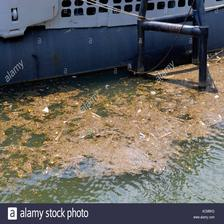

In [103]:
image = Image.open(image_path).convert('RGB')
image

In [104]:
# URL: https://github.com/huggingface/transformers/blob/main/src/transformers/models/clip/image_processing_clip.py
image = image_processor.preprocess(image, return_tensors='pt')['pixel_values'][0]
print("image_tensor_shape\n", image.shape)
image

image_tensor_shape
 torch.Size([3, 336, 336])


tensor([[[ 0.0325,  0.0325,  0.0325,  ..., -0.7120, -0.3616, -0.1280],
         [ 0.0325,  0.0325,  0.0325,  ..., -0.3908, -0.1718, -0.0259],
         [ 0.0325,  0.0325,  0.0325,  ..., -0.0113,  0.0471,  0.0909],
         ...,
         [-1.0331, -1.0331, -1.0331,  ..., -1.0623, -1.0623, -1.0623],
         [-1.0477, -1.0331, -1.0331,  ..., -1.0623, -1.0623, -1.0623],
         [-1.0477, -1.0331, -1.0331,  ..., -1.0623, -1.0623, -1.0623]],

        [[ 0.3190,  0.3190,  0.3190,  ..., -0.3864, -0.0112,  0.2139],
         [ 0.3190,  0.3190,  0.3190,  ..., -0.0712,  0.1539,  0.3190],
         [ 0.3190,  0.3190,  0.3190,  ...,  0.2890,  0.3640,  0.4390],
         ...,
         [-1.0167, -1.0167, -1.0167,  ..., -1.0017, -1.0017, -1.0017],
         [-1.0317, -1.0167, -1.0167,  ..., -1.0017, -1.0017, -1.0017],
         [-1.0317, -1.0167, -1.0167,  ..., -1.0017, -1.0017, -1.0017]],

        [[ 0.9656,  0.9656,  0.9656,  ...,  0.0982,  0.4537,  0.6670],
         [ 0.9656,  0.9656,  0.9656,  ...,  0

In [105]:
i = 0
data_sample = train_dataset.list_data_dict[i]

if isinstance(i, int):
    data_sample_list = [data_sample]
if 'image' in data_sample:
    image_file = data_sample['image']
    image_folder = train_dataset.data_args.image_folder
    image_path = os.path.join(image_folder, image_file)
    image_processor = train_dataset.data_args.image_processor
    try:
        image = Image.open(image_path).convert('RGB')
    except Exception as e:
        print(f"Failed to load image {image_path}: {e}")
        raise e

    image = image_processor.preprocess(image, return_tensors='pt')['pixel_values'][0]

In [193]:
# i = 0 
import copy
dialog_pair = copy.deepcopy(data_sample["conversations"])
print("dialog_pair\n", dialog_pair)
# __getitem__ では 1サンプルずつ取り出すので、基本的にリストの長さは1
# pair は1組だが、リストにした方が便利な時があるのでリスト形式に変換する。
# リストといっても、リスト形式にしたという意味で、複数サンプルがあるわけではないので注意
# dialog_pair 自体がリストなので、二重リストになる。
dialog_pair_list = [dialog_pair]
print("dialog_pair_list\n", dialog_pair_list)

dialog_pair
 [{'from': 'human', 'value': '<image>\nShare a concise interpretation of the image provided.'}, {'from': 'gpt', 'value': 'water pollution in the city'}]
dialog_pair_list
 [[{'from': 'human', 'value': '<image>\nShare a concise interpretation of the image provided.'}, {'from': 'gpt', 'value': 'water pollution in the city'}]]


In [108]:
# 見づらいので、もう一度見やすく定義する
dialog_pair_list = [[
    {'from': 'human', 'value': 'Render a clear and concise summary of the photo.\n<image>'},
    {'from': 'gpt', 'value': 'illustration of a summer holiday in bright colors .'}
]]

print("len(dialog_pair_list)\n", len(dialog_pair_list))

len(dialog_pair_list)
 1


In [109]:
print("data_args\n", data_args)

data_args
 DataArguments(data_path='/workspaces/LLaVA/CC3M_2.json', lazy_preprocess=True, is_multimodal=True, image_folder='/workspaces/LLaVA/images/', image_aspect_ratio='square')


In [110]:
is_multimodal = data_args.is_multimodal
print("is_multimodal\n", is_multimodal)

is_multimodal
 True


In [111]:
dialog_pair = dialog_pair_list[0]
print("pair current loop\n", dialog_pair)

pair current loop
 [{'from': 'human', 'value': 'Render a clear and concise summary of the photo.\n<image>'}, {'from': 'gpt', 'value': 'illustration of a summer holiday in bright colors .'}]


In [112]:
human_dialog = dialog_pair[0]

In [113]:
print("sentence['value']\n", human_dialog['value'])
print("\nDEFAULT_IMAGE_TOKEN\n", DEFAULT_IMAGE_TOKEN)
print("【COND】 if DEFAULT_IMAGE_TOKEN in sentence['value']:", DEFAULT_IMAGE_TOKEN in human_dialog['value'])

sentence['value']
 Render a clear and concise summary of the photo.
<image>

DEFAULT_IMAGE_TOKEN
 <image>
【COND】 if DEFAULT_IMAGE_TOKEN in sentence['value']: True


In [139]:
# strip() は先頭と末尾の空白文字（スペース、タブ、改行など）をすべて削除するPythonの標準メソッドです。
# repleace で <image> (DEFAULT_IMAGE_TOKEN) を空文字に置換したあとに、strip()を適用して削除する。

human_dialog['value'] = human_dialog['value'].replace(DEFAULT_IMAGE_TOKEN, '').strip()
print("human_dialog['value'] after remove DEFAULT_IMAGE_TOKEN\n", human_dialog['value'])
print("===")

human_dialog['value'] = DEFAULT_IMAGE_TOKEN + '\n' + human_dialog['value']
print("human_dialog['value'] after adding DEFAULT_IMAGE_TOKEN to the front\n", human_dialog['value'])
print("===")

human_dialog['value'] = human_dialog['value'].strip()
print("human_dialog['value'] after strip()\n", human_dialog['value'])
print("===")

human_dialog['value'] after remove DEFAULT_IMAGE_TOKEN
 Render a clear and concise summary of the photo.
===
human_dialog['value'] after adding DEFAULT_IMAGE_TOKEN to the front
 <image>
Render a clear and concise summary of the photo.
===
human_dialog['value'] after strip()
 <image>
Render a clear and concise summary of the photo.
===


In [140]:
print("human_dialog['value']\n", human_dialog['value'])
print("\nDEFAULT_IMAGE_TOKEN\n", DEFAULT_IMAGE_TOKEN)
print("【COND】 if DEFAULT_IMAGE_TOKEN in human_dialog['value']:", DEFAULT_IMAGE_TOKEN in human_dialog['value'])
if DEFAULT_IMAGE_TOKEN in human_dialog['value']: # False
    # 【SKIP】
    human_dialog['value'] = human_dialog['value'].replace(DEFAULT_IMAGE_TOKEN, '').strip()
    print("human_dialog['value'] after remove DEFAULT_IMAGE_TOKEN\n", human_dialog['value'])
    print("===")

    human_dialog['value'] = DEFAULT_IMAGE_TOKEN + '\n' + human_dialog['value']
    print("human_dialog['value'] after adding DEFAULT_IMAGE_TOKEN to the front\n", human_dialog['value'])
    print("===")

    human_dialog['value'] = human_dialog['value'].strip()
    print("human_dialog['value'] after strip()\n", human_dialog['value'])

print("DONE")

human_dialog['value']
 <image>
Render a clear and concise summary of the photo.

DEFAULT_IMAGE_TOKEN
 <image>
【COND】 if DEFAULT_IMAGE_TOKEN in human_dialog['value']: True
human_dialog['value'] after remove DEFAULT_IMAGE_TOKEN
 Render a clear and concise summary of the photo.
===
human_dialog['value'] after adding DEFAULT_IMAGE_TOKEN to the front
 <image>
Render a clear and concise summary of the photo.
===
human_dialog['value'] after strip()
 <image>
Render a clear and concise summary of the photo.
DONE


In [141]:
gpt_dialog = dialog_pair[1]
print("gpt_dialog current loop\n", gpt_dialog)

gpt_dialog current loop
 {'from': 'gpt', 'value': 'illustration of a summer holiday in bright colors .'}


In [142]:
print("gpt_dialog['value']\n", gpt_dialog['value'])
print("\nDEFAULT_IMAGE_TOKEN\n", DEFAULT_IMAGE_TOKEN)
print("【COND】 if DEFAULT_IMAGE_TOKEN in gpt_dialog['value']:", DEFAULT_IMAGE_TOKEN in gpt_dialog['value'])
if DEFAULT_IMAGE_TOKEN in gpt_dialog['value']: # False
    # 【SKIP】
    gpt_dialog['value'] = gpt_dialog['value'].replace(DEFAULT_IMAGE_TOKEN, '').strip()
    print("gpt_dialog['value'] after remove DEFAULT_IMAGE_TOKEN\n", gpt_dialog['value'])
    print("===")

    gpt_dialog['value'] = DEFAULT_IMAGE_TOKEN + '\n' + gpt_dialog['value']
    print("gpt_dialog['value'] after adding DEFAULT_IMAGE_TOKEN\n", gpt_dialog['value'])
    print("===")

    gpt_dialog['value'] = gpt_dialog['value'].strip()
    print("gpt_dialog['value'] after strip()\n", gpt_dialog['value'])

print("DONE")

gpt_dialog['value']
 illustration of a summer holiday in bright colors .

DEFAULT_IMAGE_TOKEN
 <image>
【COND】 if DEFAULT_IMAGE_TOKEN in gpt_dialog['value']: False
DONE


In [240]:
from typing import Sequence
from typing import Dict

def preprocess_multimodal(
    dialog_pair: Sequence[str],
    data_args: DataArguments
) -> Dict:

    print("current file path", "llava/train/train.py")
    print("def preprocess_multimodal(dialog_pair, data_args)")
    print("dialog_pair\n", dialog_pair) # [{'from': 'human', 'value': 'Give a brief description of the image.\n<image>'}, {'from': 'gpt', 'value': 'the divine queen in her elaborate masks canvas print featuring the face and hands of a woman with red hair'}]
    print("data_args\n", data_args) # DataArguments(data_path='/content/LLaVA/blip_laion_cc_sbu_1.json', lazy_preprocess=True, is_multimodal=True, image_folder='/content/LLaVA/images', image_aspect_ratio='square')
    for dialog in dialog_pair:
        if DEFAULT_IMAGE_TOKEN in dialog['value']:
            dialog['value'] = dialog['value'].replace(DEFAULT_IMAGE_TOKEN, '').strip()
            dialog['value'] = DEFAULT_IMAGE_TOKEN + '\n' + dialog['value']
            dialog['value'] = dialog['value'].strip()
    return dialog_pair

In [241]:
dialog_pair= [
    {'from': 'human', 'value': 'Render a clear and concise summary of the photo.\n<image>'},
    {'from': 'gpt', 'value': 'illustration of a summer holiday in bright colors .'}
]

In [242]:
dialog_pair = preprocess_multimodal(dialog_pair, data_args)
print("dialog_pair\n", dialog_pair)

current file path llava/train/train.py
def preprocess_multimodal(dialog_pair, data_args)
dialog_pair
 [{'from': 'human', 'value': 'Render a clear and concise summary of the photo.\n<image>'}, {'from': 'gpt', 'value': 'illustration of a summer holiday in bright colors .'}]
data_args
 DataArguments(data_path='/workspaces/LLaVA/CC3M_2.json', lazy_preprocess=True, is_multimodal=True, image_folder='/workspaces/LLaVA/images/', image_aspect_ratio='square')
dialog_pair
 [{'from': 'human', 'value': '<image>\nRender a clear and concise summary of the photo.'}, {'from': 'gpt', 'value': 'illustration of a summer holiday in bright colors .'}]


In [243]:
# 他のサンプルでも試してみる
dialog_pair = [
    {'from': 'human', 'value': '<image>\nShare a concise interpretation of the image provided.'},
    {'from': 'gpt', 'value': 'water pollution in the city'}
]

In [244]:
dialog_pair = preprocess_multimodal(dialog_pair, data_args)
print("dialog_pair\n", dialog_pair)

current file path llava/train/train.py
def preprocess_multimodal(dialog_pair, data_args)
dialog_pair
 [{'from': 'human', 'value': '<image>\nShare a concise interpretation of the image provided.'}, {'from': 'gpt', 'value': 'water pollution in the city'}]
data_args
 DataArguments(data_path='/workspaces/LLaVA/CC3M_2.json', lazy_preprocess=True, is_multimodal=True, image_folder='/workspaces/LLaVA/images/', image_aspect_ratio='square')
dialog_pair
 [{'from': 'human', 'value': '<image>\nShare a concise interpretation of the image provided.'}, {'from': 'gpt', 'value': 'water pollution in the city'}]


In [148]:
""""
def __len__(self):

    print("current file path", "llava/train/train.py")
    print("def LazySupervisedDataset.__len__(self)")
    return len(self.list_data_dict)
LazySupervisedDataset.__len__ = __len__
"""

'"\ndef __len__(self):\n\n    print("current file path", "llava/train/train.py")\n    print("def LazySupervisedDataset.__len__(self)")\n    return len(self.list_data_dict)\nLazySupervisedDataset.__len__ = __len__\n'

In [174]:
prompt = "<image>illustration of a summer holiday in bright colors . \n"
image_token_index = IMAGE_TOKEN_INDEX # -200
return_tensors = "pt"

from transformers import AutoTokenizer
# 例: TinyLlama用
tokenizer = AutoTokenizer.from_pretrained("TinyLlama/TinyLlama-1.1B-Chat-v1.0", use_fast=False)
tokenizer.pad_token = tokenizer.unk_token

print("prompt:", prompt)
print("tokenizer:", tokenizer)
print("image_token_index:", image_token_index)
print("return_tensors:", return_tensors)

/opt/venv/lib/python3.10/site-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


prompt: <image>illustration of a summer holiday in bright colors . 

tokenizer: LlamaTokenizer(name_or_path='TinyLlama/TinyLlama-1.1B-Chat-v1.0', vocab_size=32000, model_max_length=2048, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=False), 'eos_token': AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=False), 'unk_token': AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=False), 'pad_token': '<unk>'}, clean_up_tokenization_spaces=False)
image_token_index: -200
return_tensors: pt


In [175]:
text_before_image, text_after_image = prompt.split("<image>")
print("text_before_image\n", text_before_image) # Nothing
print("text_after_image\n", text_after_image) # caption

text_before_image
 
text_after_image
 illustration of a summer holiday in bright colors . 



In [176]:
# tokenizer(chunk).input_ids の 1 は、<s> という、BOS (Beginning Of Sentence) トークンのIDです。
# 全く何もない場合でも、<s> という 特殊トークンとして扱われます。
ids_before_image = tokenizer(text_before_image).input_ids
print("ids_before_image\n", ids_before_image)
ids_after_image = tokenizer(text_after_image).input_ids
print("ids_after_image\n", ids_after_image)

# [テキスト前] + [画像トークン] + [テキスト後]
ids_after_image_no_bos = ids_after_image[1:]
input_ids = ids_before_image + [image_token_index] + ids_after_image_no_bos
print("input_ids\n", input_ids)

ids_before_image
 [1]
ids_after_image
 [1, 8632, 362, 310, 263, 11801, 8753, 22394, 297, 11785, 11955, 869, 29871, 13]
input_ids
 [1, -200, 8632, 362, 310, 263, 11801, 8753, 22394, 297, 11785, 11955, 869, 29871, 13]


In [177]:
if return_tensors == "pt":
    tokenized_ids = torch.tensor(input_ids, dtype=torch.long)

print("tokenized_ids\n", tokenized_ids)

tokenized_ids
 tensor([    1,  -200,  8632,   362,   310,   263, 11801,  8753, 22394,   297,
        11785, 11955,   869, 29871,    13])


In [178]:
def tokenizer_image_token(prompt, tokenizer, image_token_index=IMAGE_TOKEN_INDEX, return_tensors=None):
    # <image> の前後で分割
    text_before_image, text_after_image = prompt.split("<image>")

    # トークナイズ
    ids_before_image = tokenizer(text_before_image).input_ids
    ids_after_image = tokenizer(text_after_image).input_ids
    ids_after_image_no_bos = ids_after_image[1:]

    # [テキスト前] + [画像トークン] + [テキスト後]
    input_ids = ids_before_image + [image_token_index] + ids_after_image_no_bos

    if return_tensors == "pt":
        return torch.tensor(input_ids, dtype=torch.long)
    return input_ids


In [194]:
prompt = "<image>illustration of a summer holiday in bright colors .\n'"
image_token_index = IMAGE_TOKEN_INDEX # -200
return_tensors = "pt"

from transformers import AutoTokenizer
# 例: TinyLlama用
tokenizer = AutoTokenizer.from_pretrained("TinyLlama/TinyLlama-1.1B-Chat-v1.0", use_fast=False)
tokenizer.pad_token = tokenizer.unk_token

print("prompt:", prompt)
print("tokenizer:", tokenizer)
print("image_token_index:", image_token_index)
print("return_tensors:", return_tensors)

tokenizer_image_token(prompt, tokenizer, image_token_index, return_tensors)

/opt/venv/lib/python3.10/site-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


prompt: <image>illustration of a summer holiday in bright colors .
'
tokenizer: LlamaTokenizer(name_or_path='TinyLlama/TinyLlama-1.1B-Chat-v1.0', vocab_size=32000, model_max_length=2048, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=False), 'eos_token': AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=False), 'unk_token': AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=False), 'pad_token': '<unk>'}, clean_up_tokenization_spaces=False)
image_token_index: -200
return_tensors: pt


tensor([    1,  -200,  8632,   362,   310,   263, 11801,  8753, 22394,   297,
        11785, 11955,   869,    13, 29915])

In [158]:
"""
# tokenizer(chunk).input_ids の 1 は、<s> という、BOS (Beginning Of Sentence) トークンのIDです。
# 全く何もない場合でも、<s> という 特殊トークンとして扱われます。
for chunk in prompt.split("<image>"):
    print("chunk\n", chunk)
    print("tokenizer(chunk)\n", tokenizer(chunk))
    print("tokenizer(chunk).input_ids\n", tokenizer(chunk).input_ids)
    print("")

# セル2：<image>で分割してトークン化
prompt_chunks = [tokenizer(chunk).input_ids for chunk in prompt.split("<image>")]
print("prompt_chunks =", prompt_chunks)

print("prompt_chunks\n", prompt_chunks)
print("prompt_chunks[0]\n", prompt_chunks[0])
print("prompt_chunks[0][0]\n", prompt_chunks[0][0])

# ======================
# セル3：画像トークンを間に挟む処理（関数なし）
# ======================
input_ids = []
offset = 0

# 最初のチャンクがBOSトークンで始まっていたら、その分をスキップ
if len(prompt_chunks) > 0 and len(prompt_chunks[0]) > 0 and prompt_chunks[0][0] == tokenizer.bos_token_id:
    offset = 1
    input_ids.append(prompt_chunks[0][0])
print("offset =", offset)
print("input_ids\n", input_ids)

# チャンクと画像トークンを交互に並べる
for i, chunk in enumerate(prompt_chunks):
    # チャンクの実体を追加
    print("current chunk\n", chunk)
    input_ids.extend(chunk[offset:])
    print("input_ids\n", input_ids)
    # 最後以外には画像トークンを挿入
    if i < len(prompt_chunks) - 1: # len(prompt_chunks) -1  = 2 -1 = 1 より、i=0
        print("i", i)
        input_ids.extend([image_token_index])
        print(f"--> insert image_token_index ({image_token_index}) between chunks")

print("統合後の input_ids:", input_ids)


# ======================
# セル4：return_tensors の処理
# ======================
import torch

if return_tensors == "pt":
    input_ids = torch.tensor(input_ids, dtype=torch.long)

print("最終出力:")
print(input_ids)

# セル4：offset処理と最初の BOS トークン確認
input_ids = []
offset = 0

if len(prompt_chunks) > 0 and len(prompt_chunks[0]) > 0 and prompt_chunks[0][0] == tokenizer.bos_token_id:
    offset = 1
    input_ids.append(prompt_chunks[0][0])

print("offset =", offset)
print("初期input_ids =", input_ids)

# セル6：return_tensorsの処理
import torch

if return_tensors is not None:
    if return_tensors == "pt":
        input_ids = torch.tensor(input_ids, dtype=torch.long)
    else:
        raise ValueError(f"Unsupported tensor type: {return_tensors}")

print("最終出力:")
print(input_ids)
"""


chunk
 
tokenizer(chunk)
 {'input_ids': [1], 'attention_mask': [1]}
tokenizer(chunk).input_ids
 [1]

chunk
 illustration of a summer holiday in bright colors .
tokenizer(chunk)
 {'input_ids': [1, 8632, 362, 310, 263, 11801, 8753, 22394, 297, 11785, 11955, 869], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}
tokenizer(chunk).input_ids
 [1, 8632, 362, 310, 263, 11801, 8753, 22394, 297, 11785, 11955, 869]



In [181]:
"""
def tokenizer_image_token(prompt, tokenizer, image_token_index=IMAGE_TOKEN_INDEX, return_tensors=None):

    print("current file path", "llava/mm_utils.py")
    print("def tokenizer_image_token(prompt, tokenizer, image_token_index=IMAGE_TOKEN_INDEX, return_tensors=None)")
    print("prompt\n", prompt) # <image>the divine queen in her elaborate masks canvas print featuring the face and hands of a woman with red hair
    print("tokenizer\n", tokenizer) #  LlamaTokenizer(name_or_path='lmsys/vicuna-7b-v1.5', vocab_size=32000, model_max_length=2048, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=False), 'eos_token': AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=False), 'unk_token': AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=False), 'pad_token': '<unk>'}, clean_up_tokenization_spaces=False)
    print("image_token_index\n", image_token_index) # -200
    print("return_tensors\n", return_tensors) # pt
    prompt_chunks = [tokenizer(chunk).input_ids for chunk in prompt.split('<image>')]

    def insert_separator(X, sep):
        return [ele for sublist in zip(X, [sep]*len(X)) for ele in sublist][:-1]

    input_ids = []
    offset = 0
    if len(prompt_chunks) > 0 and len(prompt_chunks[0]) > 0 and prompt_chunks[0][0] == tokenizer.bos_token_id:
        offset = 1
        input_ids.append(prompt_chunks[0][0])

    for x in insert_separator(prompt_chunks, [image_token_index] * (offset + 1)):
        input_ids.extend(x[offset:])

    if return_tensors is not None:
        if return_tensors == 'pt':
            return torch.tensor(input_ids, dtype=torch.long)
        raise ValueError(f'Unsupported tensor type: {return_tensors}')
    print("input_ids (return)\n", input_ids)
    return input_ids
"""

'\ndef tokenizer_image_token(prompt, tokenizer, image_token_index=IMAGE_TOKEN_INDEX, return_tensors=None):\n\n    print("current file path", "llava/mm_utils.py")\n    print("def tokenizer_image_token(prompt, tokenizer, image_token_index=IMAGE_TOKEN_INDEX, return_tensors=None)")\n    print("prompt\n", prompt) # <image>the divine queen in her elaborate masks canvas print featuring the face and hands of a woman with red hair\n    print("tokenizer\n", tokenizer) #  LlamaTokenizer(name_or_path=\'lmsys/vicuna-7b-v1.5\', vocab_size=32000, model_max_length=2048, is_fast=False, padding_side=\'right\', truncation_side=\'right\', special_tokens={\'bos_token\': AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=False), \'eos_token\': AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=False), \'unk_token\': AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=False), \'pad_token\': \'<unk>\'}, clean_up_tokenization_spaces=F

In [195]:
dialog_pair_list = [[
    {'from': 'human', 'value': '<image>\nRender a clear and concise summary of the photo.'},
    {'from': 'gpt', 'value': 'illustration of a summer holiday in bright colors .'}
]]

In [245]:
import copy

def preprocess_plain(
    dialog_pair: Sequence[str],
    tokenizer: transformers.PreTrainedTokenizer,
) -> Dict:
    
    print("current file path", "llava/train/train.py")
    print("def preprocess_plain(dialog_pair, tokenizer)")
    print("dialog_pair\n", dialog_pair) # [[{'from': 'human', 'value': '<image>\nGive a brief description of the image.'}, {'from': 'gpt', 'value': 'the divine queen in her elaborate masks canvas print featuring the face and hands of a woman with red hair'}]]
    print("tokenizer\n", type(tokenizer)) # <class 'transformers.models.llama.tokenization_llama.LlamaTokenizer'>
    # add end signal and concatenate together
    
    human_dialog = dialog_pair[0]['value']
    print("human_dialog\n", human_dialog) # <image>\nGive a brief description of the image.
    gpt_dialog = dialog_pair[1]['value']
    print("gpt_dialog\n", gpt_dialog) # the divine queen in her elaborate
    default_conversation = conv_templates["plain"] # hard coding
    sep_token = default_conversation.sep # separator_token "\n"

    prompt = DEFAULT_IMAGE_TOKEN + gpt_dialog + sep_token
    print("prompt\n", prompt)
    input_ids = tokenizer_image_token(prompt=prompt, tokenizer=tokenizer, return_tensors='pt')
    target_ids = copy.deepcopy(input_ids)


    tokenized_len = len(tokenizer_image_token(DEFAULT_IMAGE_TOKEN, tokenizer)) # prompt <image>
    print("tokenized_len\n", tokenized_len) # 2
    target_ids[:tokenized_len] = IGNORE_INDEX

    # list処理はその後に重複があるのでコメントアウト
    #input_ids_list = [input_ids]
    #target_ids_list = [target_ids]

    data_dict = dict(input_ids=input_ids, labels=target_ids)

    return data_dict

In [ ]:
"""
def preprocess(
    sources: Sequence[str],
    tokenizer: transformers.PreTrainedTokenizer,
    has_image: bool = False
) -> Dict:

    print("current file path", "llava/train/train.py")
    print("def preprocess(sources, tokenizer, has_image=False)")
    print("sources\n", sources) # [[{'from': 'human', 'value': '<image>\nGive a brief description of the image.'}, {'from': 'gpt', 'value': 'the divine queen in her elaborate masks canvas print featuring the face and hands of a woman with red hair'}]]
    print("tokenizer\n", type(tokenizer)) # <class 'transformers.models.llama.tokenization_llama.LlamaTokenizer'>
    print("has_image\n", has_image) # True
    
    # Given a list of sources, each is a conversation list. This transform:
    # 1. Add signal '### ' at the beginning each sentence, with end signal '\n';
    # 2. Concatenate conversations together;
    # 3. Tokenize the concatenated conversation;
    # 4. Make a deepcopy as the target. Mask human words with IGNORE_INDEX.
    if default_conversation.sep_style == SeparatorStyle.PLAIN:
        return preprocess_plain(sources, tokenizer) # True
"""

In [229]:
dialog_pair_list = [[
    {'from': 'human', 'value': '<image>\nRender a clear and concise summary of the photo.'},
    {'from': 'gpt', 'value': 'illustration of a summer holiday in bright colors .'}
]]

from transformers import AutoTokenizer
# 例: TinyLlama用
tokenizer = AutoTokenizer.from_pretrained("TinyLlama/TinyLlama-1.1B-Chat-v1.0", use_fast=False)
tokenizer.pad_token = tokenizer.unk_token

data_dict = preprocess_plain(dialog_pair_list, tokenizer)
data_dict

current file path llava/train/train.py
def preprocess_plain(dialog_pair_list, tokenizer)
dialog_pair_list
 [[{'from': 'human', 'value': '<image>\nRender a clear and concise summary of the photo.'}, {'from': 'gpt', 'value': 'illustration of a summer holiday in bright colors .'}]]
tokenizer
 <class 'transformers.models.llama.tokenization_llama.LlamaTokenizer'>
human_dialog
 <image>
Render a clear and concise summary of the photo.
gpt_dialog
 illustration of a summer holiday in bright colors .
prompt
 <image>illustration of a summer holiday in bright colors .

tokenized_len
 2


{'input_ids': tensor([    1,  -200,  8632,   362,   310,   263, 11801,  8753, 22394,   297,
         11785, 11955,   869,    13]),
 'labels': tensor([ -100,  -100,  8632,   362,   310,   263, 11801,  8753, 22394,   297,
         11785, 11955,   869,    13])}

In [ ]:
import copy
from PIL import Image

# Trainer > def _get_dataloader > dataloader = self.accelerator.prepare(DataLoader(dataset, **dataloader_params))
def __getitem__(self, i) -> Dict[str, torch.Tensor]:

    print("current file path", "llava/train/train.py")
    print("def LazySupervisedDataset.__getitem__(self, i)")
    print("i\n", i) # 0
    data_sample = self.list_data_dict[i]
    dialog_pair = copy.deepcopy(data_sample["conversations"])
    
    # 画像+テキストのサンプル
    if 'image' in data_sample:
        image_file = data_sample['image']
        image_folder = self.data_args.image_folder
        image_processor = self.data_args.image_processor      
        image_path = os.path.join(image_folder, image_file)
        print("image_path\n", image_path)
        try:
            image = Image.open(image_path).convert('RGB')
        except Exception as e:
            print(f"Error opening image: {e}")
            # 画像ファイルのパスがなければこのサンプルは無効としてスキップ
            print("Skipping this sample due to image loading error.")
            return None
        image = image_processor.preprocess(image, return_tensors='pt')['pixel_values'][0]
        dialog_pair = preprocess_multimodal(dialog_pair, self.data_args)
        data_dict = preprocess_plain(dialog_pair, self.tokenizer)
    # テキストのみのサンプル
    else:
        dialog_pair = copy.deepcopy(data_sample["conversations"])
        data_dict = preprocess_plain(dialog_pair, self.tokenizer)

    print("Calling preprocess...")
    data_dict = preprocess_plain(dialog_pair, self.tokenizer)
    print("data_dict (after preprocess)\n", data_dict)

    # image exist in the data
    if 'image' in data_sample:
        data_dict['image'] = image
    elif self.data_args.is_multimodal:
        # image does not exist in the data, but the model is multimodal
        # 完全な黒の画像をダミー画像として生成して添える
        crop_size = self.data_args.image_processor.crop_size
        data_dict['image'] = torch.zeros(3, crop_size['height'], crop_size['width'])
    return data_dict

In [ ]:
"""
import copy

def preprocess_plain(s
    sources: Sequence[str],
    tokenizer: transformers.PreTrainedTokenizer,
) -> Dict:

    print("current file path", "llava/train/train.py")
    print("def preprocess_plain(sources, tokenizer)")
    print("sources\n", sources) # [[{'from': 'human', 'value': '<image>\nGive a brief description of the image.'}, {'from': 'gpt', 'value': 'the divine queen in her elaborate masks canvas print featuring the face and hands of a woman with red hair'}]]
    print("tokenizer\n", type(tokenizer)) # <class 'transformers.models.llama.tokenization_llama.LlamaTokenizer'>
    # add end signal and concatenate together
    conversations = []
    print("conversations initial\n", conversations) # []
    for source in sources:
        print("source current loop\n", source) 
        assert len(source) == 2
        assert DEFAULT_IMAGE_TOKEN in source[0]['value']
        source[0]['value'] = DEFAULT_IMAGE_TOKEN
        conversation = source[0]['value'] + source[1]['value'] + default_conversation.sep
        print("conversation current loop\n", conversation)
        conversations.append(conversation)
    print("conversations (final)\n", conversations) #  ['<image>the divine queen in her elaborate masks canvas print featuring the face and hands of a woman with red hair\n']
    # tokenize conversations
    input_ids = [tokenizer_image_token(prompt, tokenizer, return_tensors='pt') for prompt in conversations]
    print("input_ids\n", input_ids) # [tensor([    1,  -200,   278, 25616, 26624,   297,   902, 19430, 11105, 29879, 10508,  1596, 23425,   278,  3700,   322,  6567,   310,   263,  6114, 411,  2654, 11315,    13])]
    for idx, tensor in enumerate(input_ids):
        if hasattr(tensor, 'shape'):
            print(f"input_ids[{idx}].shape\n", tensor.shape) # torch.Size([24])
    targets = copy.deepcopy(input_ids)
    print("targets\n", targets) # [tensor([    1,  -200,   278, 25616, 26624,   297,   902, 19430, 11105, 29879, 10508,  1596, 23425,   278,  3700,   322,  6567,   310,   263,  6114, 411,  2654, 11315,    13])]
    for idx, tensor in enumerate(targets):
        if hasattr(tensor, 'shape'):
            print(f"targets[{idx}].shape\n", tensor.shape) # torch.Size([24])
    print("sources\n", sources) # [[{'from': 'human', 'value': '<image>'}, {'from': 'gpt', 'value': 'the divine queen in her elaborate masks canvas print featuring the face and hands of a woman with red hair'}]]
    for target, source in zip(targets, sources):
        tokenized_len = len(tokenizer_image_token(source[0]['value'], tokenizer)) # prompt <image>
        target[:tokenized_len] = IGNORE_INDEX

    print("input_ids (return)\n", input_ids) # [tensor([    1,  -200,   278, 25616, 26624,   297,   902, 19430, 11105, 29879, 10508,  1596, 23425,   278,  3700,   322,  6567,   310,   263,  6114, 411,  2654, 11315,    13])]
    print("targets (return)\n", targets) #  [tensor([ -100,  -100,   278, 25616, 26624,   297,   902, 19430, 11105, 29879, 10508,  1596, 23425,   278,  3700,   322,  6567,   310,   263,  6114, 411,  2654, 11315,    13])]
    return dict(input_ids=input_ids, labels=targets)
"""

In [198]:
import torch

# 擬似データの input_ids, labels
input_ids0 = torch.tensor([1, -200, 4094, 21180, 918, 297, 278, 4272, 13])
labels0 = torch.tensor([-100, -100, 4094, 21180, 918, 297, 278, 4272, 13])
image0 = torch.randn(3, 336, 336)

input_ids1 = torch.tensor([1, -200, 8632, 362, 310, 263, 11801, 8753, 22394, 297, 11785, 11955, 869, 13])
labels1 = torch.tensor([-100, -100, 8632, 362, 310, 263, 11801, 8753, 22394, 297, 11785, 11955, 869, 13])
image1 = torch.randn(3, 336, 336)

instances = [
    {
        "input_ids": input_ids0,
        "labels": labels0,
        "image": image0
    },
    {
        "input_ids": input_ids1 ,
        "labels": labels1,
        "image": image1
    }
]

In [199]:
from transformers import AutoTokenizer

# 例: TinyLlama用
tokenizer = AutoTokenizer.from_pretrained("TinyLlama/TinyLlama-1.1B-Chat-v1.0", use_fast=False)
tokenizer.pad_token = tokenizer.unk_token

def custom_decode(input_ids, tokenizer):
    # -200 など特殊トークンは手動で置換
    tokens = []
    for id in input_ids.tolist():
        if id == -200:
            tokens.append("<image>")
        elif id == -100:
            tokens.append("<IGNORE>")
        else:
            tokens.append(tokenizer.decode([id], skip_special_tokens=False))
    return " ".join(tokens)

print("input_ids0:", custom_decode(input_ids0, tokenizer))
print("input_ids1:", custom_decode(input_ids1, tokenizer))

input_ids0: <s> <image> water poll ution in the city 

input_ids1: <s> <image> illustr ation of a summer hol iday in bright colors . 



In [200]:
instances

[{'input_ids': tensor([    1,  -200,  4094, 21180,   918,   297,   278,  4272,    13]),
  'labels': tensor([ -100,  -100,  4094, 21180,   918,   297,   278,  4272,    13]),
  'image': tensor([[[-1.8835, -0.3822, -2.5373,  ..., -0.7053, -0.9337,  1.1468],
           [-1.2558,  2.5180, -0.4216,  ...,  0.8925, -0.5908,  0.3425],
           [-2.6587,  0.0197, -1.3906,  ...,  0.9975, -0.4158,  0.8519],
           ...,
           [ 0.2711, -1.3692,  0.1377,  ...,  0.2996, -1.0353, -0.6736],
           [ 0.0296,  1.7625, -0.9573,  ...,  0.6216,  1.0572, -1.3407],
           [-0.2703, -0.5290, -0.3409,  ...,  1.2841,  0.6272,  0.8975]],
  
          [[-0.1837, -0.5841,  1.1485,  ..., -0.2424,  0.4561, -0.4998],
           [-0.6487,  0.0952,  0.3311,  ..., -1.0449, -0.3937, -0.8867],
           [ 3.2370,  0.2340,  0.4478,  ...,  0.0451, -1.9259, -0.3385],
           ...,
           [ 0.3318, -0.2168,  0.2938,  ..., -0.4289,  0.9286, -0.2047],
           [ 1.2384, -0.8697,  0.3743,  ..., -0.4930

In [201]:
# データローダーが None を返すことがあるので、Noneのサンプルを除外。
instances = [x for x in instances if x is not None]

In [202]:
input_ids, labels = tuple([instance[key] for instance in instances] 
                          for key in ("input_ids", "labels"))

In [203]:
print("input_ids\n", input_ids)
print("labels\n", labels)

input_ids
 [tensor([    1,  -200,  4094, 21180,   918,   297,   278,  4272,    13]), tensor([    1,  -200,  8632,   362,   310,   263, 11801,  8753, 22394,   297,
        11785, 11955,   869,    13])]
labels
 [tensor([ -100,  -100,  4094, 21180,   918,   297,   278,  4272,    13]), tensor([ -100,  -100,  8632,   362,   310,   263, 11801,  8753, 22394,   297,
        11785, 11955,   869,    13])]


In [204]:
# input_idsはtokenizerのpad_token_id(0)でパディング
print("tokenizer.pad_token_id\n", tokenizer.pad_token_id)
input_ids = torch.nn.utils.rnn.pad_sequence(
    input_ids,
    batch_first=True,
    padding_value=tokenizer.pad_token_id
)
print("input_ids\n", input_ids)

tokenizer.pad_token_id
 0
input_ids
 tensor([[    1,  -200,  4094, 21180,   918,   297,   278,  4272,    13,     0,
             0,     0,     0,     0],
        [    1,  -200,  8632,   362,   310,   263, 11801,  8753, 22394,   297,
         11785, 11955,   869,    13]])


In [205]:
# labelsはIGNORE_INDEX(-100)でパディング
print("IGNORE_INDEX\n", IGNORE_INDEX)
labels = torch.nn.utils.rnn.pad_sequence(
    labels,
    batch_first=True,
    padding_value=IGNORE_INDEX
)
print("labels\n", labels)

IGNORE_INDEX
 -100
labels
 tensor([[ -100,  -100,  4094, 21180,   918,   297,   278,  4272,    13,  -100,
          -100,  -100,  -100,  -100],
        [ -100,  -100,  8632,   362,   310,   263, 11801,  8753, 22394,   297,
         11785, 11955,   869,    13]])


In [206]:
tokenizer.model_max_length

2048

In [207]:
input_ids = input_ids[:, :tokenizer.model_max_length]
labels = labels[:, :tokenizer.model_max_length]

In [208]:
print("input_ids\n", input_ids)
print("labels\n", labels)

input_ids
 tensor([[    1,  -200,  4094, 21180,   918,   297,   278,  4272,    13,     0,
             0,     0,     0,     0],
        [    1,  -200,  8632,   362,   310,   263, 11801,  8753, 22394,   297,
         11785, 11955,   869,    13]])
labels
 tensor([[ -100,  -100,  4094, 21180,   918,   297,   278,  4272,    13,  -100,
          -100,  -100,  -100,  -100],
        [ -100,  -100,  8632,   362,   310,   263, 11801,  8753, 22394,   297,
         11785, 11955,   869,    13]])


In [209]:
attention_mask=input_ids.ne(tokenizer.pad_token_id)
print("attention_mask\n", attention_mask)

attention_mask
 tensor([[ True,  True,  True,  True,  True,  True,  True,  True,  True, False,
         False, False, False, False],
        [ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True]])


In [210]:
batch = dict(
    input_ids=input_ids,
    labels=labels,
    attention_mask=attention_mask,
)

In [211]:
batch

{'input_ids': tensor([[    1,  -200,  4094, 21180,   918,   297,   278,  4272,    13,     0,
              0,     0,     0,     0],
         [    1,  -200,  8632,   362,   310,   263, 11801,  8753, 22394,   297,
          11785, 11955,   869,    13]]),
 'labels': tensor([[ -100,  -100,  4094, 21180,   918,   297,   278,  4272,    13,  -100,
           -100,  -100,  -100,  -100],
         [ -100,  -100,  8632,   362,   310,   263, 11801,  8753, 22394,   297,
          11785, 11955,   869,    13]]),
 'attention_mask': tensor([[ True,  True,  True,  True,  True,  True,  True,  True,  True, False,
          False, False, False, False],
         [ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
           True,  True,  True,  True]])}

In [212]:
if 'image' in instances[0]:
    # 画像リストを抽出
    images = [instance['image'] for instance in instances]

In [213]:
images

[tensor([[[-1.8835, -0.3822, -2.5373,  ..., -0.7053, -0.9337,  1.1468],
          [-1.2558,  2.5180, -0.4216,  ...,  0.8925, -0.5908,  0.3425],
          [-2.6587,  0.0197, -1.3906,  ...,  0.9975, -0.4158,  0.8519],
          ...,
          [ 0.2711, -1.3692,  0.1377,  ...,  0.2996, -1.0353, -0.6736],
          [ 0.0296,  1.7625, -0.9573,  ...,  0.6216,  1.0572, -1.3407],
          [-0.2703, -0.5290, -0.3409,  ...,  1.2841,  0.6272,  0.8975]],
 
         [[-0.1837, -0.5841,  1.1485,  ..., -0.2424,  0.4561, -0.4998],
          [-0.6487,  0.0952,  0.3311,  ..., -1.0449, -0.3937, -0.8867],
          [ 3.2370,  0.2340,  0.4478,  ...,  0.0451, -1.9259, -0.3385],
          ...,
          [ 0.3318, -0.2168,  0.2938,  ..., -0.4289,  0.9286, -0.2047],
          [ 1.2384, -0.8697,  0.3743,  ..., -0.4930,  1.5127,  0.9692],
          [ 0.1569,  0.0087,  0.6907,  ...,  0.1936, -0.0832,  0.1761]],
 
         [[-0.1304,  1.1641,  1.2552,  ...,  0.7838,  1.4909,  1.1663],
          [ 2.2470,  0.4694,

In [214]:
all_same_shape = all(
    x is not None and x.shape == images[0].shape for x in images
)

all_same_shape

True

In [215]:
# 画像をバッチ化 or リストのまま格納
if all_same_shape:
    batch['images'] = torch.stack(images)
else:
    # リストのまま渡すと困るのではないか？この疑問は未解決
    batch['images'] = images

In [216]:
batch['images']

tensor([[[[-1.8835, -0.3822, -2.5373,  ..., -0.7053, -0.9337,  1.1468],
          [-1.2558,  2.5180, -0.4216,  ...,  0.8925, -0.5908,  0.3425],
          [-2.6587,  0.0197, -1.3906,  ...,  0.9975, -0.4158,  0.8519],
          ...,
          [ 0.2711, -1.3692,  0.1377,  ...,  0.2996, -1.0353, -0.6736],
          [ 0.0296,  1.7625, -0.9573,  ...,  0.6216,  1.0572, -1.3407],
          [-0.2703, -0.5290, -0.3409,  ...,  1.2841,  0.6272,  0.8975]],

         [[-0.1837, -0.5841,  1.1485,  ..., -0.2424,  0.4561, -0.4998],
          [-0.6487,  0.0952,  0.3311,  ..., -1.0449, -0.3937, -0.8867],
          [ 3.2370,  0.2340,  0.4478,  ...,  0.0451, -1.9259, -0.3385],
          ...,
          [ 0.3318, -0.2168,  0.2938,  ..., -0.4289,  0.9286, -0.2047],
          [ 1.2384, -0.8697,  0.3743,  ..., -0.4930,  1.5127,  0.9692],
          [ 0.1569,  0.0087,  0.6907,  ...,  0.1936, -0.0832,  0.1761]],

         [[-0.1304,  1.1641,  1.2552,  ...,  0.7838,  1.4909,  1.1663],
          [ 2.2470,  0.4694, -

In [217]:
batch

{'input_ids': tensor([[    1,  -200,  4094, 21180,   918,   297,   278,  4272,    13,     0,
              0,     0,     0,     0],
         [    1,  -200,  8632,   362,   310,   263, 11801,  8753, 22394,   297,
          11785, 11955,   869,    13]]),
 'labels': tensor([[ -100,  -100,  4094, 21180,   918,   297,   278,  4272,    13,  -100,
           -100,  -100,  -100,  -100],
         [ -100,  -100,  8632,   362,   310,   263, 11801,  8753, 22394,   297,
          11785, 11955,   869,    13]]),
 'attention_mask': tensor([[ True,  True,  True,  True,  True,  True,  True,  True,  True, False,
          False, False, False, False],
         [ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
           True,  True,  True,  True]]),
 'images': tensor([[[[-1.8835, -0.3822, -2.5373,  ..., -0.7053, -0.9337,  1.1468],
           [-1.2558,  2.5180, -0.4216,  ...,  0.8925, -0.5908,  0.3425],
           [-2.6587,  0.0197, -1.3906,  ...,  0.9975, -0.4158,  0.8519],
          

In [218]:
# 画像のshapeを出力
if isinstance(batch['images'], torch.Tensor):
    print("batch['images'].shape\n", batch['images'].shape)
else:
    print("batch['images'] is a list, first shape:", images[0].shape if images else None)

batch['images'].shape
 torch.Size([2, 3, 336, 336])


data_collator とは、複数のサンプルをまとめてデータをバッチ化するもの、という意味です。

In [219]:
# Trainer > def _get_dataloader > dataloader_params = {..."collate_fn": data_collator,...}
# self.accelerator.prepare(DataLoader(dataset, **dataloader_params)) で呼ばれる

@dataclass
class DataCollatorForSupervisedDataset(object):
    """Collate examples for supervised fine-tuning."""

    tokenizer: transformers.PreTrainedTokenizer

    def __call__(self, instances: Sequence[Dict]) -> Dict[str, torch.Tensor]:

        print("current file path", "llava/train/train.py")
        print("def DataCollatorForSupervisedDataset.__call__(self, instances)")
        print("instances\n", instances)
        #  [(torch.Size([24]), torch.Size([24]), torch.Size([3, 336, 336]))]
        print("shape of each instance's input_ids and labels, and images(if any):", [(x['input_ids'].shape, x['labels'].shape, x.get('image', None).shape if 'image' in x else None) for x in instances])
        # データローダーが None を返すことがあるので、Noneのサンプルを除外。
        instances = [x for x in instances if x is not None]
        # input_idsとlabelsのそれぞれについてリストを作成。タプルをつくる。
        input_ids, labels = tuple([instance[key] for instance in instances]
                                  for key in ("input_ids", "labels"))
        # input_idsはtokenizerのpad_token_id(0)でパディング
        print("self.tokenizer.pad_token_id\n", self.tokenizer.pad_token_id)
        input_ids = torch.nn.utils.rnn.pad_sequence(
            input_ids,
            batch_first=True,
            padding_value=self.tokenizer.pad_token_id)
        # labelsはIGNORE_INDEX(-100)でパディング
        print("IGNORE_INDEX\n", IGNORE_INDEX)
        labels = torch.nn.utils.rnn.pad_sequence(labels,
                                                 batch_first=True,
                                                 padding_value=IGNORE_INDEX)
        input_ids = input_ids[:, :self.tokenizer.model_max_length]
        print("input_ids.shape (after pad_sequence and truncate)\n", input_ids.shape)
        print("input_ids (after pad_sequence and truncate)\n", input_ids)
        labels = labels[:, :self.tokenizer.model_max_length]
        print("labels.shape (after pad_sequence and truncate)\n", labels.shape)
        print("labels (after pad_sequence and truncate)\n", labels)
        # .ne() は "not equal" → pad_token_id(=0) じゃない部分を 1、pad 部分を 0 にする。モデルが pad 部分を読まないように制御するマスクです。
        attention_mask=input_ids.ne(self.tokenizer.pad_token_id)
        
        batch = dict(
            input_ids=input_ids,
            labels=labels,
            attention_mask=attention_mask,
        )

        if 'image' in instances[0]:
            images = [instance['image'] for instance in instances]
            if all(x is not None and x.shape == images[0].shape for x in images):
                batch['images'] = torch.stack(images)
            else:
                batch['images'] = images
            print("batch['images'].shape\n", batch['images'].shape)
        
        print("batch (return)\n", batch)
        print("shape of each batch's input_ids and labels, and images(if any):", [(batch['input_ids'].shape, batch['labels'].shape, batch.get('images', None).shape if 'images' in batch else None)])
        return batch

In [220]:
data_collator = DataCollatorForSupervisedDataset(tokenizer=tokenizer)

In [221]:
data_module = dict(train_dataset=train_dataset, eval_dataset=None, data_collator=data_collator)

In [222]:
from typing import Dict

def make_supervised_data_module(tokenizer: transformers.PreTrainedTokenizer,
                                data_args) -> Dict:

    print("current file path", "llava/train/train.py")
    print("def make_supervised_data_module(tokenizer, data_args)")
    print("tokenizer\n", type(tokenizer))
    print("data_args\n", data_args) #  DataArguments(data_path='/content/LLaVA/blip_laion_cc_sbu_1.json', lazy_preprocess=True, is_multimodal=True, image_folder='/content/LLaVA/images', image_aspect_ratio='square')
    """Make dataset and collator for supervised fine-tuning."""
    train_dataset = LazySupervisedDataset(tokenizer=tokenizer,
                                data_path=data_args.data_path,
                                data_args=data_args)
    print("train_dataset\n", train_dataset) # <llava.train.train.LazySupervisedDataset object at 0x7ed6341f4880>
    print("len(train_dataset)\n", len(train_dataset)) # 1
    data_collator = DataCollatorForSupervisedDataset(tokenizer=tokenizer)
    print("data_collator\n", data_collator) # DataCollatorForSupervisedDataset(tokenizer=LlamaTokenizer(name_or_path='lmsys/vicuna-7b-v1.5', vocab_size=32000, model_max_length=2048, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=False), 'eos_token': AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=False), 'unk_token': AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=False), 'pad_token': '<unk>'}, clean_up_tokenization_spaces=False))
    data_module = dict(train_dataset=train_dataset,
                  eval_dataset=None,
                  data_collator=data_collator)
    print("def make_supervised_data_module: result (return)\n", data_module) # {'train_dataset': <llava.train.train.LazySupervisedDataset object at 0x7ed6341f4880>, 'eval_dataset': None, 'data_collator': DataCollatorForSupervisedDataset(tokenizer=LlamaTokenizer(name_or_path='lmsys/vicuna-7b-v1.5', vocab_size=32000, model_max_length=2048, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=False), 'eos_token': AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=False), 'unk_token': AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=False), 'pad_token': '<unk>'}, clean_up_tokenization_spaces=False))}
    return data_module

In [223]:
data_module = make_supervised_data_module(tokenizer=tokenizer, data_args=data_args)
print("data_module\n", data_module)

current file path llava/train/train.py
def make_supervised_data_module(tokenizer, data_args)
tokenizer
 <class 'transformers.models.llama.tokenization_llama.LlamaTokenizer'>
data_args
 DataArguments(data_path='/workspaces/LLaVA/CC3M_2.json', lazy_preprocess=True, is_multimodal=True, image_folder='/workspaces/LLaVA/images/', image_aspect_ratio='square')
current file path llava/train/train.py
def LazySupervisedDataset.__init__(self, data_path, tokenizer, data_args)
data_path
 /workspaces/LLaVA/CC3M_2.json
tokenizer
 <class 'transformers.models.llama.tokenization_llama.LlamaTokenizer'>
data_args
 DataArguments(data_path='/workspaces/LLaVA/CC3M_2.json', lazy_preprocess=True, is_multimodal=True, image_folder='/workspaces/LLaVA/images/', image_aspect_ratio='square')
list_data_dict [{'id': 'GCC_train_000196242', 'image': 'GCC_train_000406392.jpg', 'conversations': [{'from': 'human', 'value': 'Render a clear and concise summary of the photo.\n<image>'}, {'from': 'gpt', 'value': 'illustration o

In [152]:
LazySupervisedDataset.__getitem__ = __getitem__

In [153]:
tokenizer = transformers.AutoTokenizer.from_pretrained(
    model_args.model_name_or_path,
    cache_dir=training_args.cache_dir,
    model_max_length=training_args.model_max_length,
    padding_side="right",
    use_fast=False,
)

print("tokenizer\n", tokenizer)

/opt/venv/lib/python3.10/site-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


tokenizer
 LlamaTokenizer(name_or_path='TinyLlama/TinyLlama-1.1B-Chat-v1.0', vocab_size=32000, model_max_length=2048, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=False), 'eos_token': AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=False), 'unk_token': AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=False), 'pad_token': AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=False)}, clean_up_tokenization_spaces=False)


In [154]:
train_dataset = LazySupervisedDataset(tokenizer=tokenizer, data_path=data_args.data_path, data_args=data_args)

current file path llava/train/train.py
def LazySupervisedDataset.__init__(self, data_path, tokenizer, data_args)
data_path
 /workspaces/LLaVA/CC3M_2.json
tokenizer
 <class 'transformers.models.llama.tokenization_llama.LlamaTokenizer'>
data_args
 DataArguments(data_path='/workspaces/LLaVA/CC3M_2.json', lazy_preprocess=True, is_multimodal=True, image_folder='/workspaces/LLaVA/images/', image_aspect_ratio='square')
list_data_dict [{'id': 'GCC_train_000406392', 'image': 'GCC_train_000406392.jpg', 'conversations': [{'from': 'human', 'value': '<image>\nShare a concise interpretation of the image provided.'}, {'from': 'gpt', 'value': 'water pollution in the city'}]}, {'id': 'GCC_train_000196242', 'image': 'GCC_train_000406392.jpg', 'conversations': [{'from': 'human', 'value': 'Render a clear and concise summary of the photo.\n<image>'}, {'from': 'gpt', 'value': 'illustration of a summer holiday in bright colors .'}]}]
current file path llava/train/train.py
def rank0_print(*args)
args
 ('Forma

In [100]:
sample_data_dict = train_dataset.__getitem__(1)
print("sample_data_dict\n", sample_data_dict)

current file path llava/train/train.py
def LazySupervisedDataset.__getitem__(self, i)
i
 1
sources
 {'id': 'GCC_train_000196242', 'image': 'GCC_train_000406392.jpg', 'conversations': [{'from': 'human', 'value': 'Render a clear and concise summary of the photo.\n<image>'}, {'from': 'gpt', 'value': 'illustration of a summer holiday in bright colors .'}]}
【COND】 isinstance(i, int): True
【ENTER】if isinstance(i, int):
sources (after)
 [{'id': 'GCC_train_000196242', 'image': 'GCC_train_000406392.jpg', 'conversations': [{'from': 'human', 'value': 'Render a clear and concise summary of the photo.\n<image>'}, {'from': 'gpt', 'value': 'illustration of a summer holiday in bright colors .'}]}]
【EXIT】if isinstance(i, int):
【COND】 'image' in sources[0]: True
【ENTER】if 'image' in sources[0]:
image_file
 GCC_train_000406392.jpg
image_folder
 /workspaces/LLaVA/images/
processor
 CLIPImageProcessor {
  "crop_size": {
    "height": 336,
    "width": 336
  },
  "do_center_crop": true,
  "do_convert_rgb": 

In [101]:
data_collator = DataCollatorForSupervisedDataset(tokenizer=tokenizer)

In [102]:
instances = [sample_data_dict]
data_collator = DataCollatorForSupervisedDataset(tokenizer=tokenizer)
batch = data_collator(instances)
print("batch\n", batch)

current file path llava/train/train.py
def DataCollatorForSupervisedDataset.__call__(self, instances)
instances
 [{'input_ids': tensor([    1,  -200,  8632,   362,   310,   263, 11801,  8753, 22394,   297,
        11785, 11955,   869,    13]), 'labels': tensor([ -100,  -100,  8632,   362,   310,   263, 11801,  8753, 22394,   297,
        11785, 11955,   869,    13]), 'image': tensor([[[ 0.0325,  0.0325,  0.0325,  ..., -0.7120, -0.3616, -0.1280],
         [ 0.0325,  0.0325,  0.0325,  ..., -0.3908, -0.1718, -0.0259],
         [ 0.0325,  0.0325,  0.0325,  ..., -0.0113,  0.0471,  0.0909],
         ...,
         [-1.0331, -1.0331, -1.0331,  ..., -1.0623, -1.0623, -1.0623],
         [-1.0477, -1.0331, -1.0331,  ..., -1.0623, -1.0623, -1.0623],
         [-1.0477, -1.0331, -1.0331,  ..., -1.0623, -1.0623, -1.0623]],

        [[ 0.3190,  0.3190,  0.3190,  ..., -0.3864, -0.0112,  0.2139],
         [ 0.3190,  0.3190,  0.3190,  ..., -0.0712,  0.1539,  0.3190],
         [ 0.3190,  0.3190,  0.3190, 

In [103]:
images = batch['images']
print("images shape\n", images.shape) # torch.Size([1, 3, 336, 336])
print("images\n", images)

images shape
 torch.Size([1, 3, 336, 336])
images
 tensor([[[[ 0.0325,  0.0325,  0.0325,  ..., -0.7120, -0.3616, -0.1280],
          [ 0.0325,  0.0325,  0.0325,  ..., -0.3908, -0.1718, -0.0259],
          [ 0.0325,  0.0325,  0.0325,  ..., -0.0113,  0.0471,  0.0909],
          ...,
          [-1.0331, -1.0331, -1.0331,  ..., -1.0623, -1.0623, -1.0623],
          [-1.0477, -1.0331, -1.0331,  ..., -1.0623, -1.0623, -1.0623],
          [-1.0477, -1.0331, -1.0331,  ..., -1.0623, -1.0623, -1.0623]],

         [[ 0.3190,  0.3190,  0.3190,  ..., -0.3864, -0.0112,  0.2139],
          [ 0.3190,  0.3190,  0.3190,  ..., -0.0712,  0.1539,  0.3190],
          [ 0.3190,  0.3190,  0.3190,  ...,  0.2890,  0.3640,  0.4390],
          ...,
          [-1.0167, -1.0167, -1.0167,  ..., -1.0017, -1.0017, -1.0017],
          [-1.0317, -1.0167, -1.0167,  ..., -1.0017, -1.0017, -1.0017],
          [-1.0317, -1.0167, -1.0167,  ..., -1.0017, -1.0017, -1.0017]],

         [[ 0.9656,  0.9656,  0.9656,  ...,  0.0982

In [104]:
def encode_images(self, images):
    print("current file path", "llava/model/llava_arch.py")
    print("def LlavaMetaForCausalLM(ABC).encode_images(self, images)")
    print("images\n", images)
    image_features = self.get_model().get_vision_tower()(images)
    image_features = self.get_model().mm_projector(image_features)
    print("image_features (return) shape\n", image_features.shape)
    print("image_features (return)\n", image_features)
    return image_features

In [105]:
LlavaBasicForCausalLM.encode_images = encode_images

NameError: name 'LlavaBasicForCausalLM' is not defined

In [ ]:
# image_forward_outs から、指定した層の特徴量 (B, 577, 1024) を取り出したのち、パッチ特徴量 (B, 576, 1024) のみを返す。
def feature_select(self, image_forward_outs):

    print("current file path", "llava/llava/model/multimodal_encoder/clip_encoder.py")
    print("def CLIPVisionTower.feature_select(self, image_forward_outs)")
    print("image_forward_outs\n", image_forward_outs) # 24層のtuple
    image_features = image_forward_outs.hidden_states[self.select_layer]
    print("image_features (after select_layer)\n", type(image_features))
    if hasattr(image_features, 'shape'):
        print("image_features.shape\n", image_features.shape) # torch.Size([1, 577, 1024])
    print(f"【COND】 select_feature={self.select_feature}") # patch
    if self.select_feature == 'patch':
        print("【ENTER】if self.select_feature == 'patch':")
        print("original image_features\n", image_features)
        """
        tensor([[[ 0.2236,  0.2432, -0.5938,  ...,  0.4863, -0.5273, -0.2041],
                [-0.0469, -0.1836, -0.0273,  ...,  0.3535,  0.3750,  0.3047],
                [-0.2598,  1.1484,  0.4844,  ...,  0.4961, -0.1719, -0.5117],
                ...,
                [ 1.7188,  0.9688,  0.8828,  ..., -0.2441, -0.8672,  1.3047],
                [ 0.7891, -0.3984,  0.6797,  ..., -0.3594, -0.9922,  0.3164],
                [ 1.5000,  0.6250,  0.3672,  ..., -0.5469, -0.4902,  0.9766]]],
            device='cuda:0', dtype=torch.bfloat16)
        """
        image_features = image_features[:, 1:]
        print("after process\n", image_features)
        """
        tensor([[[-0.0469, -0.1836, -0.0273,  ...,  0.3535,  0.3750,  0.3047],
                [-0.2598,  1.1484,  0.4844,  ...,  0.4961, -0.1719, -0.5117],
                [ 1.0625, -0.0635, -0.3730,  ...,  0.0220,  0.0820,  0.4805],
                ...,
                [ 1.7188,  0.9688,  0.8828,  ..., -0.2441, -0.8672,  1.3047],
                [ 0.7891, -0.3984,  0.6797,  ..., -0.3594, -0.9922,  0.3164],
                [ 1.5000,  0.6250,  0.3672,  ..., -0.5469, -0.4902,  0.9766]]],
            device='cuda:0', dtype=torch.bfloat16)
        """
        print("【EXIT】if self.select_feature == 'patch':")
    elif self.select_feature == 'cls_patch':
        pass
    else:
        pass
    print("selected image_feature shape\n", image_features.shape) 
    print("image_features (return)\n", image_features)
    """
    image_features (return)
    tensor([[[-0.0469, -0.1836, -0.0273,  ...,  0.3535,  0.3750,  0.3047],
            [-0.2598,  1.1484,  0.4844,  ...,  0.4961, -0.1719, -0.5117],
            [ 1.0625, -0.0635, -0.3730,  ...,  0.0220,  0.0820,  0.4805],
            ...,
            [ 1.7188,  0.9688,  0.8828,  ..., -0.2441, -0.8672,  1.3047],
            [ 0.7891, -0.3984,  0.6797,  ..., -0.3594, -0.9922,  0.3164],
            [ 1.5000,  0.6250,  0.3672,  ..., -0.5469, -0.4902,  0.9766]]],
        device='cuda:0', dtype=torch.bfloat16)
    """
    if hasattr(image_features, 'shape'):
        print("image_features.shape\n", image_features.shape) # torch.Size([1, 576, 1024])
    return image_features


In [ ]:
CLIPVisionTower.feature_select = feature_select

In [ ]:
@torch.no_grad() 
def forward(self, images):

    print("current file path", "llava/llava/model/multimodal_encoder/clip_encoder.py")
    print("def CLIPVisionTower.forward(self, images)")
    print("images shape\n", images.shape) # torch.Size([1, 3, 336, 336])
    print("images\n", images)
    
    if hasattr(images, 'shape'):
        print("images.shape\n", images.shape) # torch.Size([1, 3, 336, 336])
    print(f"【COND】 type_images_is_list={type(images) is list}") # False
    if type(images) is list:
        pass
    else:
        # 【ENTER】
        print("【ENTER】else (type(images) is not list):")
        print("original images\n", images)
        image_forward_outs = self.vision_tower(images.to(device=self.vision_tower.device, dtype=self.vision_tower.dtype), output_hidden_states=True)
        print("after process image_forward_outs\n", type(image_forward_outs)) # 24層のtuple
        image_features = self.feature_select(image_forward_outs).to(images.dtype)
        print("after process image_features\n", type(image_features)) # <class 'torch.Tensor'>
        print("【EXIT】else (type(images) is not list):")

    print("image_features (return)\n", image_features)
    """
    image_features (return)
    tensor([[[-0.0469, -0.1836, -0.0273,  ...,  0.3535,  0.3750,  0.3047],
            [-0.2598,  1.1484,  0.4844,  ...,  0.4961, -0.1719, -0.5117],
            [ 1.0625, -0.0635, -0.3730,  ...,  0.0220,  0.0820,  0.4805],
            ...,
            [ 1.7188,  0.9688,  0.8828,  ..., -0.2441, -0.8672,  1.3047],
            [ 0.7891, -0.3984,  0.6797,  ..., -0.3594, -0.9922,  0.3164],
            [ 1.5000,  0.6250,  0.3672,  ..., -0.5469, -0.4902,  0.9766]]],
        device='cuda:0', dtype=torch.bfloat16)
    """
    if hasattr(image_features, 'shape'):
        print("image_features.shape\n", image_features.shape) # 
    return image_features

In [ ]:
CLIPVisionTower.forward = forward

In [ ]:
image_features = model.encode_images(images)

In [ ]:
def prepare_inputs_labels_for_multimodal(
    self, input_ids, position_ids, attention_mask, past_key_values, labels,
    images, image_sizes=None
):
    print("current file path", "llava/model/llava_arch.py")
    """
    llava/llava/model/language_model/llava_llama.py
    """
    print("def LlavaMetaForCausalLM(ABC).prepare_inputs_labels_for_multimodal(self, input_ids, position_ids, attention_mask, past_key_values, labels, images, image_sizes=None)")  # not found
    print("input_ids\n", input_ids)
    """
    tensor([[    1,  -200,   278, 25616, 26624,   297,   902, 19430, 11105, 29879,
             10508,  1596, 23425,   278,  3700,   322,  6567,   310,   263,  6114,
               411,  2654, 11315,    13]])
    """

    print("position_ids\n", position_ids)  # None
    print("attention_mask\n", attention_mask)
    """
    tensor([[True, True, True, True, True, True, True, True, True, True, True, True,
             True, True, True, True, True, True, True, True, True, True, True, True]])
    """

    print("past_key_values\n", past_key_values)  # None
    print("labels\n", labels)
    """
    tensor([[ -100,  -100,   278, 25616, 26624,   297,   902, 19430, 11105, 29879,
             10508,  1596, 23425,   278,  3700,   322,  6567,   310,   263,  6114,
               411,  2654, 11315,    13]])
    """

    print("images\n", images)
    """
    tensor([[[[ 0.0325,  0.0325,  0.0325,  ..., -0.7120, -0.3616, -0.1280],
              [ 0.0325,  0.0325,  0.0325,  ..., -0.3908, -0.1718, -0.0259],
              [ 0.0325,  0.0325,  0.0325,  ..., -0.0113,  0.0471,  0.0909],
              ...,
              [-1.0331, -1.0331, -1.0331,  ..., -1.0623, -1.0623, -1.0623],
              [-1.0477, -1.0331, -1.0331,  ..., -1.0623, -1.0623, -1.0623],
              [-1.0477, -1.0331, -1.0331,  ..., -1.0623, -1.0623, -1.0623]],
    
             [[ 0.3190,  0.3190,  0.3190,  ..., -0.3864, -0.0112,  0.2139],
              [ 0.3190,  0.3190,  0.3190,  ..., -0.0712,  0.1539,  0.3190],
              [ 0.3190,  0.3190,  0.3190,  ...,  0.2890,  0.3640,  0.4390],
              ...,
              [-1.0167, -1.0167, -1.0167,  ..., -1.0017, -1.0017, -1.0017],
              [-1.0317, -1.0167, -1.0167,  ..., -1.0017, -1.0017, -1.0017],
              [-1.0317, -1.0167, -1.0167,  ..., -1.0017, -1.0017, -1.0017]],
    
             [[ 0.9656,  0.9656,  0.9656,  ...,  0.0982,  0.4537,  0.6670],
              [ 0.9656,  0.9656,  0.9656,  ...,  0.3968,  0.6101,  0.7523],
              [ 0.9656,  0.9656,  0.9656,  ...,  0.7523,  0.8092,  0.8377],
              ...,
              [-0.3711, -0.3853, -0.3995,  ..., -0.4279, -0.4279, -0.4279],
              [-0.3711, -0.3711, -0.3853,  ..., -0.4279, -0.4279, -0.4279],
              [-0.3853, -0.3711, -0.3711,  ..., -0.4279, -0.4279, -0.4279]]]])
    """

    print("image_sizes\n", image_sizes)  # None
    vision_tower = self.get_vision_tower()
    print("vision_tower\n", vision_tower)
    """
    CLIPVisionTower(
      (vision_tower): CLIPVisionModel(
        (vision_model): CLIPVisionTransformer(
          (embeddings): CLIPVisionEmbeddings(
            (patch_embedding): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14), bias=False)
            (position_embedding): Embedding(577, 1024)
          )
          (pre_layrnorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (encoder): CLIPEncoder(
            (layers): ModuleList(
              (0-23): 24 x CLIPEncoderLayer(
                (self_attn): CLIPAttention(
                  (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
                  (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
                  (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
                  (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
                )
                (layer_norm1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
                (mlp): CLIPMLP(
                  (activation_fn): QuickGELUActivation()
                  (fc1): Linear(in_features=1024, out_features=4096, bias=True)
                  (fc2): Linear(in_features=4096, out_features=1024, bias=True)
                )
                (layer_norm2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
              )
            )
          )
          (post_layernorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        )
      )
    )
    """

    print(f"【COND】 vision_tower_is_None={vision_tower is None} images_is_None={images is None} input_ids_shape_1_eq_1={input_ids.shape[1] == 1}")
    if vision_tower is None or images is None or input_ids.shape[1] == 1:
        pass

    print("【COND】type(images)\n", type(images))  # <class 'torch.Tensor'>
    print("【COND】images.ndim\n", images.ndim)  # 4
    if type(images) is list or images.ndim == 5:
        pass
    else:
        # 【ENTER】
        print("【ENTER】else of if type(images) is list or images.ndim == 5:")
        image_features = self.encode_images(images)
        print("image_features after encode_images shape \n", image_features.shape)  # torch.Size([1, 576, 2048])
        print("image_features after encode_images\n", image_features)
        """
        tensor([[[-0.1943,  0.1157, -0.0747,  ...,  0.0027, -0.1691, -0.3439],
                 [ 0.0437,  0.1717, -0.0998,  ...,  0.0930, -0.1386, -0.0731],
                 [-0.0505,  0.1592, -0.0982,  ...,  0.0866, -0.1123, -0.2177],
                 ...,
                 [-0.0182,  0.0850, -0.0556,  ...,  0.0622, -0.1969,  0.0129],
                 [-0.0651,  0.0586, -0.1218,  ..., -0.0614, -0.1158, -0.0104],
                 [ 0.0863,  0.0081, -0.1651,  ..., -0.2040, -0.0455,  0.0618]]],
               grad_fn=<ViewBackward0>)
        """
        print("【EXIT】else of if type(images) is list or images.ndim == 5:")

    # TODO: image start / end is not implemented here to support pretraining.
    if getattr(self.config, 'tune_mm_mlp_adapter', False) and getattr(self.config, 'mm_use_im_start_end', False):
        print("【ENTER】if getattr(self.config, 'tune_mm_mlp_adapter', False) and getattr(self.config, 'mm_use_im_start_end', False):")  # not found
        raise NotImplementedError

    # Let's just add dummy tensors if they do not exist,
    # it is a headache to deal with None all the time.
    # But it is not ideal, and if you have a better idea,
    # please open an issue / submit a PR, thanks.

    print("labels before\n", labels)
    """
    tensor([[ -100,  -100,   278, 25616, 26624,   297,   902, 19430, 11105, 29879,
             10508,  1596, 23425,   278,  3700,   322,  6567,   310,   263,  6114,
               411,  2654, 11315,    13]])
    """

    print("position_ids before\n", position_ids)  # None

    print("attention_mask before\n", attention_mask)
    """
    tensor([[True, True, True, True, True, True, True, True, True, True, True, True,
             True, True, True, True, True, True, True, True, True, True, True, True]])
    """

    _labels = labels
    _position_ids = position_ids
    _attention_mask = attention_mask
    if attention_mask is None:
        pass
    else:
        # 【ENTER】
        print("【ENTER】else of if attention_mask is None:")
        attention_mask = attention_mask.bool()
 
        print("attention_mask（after）shape \n", attention_mask.shape)  # torch.Size([1, 24])
        print("attention_mask (after)\n", attention_mask)
        """
        tensor([[True, True, True, True, True, True, True, True, True, True, True, True,
                 True, True, True, True, True, True, True, True, True, True, True, True]])
        """
        print("【EXIT】else of if attention_mask is None:")
    if position_ids is None:
        # 【ENTER】
        print("【ENTER】if position_ids is None:")
        position_ids = torch.arange(0, input_ids.shape[1], dtype=torch.long, device=input_ids.device)

        print("position_ids (after) shape \n", position_ids.shape)  # torch.Size([24])
        print("position_ids (after)\n", position_ids)
        """
        tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
                18, 19, 20, 21, 22, 23])
        """
        print("【EXIT】if position_ids is None:")
    print(f"【COND】 labels_is_None={labels is None}")
    if labels is None:
        pass

    # remove the padding using attention_mask -- FIXME
    _input_ids = input_ids
    input_ids = [cur_input_ids[cur_attention_mask] for cur_input_ids, cur_attention_mask in zip(input_ids, attention_mask)]
    labels = [cur_labels[cur_attention_mask] for cur_labels, cur_attention_mask in zip(labels, attention_mask)]
    print("input_ids after removing padding\n", input_ids)
    """
    [tensor([    1,  -200,   278, 25616, 26624,   297,   902, 19430, 11105, 29879,
            10508,  1596, 23425,   278,  3700,   322,  6567,   310,   263,  6114,
              411,  2654, 11315,    13])]
    """

    print("labels after removing padding\n", labels)
    """
    [tensor([ -100,  -100,   278, 25616, 26624,   297,   902, 19430, 11105, 29879,
            10508,  1596, 23425,   278,  3700,   322,  6567,   310,   263,  6114,
              411,  2654, 11315,    13])]
    """


    new_input_embeds = []
    new_labels = []
    cur_image_idx = 0
    for batch_idx, cur_input_ids in enumerate(input_ids):
        print("cur_input_ids shape\n", cur_input_ids.shape)   # torch.Size([24])
        print("cur_input_ids\n", cur_input_ids)
        """
        tensor([    1,  -200,   278, 25616, 26624,   297,   902, 19430, 11105, 29879,
                10508,  1596, 23425,   278,  3700,   322,  6567,   310,   263,  6114,
                  411,  2654, 11315,    13])
        """
        num_images = (cur_input_ids == IMAGE_TOKEN_INDEX).sum()
        print("【COND】num_images:", num_images)  # tensor(1)
        if num_images == 0:
            print("【ENTER】if num_images == 0:")
            cur_image_features = image_features[cur_image_idx]
            cur_input_embeds_1 = self.get_model().embed_tokens(cur_input_ids)
            cur_input_embeds = torch.cat([cur_input_embeds_1, cur_image_features[0:0]], dim=0)
            new_input_embeds.append(cur_input_embeds)
            new_labels.append(labels[batch_idx])
            cur_image_idx += 1
            print("【EXIT】if num_images == 0:")
            continue

        image_token_indices = [-1] + torch.where(cur_input_ids == IMAGE_TOKEN_INDEX)[0].tolist() + [cur_input_ids.shape[0]]
        print("image_token_indices\n", image_token_indices)  # [-1, 1, 24]
        print("len image_token_indices", len(image_token_indices))   # 3
        cur_input_ids_noim = []
        cur_labels = labels[batch_idx]
        print("cur_labels\n", cur_labels)
        """
        tensor([ -100,  -100,   278, 25616, 26624,   297,   902, 19430, 11105, 29879,
                10508,  1596, 23425,   278,  3700,   322,  6567,   310,   263,  6114,
                  411,  2654, 11315,    13])
        """
        cur_labels_noim = []
        for i in range(len(image_token_indices) - 1): # 2回ループ。1回目 START から IMAGE_TOKEN_INDEXの手前まで、2回目はIMAGE_TOKEN_INDEX より先から 最後まで
            cur_input_ids_noim.append(cur_input_ids[image_token_indices[i]+1:image_token_indices[i+1]])
            cur_labels_noim.append(cur_labels[image_token_indices[i]+1:image_token_indices[i+1]])
        print("cur_input_ids_noim (after)\n", cur_input_ids_noim)
        """
        [tensor([1]), tensor([  278, 25616, 26624,   297,   902, 19430, 11105, 29879, 10508,  1596,
                23425,   278,  3700,   322,  6567,   310,   263,  6114,   411,  2654,
                11315,    13])]
        """
        print("cur_labels_noim (after) \n", cur_labels_noim)
        """
        [tensor([-100]), tensor([  278, 25616, 26624,   297,   902, 19430, 11105, 29879, 10508,  1596,
                23425,   278,  3700,   322,  6567,   310,   263,  6114,   411,  2654,
                11315,    13])]
        """
        split_sizes = [x.shape[0] for x in cur_labels_noim]
        print("split_sizes\n", split_sizes)  # [1, 22]
        cur_input_embeds = self.get_model().embed_tokens(torch.cat(cur_input_ids_noim))
        print("cur_input_embeds shape\n", cur_input_embeds.shape)  # torch.Size([23, 2048])
        print("cur_input_embeds\n", cur_input_embeds)
        """
        tensor([[-1.0910e-03,  1.9302e-03, -1.6632e-03,  ...,  1.9932e-04,
                 -6.5231e-04, -4.9973e-04],
                [ 7.0801e-03,  1.0452e-03,  6.0425e-03,  ...,  3.9673e-03,
                  1.2817e-03, -1.1215e-03],
                [-2.2949e-02, -2.6226e-05,  6.8359e-03,  ..., -2.4658e-02,
                 -9.4604e-03,  1.5869e-02],
                ...,
                [ 2.1240e-02, -2.2705e-02, -1.4221e-02,  ..., -2.8229e-03,
                 -8.3618e-03, -9.4604e-03],
                [ 3.7079e-03, -3.6011e-03,  9.0332e-03,  ..., -1.3672e-02,
                 -2.5177e-03, -8.0566e-03],
                [-6.3705e-04, -1.0605e-03, -1.1841e-02,  ...,  2.1935e-04,
                 -7.3242e-04,  2.7924e-03]], requires_grad=True)
        """
        cur_input_embeds_no_im = torch.split(cur_input_embeds, split_sizes, dim=0)
        print("cur_input_embeds_no_im\n", cur_input_embeds_no_im)
        """
        (tensor([[-0.0011,  0.0019, -0.0017,  ...,  0.0002, -0.0007, -0.0005]],
               grad_fn=<SplitWithSizesBackward0>), tensor([[ 7.0801e-03,  1.0452e-03,  6.0425e-03,  ...,  3.9673e-03,
                  1.2817e-03, -1.1215e-03],
                [-2.2949e-02, -2.6226e-05,  6.8359e-03,  ..., -2.4658e-02,
                 -9.4604e-03,  1.5869e-02],
                [-2.3499e-03,  1.4893e-02, -2.0447e-03,  ..., -8.6060e-03,
                  2.3193e-03,  3.0670e-03],
                ...,
                [ 2.1240e-02, -2.2705e-02, -1.4221e-02,  ..., -2.8229e-03,
                 -8.3618e-03, -9.4604e-03],
                [ 3.7079e-03, -3.6011e-03,  9.0332e-03,  ..., -1.3672e-02,
                 -2.5177e-03, -8.0566e-03],
                [-6.3705e-04, -1.0605e-03, -1.1841e-02,  ...,  2.1935e-04,
                 -7.3242e-04,  2.7924e-03]], grad_fn=<SplitWithSizesBackward0>))
        """
        cur_new_input_embeds = []
        cur_new_labels = []

        for i in range(num_images + 1):
            cur_new_input_embeds.append(cur_input_embeds_no_im[i])
            cur_new_labels.append(cur_labels_noim[i])
            print(f"【COND】 i={i} num_images={num_images}")
            if i < num_images:
                print("【ENTER】if i < num_images:")
                cur_image_features = image_features[cur_image_idx]
                cur_image_idx += 1
                cur_new_input_embeds.append(cur_image_features)
                cur_new_labels.append(torch.full((cur_image_features.shape[0],), IGNORE_INDEX, device=cur_labels.device, dtype=cur_labels.dtype))
                print("【EXIT】if i < num_images:")

        print("cur_new_input_embeds (before cat) shape\n", [x.shape for x in cur_new_input_embeds])
        """
        [torch.Size([1, 2048]), torch.Size([576, 2048]), torch.Size([22, 2048])]
        """
        print("cur_new_input_embeds (before cat)\n", cur_new_input_embeds)
        """
        [tensor([[-0.0011,  0.0019, -0.0017,  ...,  0.0002, -0.0007, -0.0005]],
               grad_fn=<SplitWithSizesBackward0>), tensor([[-0.1943,  0.1157, -0.0747,  ...,  0.0027, -0.1691, -0.3439],
                [ 0.0437,  0.1717, -0.0998,  ...,  0.0930, -0.1386, -0.0731],
                [-0.0505,  0.1592, -0.0982,  ...,  0.0866, -0.1123, -0.2177],
                ...,
                [-0.0182,  0.0850, -0.0556,  ...,  0.0622, -0.1969,  0.0129],
                [-0.0651,  0.0586, -0.1218,  ..., -0.0614, -0.1158, -0.0104],
                [ 0.0863,  0.0081, -0.1651,  ..., -0.2040, -0.0455,  0.0618]],
               grad_fn=<SelectBackward0>), tensor([[ 7.0801e-03,  1.0452e-03,  6.0425e-03,  ...,  3.9673e-03,
                  1.2817e-03, -1.1215e-03],
                [-2.2949e-02, -2.6226e-05,  6.8359e-03,  ..., -2.4658e-02,
                 -9.4604e-03,  1.5869e-02],
                [-2.3499e-03,  1.4893e-02, -2.0447e-03,  ..., -8.6060e-03,
                  2.3193e-03,  3.0670e-03],
                ...,
                [ 2.1240e-02, -2.2705e-02, -1.4221e-02,  ..., -2.8229e-03,
                 -8.3618e-03, -9.4604e-03],
                [ 3.7079e-03, -3.6011e-03,  9.0332e-03,  ..., -1.3672e-02,
                 -2.5177e-03, -8.0566e-03],
                [-6.3705e-04, -1.0605e-03, -1.1841e-02,  ...,  2.1935e-04,
                 -7.3242e-04,  2.7924e-03]], grad_fn=<SplitWithSizesBackward0>)]
        """

        print("cur_new_labels (before cat) shape\n", [x.shape for x in cur_new_labels])
        """
        [torch.Size([1]), torch.Size([576]), torch.Size([22])]
        """
        print("cur_new_labels (before cat)\n", cur_new_labels)
        """
        [tensor([-100]), tensor([-100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
                -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
                -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
                -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
                -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
                -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
                -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
                -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
                -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
                -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
                -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
                -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
                -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
                -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
                -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
                -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
                -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
                -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
                -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
                -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
                -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
                -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
                -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
                -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
                -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
                -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
                -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
                -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
                -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
                -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
                -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
                -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
                -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
                -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
                -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
                -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
                -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
                -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
                -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
                -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
                -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
                -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
                -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
                -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
                -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
                -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
                -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
                -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100]), tensor([  278, 25616, 26624,   297,   902, 19430, 11105, 29879, 10508,  1596,
                23425,   278,  3700,   322,  6567,   310,   263,  6114,   411,  2654,
                11315,    13])]
        """
        cur_new_input_embeds = [x.to(self.device) for x in cur_new_input_embeds]

        cur_new_input_embeds = torch.cat(cur_new_input_embeds)
        cur_new_labels = torch.cat(cur_new_labels)

        print("cur_new_input_embeds (after cat) shape\n", cur_new_input_embeds.shape)  # torch.Size([599, 2048])
        print("cur_new_input_embeds (after cat)\n", cur_new_input_embeds)
        """
        tensor([[-1.0910e-03,  1.9302e-03, -1.6632e-03,  ...,  1.9932e-04,
                 -6.5231e-04, -4.9973e-04],
                [-1.9428e-01,  1.1569e-01, -7.4740e-02,  ...,  2.6653e-03,
                 -1.6907e-01, -3.4387e-01],
                [ 4.3680e-02,  1.7172e-01, -9.9813e-02,  ...,  9.3004e-02,
                 -1.3859e-01, -7.3106e-02],
                ...,
                [ 2.1240e-02, -2.2705e-02, -1.4221e-02,  ..., -2.8229e-03,
                 -8.3618e-03, -9.4604e-03],
                [ 3.7079e-03, -3.6011e-03,  9.0332e-03,  ..., -1.3672e-02,
                 -2.5177e-03, -8.0566e-03],
                [-6.3705e-04, -1.0605e-03, -1.1841e-02,  ...,  2.1935e-04,
                 -7.3242e-04,  2.7924e-03]], grad_fn=<CatBackward0>)
        """

        print("cur_new_labels (after cat) shape\n", cur_new_labels.shape)  # torch.Size([599])
        print("cur_new_labels (after cat)\n", cur_new_labels)
        """
        tensor([ -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
                 -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
                 -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
                 -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
                 -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
                 -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
                 -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
                 -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
                 -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
                 -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
                 -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
                 -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
                 -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
                 -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
                 -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
                 -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
                 -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
                 -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
                 -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
                 -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
                 -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
                 -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
                 -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
                 -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
                 -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
                 -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
                 -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
                 -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
                 -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
                 -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
                 -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
                 -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
                 -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
                 -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
                 -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
                 -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
                 -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
                 -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
                 -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
                 -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
                 -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
                 -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
                 -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
                 -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
                 -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
                 -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
                 -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
                 -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
                 -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
                 -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
                 -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
                 -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
                 -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
                 -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
                 -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
                 -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
                 -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
                 -100,  -100,  -100,  -100,  -100,  -100,  -100,   278, 25616, 26624,
                  297,   902, 19430, 11105, 29879, 10508,  1596, 23425,   278,  3700,
                  322,  6567,   310,   263,  6114,   411,  2654, 11315,    13])
        """

        new_input_embeds.append(cur_new_input_embeds)
        new_labels.append(cur_new_labels)
        print("new_input_embeds (so far) shape\n", [x.shape for x in new_input_embeds])  # [torch.Size([599, 2048])]
        print("new_input_embeds (so far)\n", new_input_embeds)
        """
        [tensor([[-1.0910e-03,  1.9302e-03, -1.6632e-03,  ...,  1.9932e-04,
                 -6.5231e-04, -4.9973e-04],
                [-1.9428e-01,  1.1569e-01, -7.4740e-02,  ...,  2.6653e-03,
                 -1.6907e-01, -3.4387e-01],
                [ 4.3680e-02,  1.7172e-01, -9.9813e-02,  ...,  9.3004e-02,
                 -1.3859e-01, -7.3106e-02],
                ...,
                [ 2.1240e-02, -2.2705e-02, -1.4221e-02,  ..., -2.8229e-03,
                 -8.3618e-03, -9.4604e-03],
                [ 3.7079e-03, -3.6011e-03,  9.0332e-03,  ..., -1.3672e-02,
                 -2.5177e-03, -8.0566e-03],
                [-6.3705e-04, -1.0605e-03, -1.1841e-02,  ...,  2.1935e-04,
                 -7.3242e-04,  2.7924e-03]], grad_fn=<CatBackward0>)]
        """

        print("new_labels (so far) shape\n", [x.shape for x in new_labels])  # [torch.Size([599])]
        print("new_labels (so far)\n", new_labels)
        """
        [tensor([ -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
                 -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
                 -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
                 -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
                 -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
                 -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
                 -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
                 -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
                 -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
                 -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
                 -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
                 -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
                 -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
                 -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
                 -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
                 -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
                 -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
                 -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
                 -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
                 -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
                 -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
                 -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
                 -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
                 -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
                 -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
                 -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
                 -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
                 -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
                 -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
                 -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
                 -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
                 -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
                 -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
                 -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
                 -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
                 -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
                 -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
                 -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
                 -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
                 -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
                 -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
                 -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
                 -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
                 -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
                 -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
                 -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
                 -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
                 -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
                 -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
                 -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
                 -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
                 -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
                 -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
                 -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
                 -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
                 -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
                 -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
                 -100,  -100,  -100,  -100,  -100,  -100,  -100,   278, 25616, 26624,
                  297,   902, 19430, 11105, 29879, 10508,  1596, 23425,   278,  3700,
                  322,  6567,   310,   263,  6114,   411,  2654, 11315,    13])]
        """

    # Truncate sequences to max length as image embeddings can make the sequence longer
    tokenizer_model_max_length = getattr(self.config, 'tokenizer_model_max_length', None)
    print(f"【COND】 tokenizer_model_max_length_is_not_None={tokenizer_model_max_length is not None}")
    if tokenizer_model_max_length is not None:
        print("【ENTER】if tokenizer_model_max_length is not None:")
        new_input_embeds = [x[:tokenizer_model_max_length] for x in new_input_embeds]
        new_labels = [x[:tokenizer_model_max_length] for x in new_labels]
        print("【EXIT】if tokenizer_model_max_length is not None:")

    # Combine them
    max_len = max(x.shape[0] for x in new_input_embeds)
    print("max_len\n", max_len)  # 599
    batch_size = len(new_input_embeds)
    print("batch_size\n", batch_size)  # 1

    new_input_embeds_padded = []
    new_labels_padded = torch.full((batch_size, max_len), IGNORE_INDEX, dtype=new_labels[0].dtype, device=new_labels[0].device)
    print("new_labels_padded (before) shape\n", new_labels_padded.shape)  # torch.Size([1, 599])
    print("new_labels_padded (before)\n", new_labels_padded)
    """
    tensor([[-100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
             -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
             -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
             -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
             -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
             -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
             -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
             -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
             -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
             -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
             -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
             -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
             -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
             -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
             -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
             -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
             -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
             -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
             -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
             -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
             -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
             -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
             -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
             -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
             -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
             -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
             -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
             -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
             -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
             -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
             -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
             -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
             -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
             -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
             -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
             -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
             -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
             -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
             -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
             -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
             -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
             -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
             -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
             -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
             -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
             -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
             -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
             -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
             -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
             -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100]])
    """
    attention_mask = torch.zeros((batch_size, max_len), dtype=attention_mask.dtype, device=attention_mask.device)
    print("attention_mask (before) shape\n", attention_mask.shape)  # torch.Size([1, 599])
    print("attention_mask (before)\n", attention_mask)
    """
    tensor([[False, False, False, False, False, False, False, False, False, False,
             False, False, False, False, False, False, False, False, False, False,
             False, False, False, False, False, False, False, False, False, False,
             False, False, False, False, False, False, False, False, False, False,
             False, False, False, False, False, False, False, False, False, False,
             False, False, False, False, False, False, False, False, False, False,
             False, False, False, False, False, False, False, False, False, False,
             False, False, False, False, False, False, False, False, False, False,
             False, False, False, False, False, False, False, False, False, False,
             False, False, False, False, False, False, False, False, False, False,
             False, False, False, False, False, False, False, False, False, False,
             False, False, False, False, False, False, False, False, False, False,
             False, False, False, False, False, False, False, False, False, False,
             False, False, False, False, False, False, False, False, False, False,
             False, False, False, False, False, False, False, False, False, False,
             False, False, False, False, False, False, False, False, False, False,
             False, False, False, False, False, False, False, False, False, False,
             False, False, False, False, False, False, False, False, False, False,
             False, False, False, False, False, False, False, False, False, False,
             False, False, False, False, False, False, False, False, False, False,
             False, False, False, False, False, False, False, False, False, False,
             False, False, False, False, False, False, False, False, False, False,
             False, False, False, False, False, False, False, False, False, False,
             False, False, False, False, False, False, False, False, False, False,
             False, False, False, False, False, False, False, False, False, False,
             False, False, False, False, False, False, False, False, False, False,
             False, False, False, False, False, False, False, False, False, False,
             False, False, False, False, False, False, False, False, False, False,
             False, False, False, False, False, False, False, False, False, False,
             False, False, False, False, False, False, False, False, False, False,
             False, False, False, False, False, False, False, False, False, False,
             False, False, False, False, False, False, False, False, False, False,
             False, False, False, False, False, False, False, False, False, False,
             False, False, False, False, False, False, False, False, False, False,
             False, False, False, False, False, False, False, False, False, False,
             False, False, False, False, False, False, False, False, False, False,
             False, False, False, False, False, False, False, False, False, False,
             False, False, False, False, False, False, False, False, False, False,
             False, False, False, False, False, False, False, False, False, False,
             False, False, False, False, False, False, False, False, False, False,
             False, False, False, False, False, False, False, False, False, False,
             False, False, False, False, False, False, False, False, False, False,
             False, False, False, False, False, False, False, False, False, False,
             False, False, False, False, False, False, False, False, False, False,
             False, False, False, False, False, False, False, False, False, False,
             False, False, False, False, False, False, False, False, False, False,
             False, False, False, False, False, False, False, False, False, False,
             False, False, False, False, False, False, False, False, False, False,
             False, False, False, False, False, False, False, False, False, False,
             False, False, False, False, False, False, False, False, False, False,
             False, False, False, False, False, False, False, False, False, False,
             False, False, False, False, False, False, False, False, False, False,
             False, False, False, False, False, False, False, False, False, False,
             False, False, False, False, False, False, False, False, False, False,
             False, False, False, False, False, False, False, False, False, False,
             False, False, False, False, False, False, False, False, False, False,
             False, False, False, False, False, False, False, False, False, False,
             False, False, False, False, False, False, False, False, False, False,
             False, False, False, False, False, False, False, False, False, False,
             False, False, False, False, False, False, False, False, False]])
    """
    position_ids = torch.zeros((batch_size, max_len), dtype=position_ids.dtype, device=position_ids.device)
    print("position_ids (before) shape\n", position_ids.shape)  # torch.Size([1, 599])
    print("position_ids (before)\n", position_ids)
    """
    tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
             0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
             0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
             0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
             0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
             0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
             0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
             0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
             0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
             0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
             0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
             0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
             0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
             0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
             0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
             0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
             0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
             0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
             0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
             0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
             0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
             0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
             0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
             0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
             0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
    """

    for i, (cur_new_embed, cur_new_labels) in enumerate(zip(new_input_embeds, new_labels)):
        cur_len = cur_new_embed.shape[0]
        print(f"【COND】 padding_side={getattr(self.config, 'tokenizer_padding_side', 'right')} cur_len={cur_len} max_len={max_len}")
        if getattr(self.config, 'tokenizer_padding_side', 'right') == "left":
            pass
        else:
            print("【ENTER】else (padding_side != 'left'):")
            #【ENTER】
            new_input_embeds_padded.append(torch.cat((
                cur_new_embed,
                torch.zeros((max_len - cur_len, cur_new_embed.shape[1]), dtype=cur_new_embed.dtype, device=cur_new_embed.device)
            ), dim=0))
            if cur_len > 0:
                # :cur_len に、代入
                new_labels_padded[i, :cur_len] = cur_new_labels 
                attention_mask[i, :cur_len] = True
                position_ids[i, :cur_len] = torch.arange(0, cur_len, dtype=position_ids.dtype, device=position_ids.device)
            print("new_input_embeds_padded (so far) shape\n", [x.shape for x in new_input_embeds_padded])  # [torch.Size([599, 2048])]
            print("new_input_embeds_padded (so far)\n", new_input_embeds_padded)
            """
            [tensor([[-1.0910e-03,  1.9302e-03, -1.6632e-03,  ...,  1.9932e-04,
                     -6.5231e-04, -4.9973e-04],
                    [-1.9428e-01,  1.1569e-01, -7.4740e-02,  ...,  2.6653e-03,
                     -1.6907e-01, -3.4387e-01],
                    [ 4.3680e-02,  1.7172e-01, -9.9813e-02,  ...,  9.3004e-02,
                     -1.3859e-01, -7.3106e-02],
                    ...,
                    [ 2.1240e-02, -2.2705e-02, -1.4221e-02,  ..., -2.8229e-03,
                     -8.3618e-03, -9.4604e-03],
                    [ 3.7079e-03, -3.6011e-03,  9.0332e-03,  ..., -1.3672e-02,
                     -2.5177e-03, -8.0566e-03],
                    [-6.3705e-04, -1.0605e-03, -1.1841e-02,  ...,  2.1935e-04,
                     -7.3242e-04,  2.7924e-03]], grad_fn=<CatBackward0>)]
            """

            print("new_labels_padded (so far) shape\n", new_labels_padded.shape)  # torch.Size([1, 599])
            print("new_labels_padded (so far)\n", new_labels_padded)
            """
            tensor([[ -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
                      -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
                      -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
                      -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
                      -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
                      -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
                      -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
                      -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
                      -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
                      -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
                      -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
                      -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
                      -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
                      -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
                      -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
                      -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
                      -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
                      -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
                      -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
                      -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
                      -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
                      -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
                      -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
                      -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
                      -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
                      -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
                      -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
                      -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
                      -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
                      -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
                      -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
                      -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
                      -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
                      -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
                      -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
                      -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
                      -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
                      -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
                      -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
                      -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
                      -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
                      -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
                      -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
                      -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
                      -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
                      -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
                      -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
                      -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
                      -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
                      -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
                      -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
                      -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
                      -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
                      -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
                      -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
                      -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
                      -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
                      -100,  -100,  -100,  -100,  -100,  -100,  -100,   278, 25616, 26624,
                       297,   902, 19430, 11105, 29879, 10508,  1596, 23425,   278,  3700,
                       322,  6567,   310,   263,  6114,   411,  2654, 11315,    13]])
            """

            print("attention_mask (so far) shape\n", attention_mask.shape)  # torch.Size([1, 599])
            print("attention_mask (so far)\n", attention_mask)
            """
            tensor([[True, True, True, True, True, True, True, True, True, True, True, True,
                     True, True, True, True, True, True, True, True, True, True, True, True,
                     True, True, True, True, True, True, True, True, True, True, True, True,
                     True, True, True, True, True, True, True, True, True, True, True, True,
                     True, True, True, True, True, True, True, True, True, True, True, True,
                     True, True, True, True, True, True, True, True, True, True, True, True,
                     True, True, True, True, True, True, True, True, True, True, True, True,
                     True, True, True, True, True, True, True, True, True, True, True, True,
                     True, True, True, True, True, True, True, True, True, True, True, True,
                     True, True, True, True, True, True, True, True, True, True, True, True,
                     True, True, True, True, True, True, True, True, True, True, True, True,
                     True, True, True, True, True, True, True, True, True, True, True, True,
                     True, True, True, True, True, True, True, True, True, True, True, True,
                     True, True, True, True, True, True, True, True, True, True, True, True,
                     True, True, True, True, True, True, True, True, True, True, True, True,
                     True, True, True, True, True, True, True, True, True, True, True, True,
                     True, True, True, True, True, True, True, True, True, True, True, True,
                     True, True, True, True, True, True, True, True, True, True, True, True,
                     True, True, True, True, True, True, True, True, True, True, True, True,
                     True, True, True, True, True, True, True, True, True, True, True, True,
                     True, True, True, True, True, True, True, True, True, True, True, True,
                     True, True, True, True, True, True, True, True, True, True, True, True,
                     True, True, True, True, True, True, True, True, True, True, True, True,
                     True, True, True, True, True, True, True, True, True, True, True, True,
                     True, True, True, True, True, True, True, True, True, True, True, True,
                     True, True, True, True, True, True, True, True, True, True, True, True,
                     True, True, True, True, True, True, True, True, True, True, True, True,
                     True, True, True, True, True, True, True, True, True, True, True, True,
                     True, True, True, True, True, True, True, True, True, True, True, True,
                     True, True, True, True, True, True, True, True, True, True, True, True,
                     True, True, True, True, True, True, True, True, True, True, True, True,
                     True, True, True, True, True, True, True, True, True, True, True, True,
                     True, True, True, True, True, True, True, True, True, True, True, True,
                     True, True, True, True, True, True, True, True, True, True, True, True,
                     True, True, True, True, True, True, True, True, True, True, True, True,
                     True, True, True, True, True, True, True, True, True, True, True, True,
                     True, True, True, True, True, True, True, True, True, True, True, True,
                     True, True, True, True, True, True, True, True, True, True, True, True,
                     True, True, True, True, True, True, True, True, True, True, True, True,
                     True, True, True, True, True, True, True, True, True, True, True, True,
                     True, True, True, True, True, True, True, True, True, True, True, True,
                     True, True, True, True, True, True, True, True, True, True, True, True,
                     True, True, True, True, True, True, True, True, True, True, True, True,
                     True, True, True, True, True, True, True, True, True, True, True, True,
                     True, True, True, True, True, True, True, True, True, True, True, True,
                     True, True, True, True, True, True, True, True, True, True, True, True,
                     True, True, True, True, True, True, True, True, True, True, True, True,
                     True, True, True, True, True, True, True, True, True, True, True, True,
                     True, True, True, True, True, True, True, True, True, True, True, True,
                     True, True, True, True, True, True, True, True, True, True, True]])
            """

            print("position_ids (so far) shape\n", position_ids.shape)  # torch.Size([1, 599])
            print("position_ids (so far)\n", position_ids)
            """
            tensor([[  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
                      14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
                      28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
                      42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,
                      56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,
                      70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,
                      84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,
                      98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111,
                     112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125,
                     126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139,
                     140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153,
                     154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167,
                     168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181,
                     182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195,
                     196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209,
                     210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223,
                     224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237,
                     238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251,
                     252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265,
                     266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279,
                     280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293,
                     294, 295, 296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307,
                     308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321,
                     322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335,
                     336, 337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349,
                     350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363,
                     364, 365, 366, 367, 368, 369, 370, 371, 372, 373, 374, 375, 376, 377,
                     378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 389, 390, 391,
                     392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 402, 403, 404, 405,
                     406, 407, 408, 409, 410, 411, 412, 413, 414, 415, 416, 417, 418, 419,
                     420, 421, 422, 423, 424, 425, 426, 427, 428, 429, 430, 431, 432, 433,
                     434, 435, 436, 437, 438, 439, 440, 441, 442, 443, 444, 445, 446, 447,
                     448, 449, 450, 451, 452, 453, 454, 455, 456, 457, 458, 459, 460, 461,
                     462, 463, 464, 465, 466, 467, 468, 469, 470, 471, 472, 473, 474, 475,
                     476, 477, 478, 479, 480, 481, 482, 483, 484, 485, 486, 487, 488, 489,
                     490, 491, 492, 493, 494, 495, 496, 497, 498, 499, 500, 501, 502, 503,
                     504, 505, 506, 507, 508, 509, 510, 511, 512, 513, 514, 515, 516, 517,
                     518, 519, 520, 521, 522, 523, 524, 525, 526, 527, 528, 529, 530, 531,
                     532, 533, 534, 535, 536, 537, 538, 539, 540, 541, 542, 543, 544, 545,
                     546, 547, 548, 549, 550, 551, 552, 553, 554, 555, 556, 557, 558, 559,
                     560, 561, 562, 563, 564, 565, 566, 567, 568, 569, 570, 571, 572, 573,
                     574, 575, 576, 577, 578, 579, 580, 581, 582, 583, 584, 585, 586, 587,
                     588, 589, 590, 591, 592, 593, 594, 595, 596, 597, 598]])
            """
            print("【EXIT】else (padding_side != 'left'):")

    new_input_embeds = torch.stack(new_input_embeds_padded, dim=0)
    print("new_input_embeds (after) shape\n", new_input_embeds.shape)  # torch.Size([1, 599, 2048])
    print("new_input_embeds (after)\n", new_input_embeds)
    """
    tensor([[[-1.0910e-03,  1.9302e-03, -1.6632e-03,  ...,  1.9932e-04,
              -6.5231e-04, -4.9973e-04],
             [-1.9428e-01,  1.1569e-01, -7.4740e-02,  ...,  2.6653e-03,
              -1.6907e-01, -3.4387e-01],
             [ 4.3680e-02,  1.7172e-01, -9.9813e-02,  ...,  9.3004e-02,
              -1.3859e-01, -7.3106e-02],
             ...,
             [ 2.1240e-02, -2.2705e-02, -1.4221e-02,  ..., -2.8229e-03,
              -8.3618e-03, -9.4604e-03],
             [ 3.7079e-03, -3.6011e-03,  9.0332e-03,  ..., -1.3672e-02,
              -2.5177e-03, -8.0566e-03],
             [-6.3705e-04, -1.0605e-03, -1.1841e-02,  ...,  2.1935e-04,
              -7.3242e-04,  2.7924e-03]]], grad_fn=<StackBackward0>)
    """

    print(f"【COND】 _labels_is_None={_labels is None}") 
    if _labels is None:
        #【SKIP】
        print("【ENTER】if _labels is None:")
        new_labels = None
        print("【EXIT】if _labels is None:")
    else:
        # 【ENTER】
        print("【ENTER】else of if _labels is None:")
        new_labels = new_labels_padded
        print("new_labels (after)\n", new_labels)
        """
        tensor([[ -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
                  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
                  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
                  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
                  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
                  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
                  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
                  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
                  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
                  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
                  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
                  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
                  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
                  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
                  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
                  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
                  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
                  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
                  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
                  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
                  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
                  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
                  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
                  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
                  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
                  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
                  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
                  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
                  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
                  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
                  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
                  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
                  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
                  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
                  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
                  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
                  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
                  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
                  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
                  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
                  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
                  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
                  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
                  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
                  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
                  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
                  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
                  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
                  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
                  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
                  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
                  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
                  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
                  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
                  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
                  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
                  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
                  -100,  -100,  -100,  -100,  -100,  -100,  -100,   278, 25616, 26624,
                   297,   902, 19430, 11105, 29879, 10508,  1596, 23425,   278,  3700,
                   322,  6567,   310,   263,  6114,   411,  2654, 11315,    13]])
        """
        print("【EXIT】else of if _labels is None:")

    print(f"【COND】 _attention_mask_is_None={_attention_mask is None}") 
    if _attention_mask is None:
        # 【SKIP】
        print("【ENTER】if _attention_mask is None:")
        attention_mask = None
        print("【EXIT】if _attention_mask is None:")
    else:
        # 【ENTER】
        print("【ENTER】else of if _attention_mask is None:")
        attention_mask = attention_mask.to(dtype=_attention_mask.dtype)
        print("attention_mask (after)2\n", attention_mask)
        """
        tensor([[True, True, True, True, True, True, True, True, True, True, True, True,
                 True, True, True, True, True, True, True, True, True, True, True, True,
                 True, True, True, True, True, True, True, True, True, True, True, True,
                 True, True, True, True, True, True, True, True, True, True, True, True,
                 True, True, True, True, True, True, True, True, True, True, True, True,
                 True, True, True, True, True, True, True, True, True, True, True, True,
                 True, True, True, True, True, True, True, True, True, True, True, True,
                 True, True, True, True, True, True, True, True, True, True, True, True,
                 True, True, True, True, True, True, True, True, True, True, True, True,
                 True, True, True, True, True, True, True, True, True, True, True, True,
                 True, True, True, True, True, True, True, True, True, True, True, True,
                 True, True, True, True, True, True, True, True, True, True, True, True,
                 True, True, True, True, True, True, True, True, True, True, True, True,
                 True, True, True, True, True, True, True, True, True, True, True, True,
                 True, True, True, True, True, True, True, True, True, True, True, True,
                 True, True, True, True, True, True, True, True, True, True, True, True,
                 True, True, True, True, True, True, True, True, True, True, True, True,
                 True, True, True, True, True, True, True, True, True, True, True, True,
                 True, True, True, True, True, True, True, True, True, True, True, True,
                 True, True, True, True, True, True, True, True, True, True, True, True,
                 True, True, True, True, True, True, True, True, True, True, True, True,
                 True, True, True, True, True, True, True, True, True, True, True, True,
                 True, True, True, True, True, True, True, True, True, True, True, True,
                 True, True, True, True, True, True, True, True, True, True, True, True,
                 True, True, True, True, True, True, True, True, True, True, True, True,
                 True, True, True, True, True, True, True, True, True, True, True, True,
                 True, True, True, True, True, True, True, True, True, True, True, True,
                 True, True, True, True, True, True, True, True, True, True, True, True,
                 True, True, True, True, True, True, True, True, True, True, True, True,
                 True, True, True, True, True, True, True, True, True, True, True, True,
                 True, True, True, True, True, True, True, True, True, True, True, True,
                 True, True, True, True, True, True, True, True, True, True, True, True,
                 True, True, True, True, True, True, True, True, True, True, True, True,
                 True, True, True, True, True, True, True, True, True, True, True, True,
                 True, True, True, True, True, True, True, True, True, True, True, True,
                 True, True, True, True, True, True, True, True, True, True, True, True,
                 True, True, True, True, True, True, True, True, True, True, True, True,
                 True, True, True, True, True, True, True, True, True, True, True, True,
                 True, True, True, True, True, True, True, True, True, True, True, True,
                 True, True, True, True, True, True, True, True, True, True, True, True,
                 True, True, True, True, True, True, True, True, True, True, True, True,
                 True, True, True, True, True, True, True, True, True, True, True, True,
                 True, True, True, True, True, True, True, True, True, True, True, True,
                 True, True, True, True, True, True, True, True, True, True, True, True,
                 True, True, True, True, True, True, True, True, True, True, True, True,
                 True, True, True, True, True, True, True, True, True, True, True, True,
                 True, True, True, True, True, True, True, True, True, True, True, True,
                 True, True, True, True, True, True, True, True, True, True, True, True,
                 True, True, True, True, True, True, True, True, True, True, True, True,
                 True, True, True, True, True, True, True, True, True, True, True]])
        """

    print(f"【COND】 _position_ids_is_None={_position_ids is None}")
    if _position_ids is None:
        print("【ENTER】if _position_ids is None:")
        position_ids = None
        print("【EXIT】if _position_ids is None:")

    print("position_ids (return)\n", position_ids)  # None
    print("attention_mask (return)\n", attention_mask)
    """
    tensor([[True, True, True, True, True, True, True, True, True, True, True, True,
             True, True, True, True, True, True, True, True, True, True, True, True,
             True, True, True, True, True, True, True, True, True, True, True, True,
             True, True, True, True, True, True, True, True, True, True, True, True,
             True, True, True, True, True, True, True, True, True, True, True, True,
             True, True, True, True, True, True, True, True, True, True, True, True,
             True, True, True, True, True, True, True, True, True, True, True, True,
             True, True, True, True, True, True, True, True, True, True, True, True,
             True, True, True, True, True, True, True, True, True, True, True, True,
             True, True, True, True, True, True, True, True, True, True, True, True,
             True, True, True, True, True, True, True, True, True, True, True, True,
             True, True, True, True, True, True, True, True, True, True, True, True,
             True, True, True, True, True, True, True, True, True, True, True, True,
             True, True, True, True, True, True, True, True, True, True, True, True,
             True, True, True, True, True, True, True, True, True, True, True, True,
             True, True, True, True, True, True, True, True, True, True, True, True,
             True, True, True, True, True, True, True, True, True, True, True, True,
             True, True, True, True, True, True, True, True, True, True, True, True,
             True, True, True, True, True, True, True, True, True, True, True, True,
             True, True, True, True, True, True, True, True, True, True, True, True,
             True, True, True, True, True, True, True, True, True, True, True, True,
             True, True, True, True, True, True, True, True, True, True, True, True,
             True, True, True, True, True, True, True, True, True, True, True, True,
             True, True, True, True, True, True, True, True, True, True, True, True,
             True, True, True, True, True, True, True, True, True, True, True, True,
             True, True, True, True, True, True, True, True, True, True, True, True,
             True, True, True, True, True, True, True, True, True, True, True, True,
             True, True, True, True, True, True, True, True, True, True, True, True,
             True, True, True, True, True, True, True, True, True, True, True, True,
             True, True, True, True, True, True, True, True, True, True, True, True,
             True, True, True, True, True, True, True, True, True, True, True, True,
             True, True, True, True, True, True, True, True, True, True, True, True,
             True, True, True, True, True, True, True, True, True, True, True, True,
             True, True, True, True, True, True, True, True, True, True, True, True,
             True, True, True, True, True, True, True, True, True, True, True, True,
             True, True, True, True, True, True, True, True, True, True, True, True,
             True, True, True, True, True, True, True, True, True, True, True, True,
             True, True, True, True, True, True, True, True, True, True, True, True,
             True, True, True, True, True, True, True, True, True, True, True, True,
             True, True, True, True, True, True, True, True, True, True, True, True,
             True, True, True, True, True, True, True, True, True, True, True, True,
             True, True, True, True, True, True, True, True, True, True, True, True,
             True, True, True, True, True, True, True, True, True, True, True, True,
             True, True, True, True, True, True, True, True, True, True, True, True,
             True, True, True, True, True, True, True, True, True, True, True, True,
             True, True, True, True, True, True, True, True, True, True, True, True,
             True, True, True, True, True, True, True, True, True, True, True, True,
             True, True, True, True, True, True, True, True, True, True, True, True,
             True, True, True, True, True, True, True, True, True, True, True, True,
             True, True, True, True, True, True, True, True, True, True, True]])
    """
    print("past_key_values (return)\n", past_key_values)  # None
    print("new_input_embeds (return)\n", new_input_embeds)
    """
    tensor([[[-1.0910e-03,  1.9302e-03, -1.6632e-03,  ...,  1.9932e-04,
              -6.5231e-04, -4.9973e-04],
             [-1.9428e-01,  1.1569e-01, -7.4740e-02,  ...,  2.6653e-03,
              -1.6907e-01, -3.4387e-01],
             [ 4.3680e-02,  1.7172e-01, -9.9813e-02,  ...,  9.3004e-02,
              -1.3859e-01, -7.3106e-02],
             ...,
             [ 2.1240e-02, -2.2705e-02, -1.4221e-02,  ..., -2.8229e-03,
              -8.3618e-03, -9.4604e-03],
             [ 3.7079e-03, -3.6011e-03,  9.0332e-03,  ..., -1.3672e-02,
              -2.5177e-03, -8.0566e-03],
             [-6.3705e-04, -1.0605e-03, -1.1841e-02,  ...,  2.1935e-04,
              -7.3242e-04,  2.7924e-03]]], grad_fn=<StackBackward0>)
    """
    print("new_labels (return)\n", new_labels)
    """
    tensor([[ -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
              -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
              -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
              -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
              -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
              -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
              -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
              -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
              -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
              -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
              -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
              -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
              -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
              -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
              -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
              -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
              -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
              -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
              -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
              -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
              -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
              -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
              -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
              -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
              -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
              -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
              -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
              -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
              -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
              -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
              -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
              -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
              -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
              -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
              -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
              -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
              -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
              -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
              -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
              -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
              -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
              -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
              -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
              -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
              -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
              -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
              -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
              -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
              -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
              -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
              -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
              -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
              -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
              -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
              -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
              -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
              -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
              -100,  -100,  -100,  -100,  -100,  -100,  -100,   278, 25616, 26624,
               297,   902, 19430, 11105, 29879, 10508,  1596, 23425,   278,  3700,
               322,  6567,   310,   263,  6114,   411,  2654, 11315,    13]])
    """
    return None, position_ids, attention_mask, past_key_values, new_input_embeds, new_labels

In [ ]:
LlavaMetaForCausalLM.prepare_inputs_labels_for_multimodal = prepare_inputs_labels_for_multimodal

In [ ]:
print("model_device\n", model.device) # cpu

input_ids = batch['input_ids'].to(device=model.device)
print("input_ids shape\n", input_ids.shape) # torch.Size([1, 24])
print("input_ids\n", input_ids)
"""
tensor([[    1,  -200,   278, 25616, 26624,   297,   902, 19430, 11105, 29879,
         10508,  1596, 23425,   278,  3700,   322,  6567,   310,   263,  6114,
           411,  2654, 11315,    13]])
"""

attention_mask = batch['attention_mask'].to(device=model.device)
print("attention_mask shape\n", attention_mask.shape) # torch.Size([1, 24])
print("attention_mask\n", attention_mask)
"""
tensor([[True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True, True, True, True, True]])
"""

labels = batch['labels'].to(device=model.device)
print("labels shape\n", labels.shape) # torch.Size([1, 3, 336, 336])
print("labels\n", labels)
"""
tensor([[ -100,  -100,   278, 25616, 26624,   297,   902, 19430, 11105, 29879,
         10508,  1596, 23425,   278,  3700,   322,  6567,   310,   263,  6114,
           411,  2654, 11315,    13]])
"""

images = batch['images'].to(device=model.device)
print("images shape\n", images.shape)
print("images\n", images)
"""
tensor([[[[ 0.0325,  0.0325,  0.0325,  ..., -0.7120, -0.3616, -0.1280],
          [ 0.0325,  0.0325,  0.0325,  ..., -0.3908, -0.1718, -0.0259],
          [ 0.0325,  0.0325,  0.0325,  ..., -0.0113,  0.0471,  0.0909],
          ...,
          [-1.0331, -1.0331, -1.0331,  ..., -1.0623, -1.0623, -1.0623],
          [-1.0477, -1.0331, -1.0331,  ..., -1.0623, -1.0623, -1.0623],
          [-1.0477, -1.0331, -1.0331,  ..., -1.0623, -1.0623, -1.0623]],

         [[ 0.3190,  0.3190,  0.3190,  ..., -0.3864, -0.0112,  0.2139],
          [ 0.3190,  0.3190,  0.3190,  ..., -0.0712,  0.1539,  0.3190],
          [ 0.3190,  0.3190,  0.3190,  ...,  0.2890,  0.3640,  0.4390],
          ...,
          [-1.0167, -1.0167, -1.0167,  ..., -1.0017, -1.0017, -1.0017],
          [-1.0317, -1.0167, -1.0167,  ..., -1.0017, -1.0017, -1.0017],
          [-1.0317, -1.0167, -1.0167,  ..., -1.0017, -1.0017, -1.0017]],

         [[ 0.9656,  0.9656,  0.9656,  ...,  0.0982,  0.4537,  0.6670],
          [ 0.9656,  0.9656,  0.9656,  ...,  0.3968,  0.6101,  0.7523],
          [ 0.9656,  0.9656,  0.9656,  ...,  0.7523,  0.8092,  0.8377],
          ...,
          [-0.3711, -0.3853, -0.3995,  ..., -0.4279, -0.4279, -0.4279],
          [-0.3711, -0.3711, -0.3853,  ..., -0.4279, -0.4279, -0.4279],
          [-0.3853, -0.3711, -0.3711,  ..., -0.4279, -0.4279, -0.4279]]]])
"""


In [ ]:
position_ids = None
past_key_values = None
image_sizes = None

In [ ]:
"""
from print_factory.print_factory import run_and_capture, embed_print_outputs

logs, mapping = run_and_capture(
    model.prepare_inputs_labels_for_multimodal,
    input_ids,
    position_ids,
    attention_mask,
    past_key_values,
    labels,
    images,
    image_sizes
)

with open("print_factory/original_code.py") as f:
    code = f.read()

new_code = embed_print_outputs(code, mapping)

with open("print_factory/after_code.py", "w") as f:
    f.write(new_code)

print("done")
"""

In [ ]:
(
    input_ids,
    position_ids,
    attention_mask,
    past_key_values,
    inputs_embeds,
    labels
) = model.prepare_inputs_labels_for_multimodal(
    input_ids,
    position_ids,
    attention_mask,
    past_key_values,
    labels,
    images,
    image_sizes
)

In [ ]:
def forward(
    self,
    input_ids: torch.LongTensor = None,
    attention_mask: Optional[torch.Tensor] = None,
    position_ids: Optional[torch.LongTensor] = None,
    past_key_values: Optional[List[torch.FloatTensor]] = None,
    inputs_embeds: Optional[torch.FloatTensor] = None,
    labels: Optional[torch.LongTensor] = None,
    use_cache: Optional[bool] = None,
    output_attentions: Optional[bool] = None,
    output_hidden_states: Optional[bool] = None,
    images: Optional[torch.FloatTensor] = None,
    image_sizes: Optional[List[List[int]]] = None,
    return_dict: Optional[bool] = None,
) -> Union[Tuple, CausalLMOutputWithPast]:

    print("current file path", "llava/llava/model/language_model/llava_llama.py")
    print("def LlavaLlamaForCausalLM.forward(self, input_ids, attention_mask, position_ids, past_key_values, inputs_embeds, labels, use_cache, output_attentions, output_hidden_states, images, image_sizes, return_dict)")
    print("input_ids\n", input_ids)
    """
    tensor([[    1,  -200,   278, 25616, 26624,   297,   902, 19430, 11105, 29879,
            10508,  1596, 23425,   278,  3700,   322,  6567,   310,   263,  6114,
            411,  2654, 11315,    13]], device='cuda:0')        
    """
    if hasattr(input_ids, 'shape'):
        print("input_ids.shape\n", input_ids.shape) # torch.Size([1, 24])
    print("attention_mask\n", attention_mask)
    """
    tensor([[True, True, True, True, True, True, True, True, True, True, True, True,
            True, True, True, True, True, True, True, True, True, True, True, True]],
        device='cuda:0')
    """
    print("position_ids\n", position_ids) # None
    print("past_key_values\n", past_key_values) # None
    print("inputs_embeds\n", inputs_embeds) # None
    if hasattr(inputs_embeds, 'shape'):
        print("inputs_embeds.shape\n", inputs_embeds.shape)
    print("labels\n", labels)
    """
    tensor([[ -100,  -100,   278, 25616, 26624,   297,   902, 19430, 11105, 29879,
            10508,  1596, 23425,   278,  3700,   322,  6567,   310,   263,  6114,
            411,  2654, 11315,    13]], device='cuda:0')
    """
    print("use_cache\n", use_cache) # None
    print("output_attentions\n", output_attentions) # None
    print("output_hidden_states\n", output_hidden_states) # None
    print("images\n", images)
    """
    tensor([[[[ 0.0325,  0.0325,  0.0325,  ..., -0.7109, -0.3613, -0.1279],
            [ 0.0325,  0.0325,  0.0325,  ..., -0.3906, -0.1719, -0.0259],
            [ 0.0325,  0.0325,  0.0325,  ..., -0.0112,  0.0471,  0.0908],
            ...,
            [-1.0312, -1.0312, -1.0312,  ..., -1.0625, -1.0625, -1.0625],
            [-1.0469, -1.0312, -1.0312,  ..., -1.0625, -1.0625, -1.0625],
            [-1.0469, -1.0312, -1.0312,  ..., -1.0625, -1.0625, -1.0625]],

            [[ 0.3184,  0.3184,  0.3184,  ..., -0.3867, -0.0112,  0.2139],
            [ 0.3184,  0.3184,  0.3184,  ..., -0.0713,  0.1543,  0.3184],
            [ 0.3184,  0.3184,  0.3184,  ...,  0.2891,  0.3633,  0.4395],
            ...,
            [-1.0156, -1.0156, -1.0156,  ..., -1.0000, -1.0000, -1.0000],
            [-1.0312, -1.0156, -1.0156,  ..., -1.0000, -1.0000, -1.0000],
            [-1.0312, -1.0156, -1.0156,  ..., -1.0000, -1.0000, -1.0000]],

            [[ 0.9648,  0.9648,  0.9648,  ...,  0.0981,  0.4531,  0.6680],
            [ 0.9648,  0.9648,  0.9648,  ...,  0.3965,  0.6094,  0.7539],
            [ 0.9648,  0.9648,  0.9648,  ...,  0.7539,  0.8086,  0.8359],
            ...,
            [-0.3711, -0.3848, -0.4004,  ..., -0.4277, -0.4277, -0.4277],
            [-0.3711, -0.3711, -0.3848,  ..., -0.4277, -0.4277, -0.4277],
            [-0.3848, -0.3711, -0.3711,  ..., -0.4277, -0.4277, -0.4277]]]],
        device='cuda:0', dtype=torch.bfloat16)
    """
    if hasattr(images, 'shape'):
        print("images.shape\n", images.shape) # torch.Size([1, 3, 336, 336])
    print("image_sizes\n", image_sizes) # None
    print("return_dict\n", return_dict) # None

    print(f"【COND】 inputs_embeds_is_None={inputs_embeds is None}") # True
    if inputs_embeds is None:
        # 【ENTER】
        print("【ENTER】if inputs_embeds is None:")
        (
            input_ids,
            position_ids,
            attention_mask,
            past_key_values,
            inputs_embeds,
            labels
        ) = self.prepare_inputs_labels_for_multimodal(
            input_ids,
            position_ids,
            attention_mask,
            past_key_values,
            labels,
            images,
            image_sizes
        )
        print("【EXIT】if inputs_embeds is None:")

    print("input_ids (after prepare_inputs_labels_for_multimodal)\n", input_ids)

    print("position_ids (after prepare_inputs_labels_for_multimodal)\n", position_ids)

    print("attention_mask shape (after prepare_inputs_labels_for_multimodal)\n", attention_mask.shape)
    print("attention_mask (after prepare_inputs_labels_for_multimodal)\n", attention_mask)


    print("past_key_values (after prepare_inputs_labels_for_multimodal)\n", past_key_values)

    print("inputs_embeds shape (after prepare_inputs_labels_for_multimodal)\n", None if inputs_embeds is None else inputs_embeds.shape)
    print("inputs_embeds (after prepare_inputs_labels_for_multimodal)\n", inputs_embeds)

    print("labels shape (after prepare_inputs_labels_for_multimodal)\n", labels.shape)
    print("labels (after prepare_inputs_labels_for_multimodal)\n", labels)

    #  LlamaForCausalLM.forward(self, ...)で明示
    # Trainer > def train > def inner_training_loop > def training_step > model(**inputs) > model.forward
    result = LlamaForCausalLM.forward(
        self,
        input_ids=input_ids,
        attention_mask=attention_mask,
        position_ids=position_ids,
        past_key_values=past_key_values,
        inputs_embeds=inputs_embeds,
        labels=labels,
        use_cache=use_cache,
        output_attentions=output_attentions,
        output_hidden_states=output_hidden_states,
        return_dict=return_dict
    )
    print("Return of def LlavaLlamaForCausalLM.forward(self, input_ids, attention_mask, position_ids, past_key_values, inputs_embeds, labels, use_cache, output_attentions, output_hidden_states, images, image_sizes, return_dict)")
    #print("result of LlavaLlamaForCausalLM.forward (return)\n", result)
    print("logits tensor shape  LlavaLlamaForCausalLM.forward\n", result.logits.shape) # torch.Size([1, 599, 32000])
    print("logits tensor (first 10 tokens)  LlavaLlamaForCausalLM.forward\n", result.logits[0, :10, :])
    """
    tensor([[-4.6822,  0.9866,  4.5126,  ..., -5.2010, -2.1646, -4.2286],
            [ 3.2882,  3.7620,  1.9036,  ...,  1.6998,  1.9076,  3.4061],
            [-7.5813, -7.5340,  3.8222,  ..., -1.3140, -6.1645, -1.1844],
            ...,
            [-8.3741, -7.6768,  0.9916,  ..., -7.2707, -8.4552, -4.9956],
            [-7.4367, -7.1454,  3.2786,  ..., -5.6713, -6.4151, -3.9531],
            [-7.0483, -6.7871,  4.4183,  ..., -7.2721, -7.3837, -4.2513]],
        grad_fn=<SliceBackward0>)
    """
    print("loss (return)  LlavaLlamaForCausalLM.forward \n", result.loss) # tensor(9.2224, grad_fn=<NllLossBackward0>)
    return result

In [ ]:
LlavaLlamaForCausalLM.forward = forward

In [ ]:
inputs = {
    "input_ids": batch['input_ids'].to(device=model.device),
    "attention_mask": batch['attention_mask'].to(device=model.device),
    "labels": batch['labels'].to(device=model.device),
    "images": batch['images'].to(device=model.device),
    "position_ids": None,
    "past_key_values": None,
    "image_sizes": None,
}

In [ ]:
outputs = model(**inputs)

In [ ]:
"""
logs, mapping = run_and_capture(
    model.forward,
    **inputs
)

with open("print_factory/original_code.py") as f:
    code = f.read()

new_code = embed_print_outputs(code, mapping)

with open("print_factory/after_code.py", "w") as f:
    f.write(new_code)

print("done")
"""

In [ ]:
print(model)

In [ ]:
for name, param in model.named_parameters():
    print(name, param.shape)

In [ ]:
def maybe_zero_3(param, ignore_status=False, name=None):

    print("current file path", "llava/train/llava_trainer.py")
    print("def maybe_zero_3(param, ignore_status=False, name=None)")
    print("param maybe_zero_3\n", param)
    print("ignore_status maybe_zero_3\n", ignore_status)
    print("name maybe_zero_3\n", name)
    from deepspeed import zero
    from deepspeed.runtime.zero.partition_parameters import ZeroParamStatus
    print(f"【COND】 hasattr_ds_id={hasattr(param, 'ds_id')}") # 【COND】 hasattr_ds_id=False
    if hasattr(param, "ds_id"): # TinyLLaVAではdeepspeedを使用しないのでSKIP
        print("【ENTER】if hasattr(param, 'ds_id'):") 
        print(f"【COND】 ds_status={getattr(param, 'ds_status', None)}, ignore_status={ignore_status}")
        if param.ds_status == ZeroParamStatus.NOT_AVAILABLE:
            print("【ENTER】if param.ds_status == ZeroParamStatus.NOT_AVAILABLE:")
            print(f"【COND】 ignore_status={ignore_status}")
            if not ignore_status:
                print("【ENTER】if not ignore_status:")
                print(name, 'no ignore status')
                print("【EXIT】if not ignore_status:")
            print("【EXIT】if param.ds_status == ZeroParamStatus.NOT_AVAILABLE:")
        with zero.GatheredParameters([param]):
            param = param.data.detach().cpu().clone()
            print("param (after GatheredParameters)\n", param)
        print("【EXIT】if hasattr(param, 'ds_id'):")
    else:
        print("【ENTER】else (not hasattr(param, 'ds_id')):") # ENTER
        param = param.detach().cpu().clone()
        print("param (after else)\n", param)
        print("【EXIT】else (not hasattr(param, 'ds_id')):")
    print("param (def maybe_zero_3 at llava_trainer.py return)\n", param)
    return param

In [ ]:
def get_mm_adapter_state_maybe_zero_3(named_params, keys_to_match):

    print("current file path", "llava/train/llava_trainer.py")
    print("def get_mm_adapter_state_maybe_zero_3(named_params, keys_to_match)")
    print("named_params get_mm_adapter_state_maybe_zero_3\n", named_params)
    print("keys_to_match get_mm_adapter_state_maybe_zero_3\n", keys_to_match)
    to_return = {k: t for k, t in named_params if any(key_match in k for key_match in keys_to_match)}
    print("to_return = {k: t for k, t in named_params if any(key_match in k for key_match in keys_to_match)}\n", to_return)
    to_return = {k: maybe_zero_3(v, ignore_status=True, name=k).cpu() for k, v in to_return.items()}
    print("to_return def get_mm_adapter_state_maybe_zero_3 \n", to_return)

    for k, v in to_return.items():
        if hasattr(v, 'shape'):
            print(f"to_return['{k}'].shape\n", v.shape)
            
    return to_return

In [ ]:
keys_to_match = ['mm_projector']
weight_to_save = get_mm_adapter_state_maybe_zero_3(model.named_parameters(), keys_to_match)
print("weight_to_save\n", weight_to_save)

In [ ]:
output_dir = training_args.output_dir
print("output_dir", output_dir)
model.config.save_pretrained(output_dir)
torch.save(weight_to_save, os.path.join(output_dir, f'mm_projector.bin'))

In [ ]:
!ls ./checkpoints

In [ ]:
class LLaVATrainer(Trainer):
    # Trainer > _inner_training_loop > _maybe_log_save_evaluate > self._save_checkpoint(model, trial)
    def _save_checkpoint(self, model, trial, metrics=None):

        print("current file path", "llava/train/llava_trainer.py")
        print("def _save_checkpoint(self, model, trial, metrics=None)")
        print("self _save_checkpoint\n", self) # <llava.train.llava_trainer.LLaVATrainer object at 0x7ed6341f4490>
        print("model _save_checkpoint\n", model)
        print("trial _save_checkpoint\n", trial) # None
        print("metrics _save_checkpoint\n", metrics) # None
        print(f"【COND】tune_mm_mlp_adapter={getattr(self.args, 'tune_mm_mlp_adapter', False)}") # True
        if getattr(self.args, 'tune_mm_mlp_adapter', False):
            # 【ENTER】
            print("【ENTER】if getattr(self.args, 'tune_mm_mlp_adapter', False):")
            from transformers.trainer_utils import PREFIX_CHECKPOINT_DIR
            checkpoint_folder = f"{PREFIX_CHECKPOINT_DIR}-{self.state.global_step}"
            print("checkpoint_folder = f\"{PREFIX_CHECKPOINT_DIR}-{self.state.global_step}\"\n", checkpoint_folder)

            run_dir = self._get_output_dir(trial=trial)
            print("run_dir = self._get_output_dir(trial=trial)", run_dir)
            output_dir = os.path.join(run_dir, checkpoint_folder)
            print("output_dir = os.path.join(run_dir, checkpoint_folder)", output_dir)

            # Only save Adapter
            keys_to_match = ['mm_projector'] # 'vision_resampler'
            print(f"【COND】mm_use_im_start_end={getattr(self.args, 'mm_use_im_start_end', False)}") # False
            if getattr(self.args, "mm_use_im_start_end", False):
                pass

            weight_to_save = get_mm_adapter_state_maybe_zero_3(self.model.named_parameters(), keys_to_match)

            print(f"【COND】local_rank={self.args.local_rank}") # 0
            if self.args.local_rank == 0 or self.args.local_rank == -1:
                # 【ENTER】
                print("【ENTER】if self.args.local_rank == 0 or self.args.local_rank == -1:")
                self.model.config.save_pretrained(output_dir)
                torch.save(weight_to_save, os.path.join(output_dir, f'mm_projector.bin'))
                print("【EXIT】if self.args.local_rank == 0 or self.args.local_rank == -1:")
            print("【EXIT】if getattr(self.args, 'tune_mm_mlp_adapter', False):")
        else:
            pass

In [ ]:
def safe_save_model_for_hf_trainer(trainer: transformers.Trainer,
                                   output_dir: str):

    print("current file path", "llava/train/train.py")
    print("def safe_save_model_for_hf_trainer(trainer: transformers.Trainer, output_dir: str)")
    print("trainer safe_save_model_for_hf_trainer\n", type(trainer)) # <class 'llava.train.llava_trainer.LLaVATrainer'>
    print("output_dir safe_save_model_for_hf_trainer\n", output_dir) # ./checkpoints/llava-v1.5-7b-pretrain
    """Collects the state dict and dump to disk."""

    print("trainer.args safe_save_model_for_hf_trainer\n", trainer.args) # TrainingArguments(...
    print("【COND】tune_mm_mlp_adapter=", getattr(trainer.args, "tune_mm_mlp_adapter", False)) # True
    if getattr(trainer.args, "tune_mm_mlp_adapter", False):
        # Only save Adapter
        print("【ENTER】if getattr(trainer.args, 'tune_mm_mlp_adapter', False):") # 【ENTER】
        keys_to_match = ['mm_projector']
        if getattr(trainer.args, "use_im_start_end", False):
            print("【ENTER】if getattr(trainer.args, 'use_im_start_end', False):")
            keys_to_match.extend(['embed_tokens', 'embed_in'])
            print("【EXIT】if getattr(trainer.args, 'use_im_start_end', False):")

        weight_to_save = get_mm_adapter_state_maybe_zero_3(trainer.model.named_parameters(), keys_to_match)
        if hasattr(weight_to_save, 'shape'):
            print("【ENTER】if hasattr(weight_to_save, 'shape'):")
            print("weight_to_save.shape\n", weight_to_save.shape)
            print("【EXIT】if hasattr(weight_to_save, 'shape'):")
        trainer.model.config.save_pretrained(output_dir)

        current_folder = output_dir.split('/')[-1]
        parent_folder = os.path.dirname(output_dir)
        print("current_folder = output_dir.split('/')[-1]", current_folder) # checkpoint-xxx or llava-v1.5-7b-pretrain
        print("parent_folder = os.path.dirname(output_dir)\n", parent_folder) # ./checkpoints
        print("【COND】trainer.args.local_rank=", trainer.args.local_rank) # 0 or -1
        if trainer.args.local_rank == 0 or trainer.args.local_rank == -1:
            print("【ENTER】if trainer.args.local_rank == 0 or trainer.args.local_rank == -1:")
            if current_folder.startswith('checkpoint-'):
                print("【ENTER】if current_folder.startswith('checkpoint-'):")
                mm_projector_folder = os.path.join(parent_folder, "mm_projector")
                os.makedirs(mm_projector_folder, exist_ok=True)
                torch.save(weight_to_save, os.path.join(mm_projector_folder, f'{current_folder}.bin'))
                print(f"Adapter weights saved to {os.path.join(mm_projector_folder, f'{current_folder}.bin')}")
                print("【EXIT】if current_folder.startswith('checkpoint-'):")
            else:
                torch.save(weight_to_save, os.path.join(output_dir, f'mm_projector.bin'))
                print(f"Adapter weights saved to {os.path.join(output_dir, f'mm_projector.bin')}")
            print("【EXIT】if trainer.args.local_rank == 0 or trainer.args.local_rank == -1:")
        print("【EXIT】if getattr(trainer.args, 'tune_mm_mlp_adapter', False):")
        return

    if trainer.deepspeed:
        print("【ENTER】if trainer.deepspeed:") # 【SKIP】
        torch.cuda.synchronize()
        trainer.save_model(output_dir)
        print("【EXIT】if trainer.deepspeed:")
        return

    state_dict = trainer.model.state_dict()
    if trainer.args.should_save:
        print("【ENTER】if trainer.args.should_save:") # 【SKIP】
        cpu_state_dict = {
            key: value.cpu() for key, value in state_dict.items()
        }
        for key, value in cpu_state_dict.items():
            if hasattr(value, 'shape'):
                print(f"cpu_state_dict['{key}'].shape\n", value.shape)
        del state_dict
        trainer._save(output_dir, state_dict=cpu_state_dict)  # noqa
        print("【EXIT】if trainer.args.should_save:")


In [ ]:
import pathlib

def train():

    print("current file path", "llava/train/train.py")
    print("def train()")
    global local_rank

    parser = transformers.HfArgumentParser(
        (ModelArguments, DataArguments, TrainingArguments))
    print("original parser\n", parser)
    model_args, data_args, training_args = parser.parse_dict(args_dict)
    print("model_args\n", model_args)
    print("data_args\n", data_args)
    print("training_args\n", training_args)
    local_rank = training_args.local_rank
    print("local_rank\n", local_rank)
    compute_dtype = (torch.float16 if training_args.fp16 else (torch.bfloat16 if training_args.bf16 else torch.float32))
    print("compute_dtype\n", compute_dtype)
    bnb_model_from_pretrained_args = {}
    print("bnb_model_from_pretrained_args\n", bnb_model_from_pretrained_args)
    # 【SKIP】bfloat16 なので 以下の if 文はスキップされる
    print(f"【COND】 bits={training_args.bits}")
    if training_args.bits in [4, 8]:
      pass

    print(f"【COND】 vision_tower={model_args.vision_tower}")
    # 【ENTER】 vision_tower=openai/clip-vit-large-patch14-336 なので、この分岐に入る
    if model_args.vision_tower is not None:
        print("【ENTER】if model_args.vision_tower is not None:")
        print(f"【COND】 mpt_in_model_name_or_path={'mpt' in model_args.model_name_or_path}")
        #【SKIP】model_args.model_name_or_path に mptは含まれていないので、この分岐はskipされる
        if 'mpt' in model_args.model_name_or_path:
          pass

        #【ENTER】 model_args.model_name_or_path に mptは含まれていないので、この分岐に入る
        else:
            print("【COND】 not_mpt_in_model_name_or_path={'mpt' not in model_args.model_name_or_path}")
            print("【ENTER】else of if 'mpt' in model_args.model_name_or_path:")
            # PreTrainedModel.from_pretrained
            model = LlavaLlamaForCausalLM.from_pretrained(
                model_args.model_name_or_path,
                cache_dir=training_args.cache_dir,
                **bnb_model_from_pretrained_args
            )
            print("model defined as LlavaLlamaForCausalLM \n", model)
            print("【EXIT】else of if 'mpt' in model_args.model_name_or_path:")
        print("【EXIT】if model_args.vision_tower is not None:")
    # 【SKIP】 vision_tower=clip-vit-large-patch14-336 なので、この分岐には入らない
    else:
      pass

    print(f"【COND】 freeze_backbone={model_args.freeze_backbone}")
    # 【SKIP】 freeze_backbone=False なので、この分岐はskipされる
    if model_args.freeze_backbone:
        pass

    # 【SKIP】 bfloat16 なので 以下の if 文はスキップされる
    print(f"【COND】 bits={training_args.bits}")
    if training_args.bits in [4, 8]:
      pass

    print(f"【COND】 gradient_checkpointing={training_args.gradient_checkpointing}")
    # 【ENTER】 gradient_checkpointing=True なので、この分岐に入る
    if training_args.gradient_checkpointing:
        print("【ENTER】if training_args.gradient_checkpointing:")
        print(f"【COND】 has_enable_input_require_grads={hasattr(model, 'enable_input_require_grads')}")
        # 【ENTER】 model に enable_input_require_grads メソッドがあるので、この分岐に入る
        if hasattr(model, "enable_input_require_grads"):
            print("【ENTER】if hasattr(model, 'enable_input_require_grads'):")
            # PreTrainedModel.enable_input_require_grads
            # 元々 全ての重みについて True
            model.enable_input_require_grads()
            print("【EXIT】if hasattr(model, 'enable_input_require_grads'):")
        # 【SKIP】 model に enable_input_require_grads メソッドがあるので、この分岐はskipされる
        else:
          pass

        print("【EXIT】if training_args.gradient_checkpointing:")

    print(f"【COND】 lora_enable={training_args.lora_enable}")
    # 【SKIP】 lora_enable=False なので、この分岐はskipされる
    if training_args.lora_enable:
      pass

    print(f"【COND】 mpt_in_model_name_or_path={'mpt' in model_args.model_name_or_path}")
    # 【SKIP】model_args.model_name_or_path に mptは含まれていないので、この分岐はskipされる
    if 'mpt' in model_args.model_name_or_path:
      pass

    #【ENTER】 model_args.model_name_or_path に mptは含まれていないので、この分岐に入る
    else:
        print("【COND】 not_mpt_in_model_name_or_path={'mpt' not in model_args.model_name_or_path}")
        print("【ENTER】else of if 'mpt' in model_args.model_name_or_path:")
        tokenizer = transformers.AutoTokenizer.from_pretrained(
            model_args.model_name_or_path,
            cache_dir=training_args.cache_dir,
            model_max_length=training_args.model_max_length,
            padding_side="right",
            use_fast=False,
        )
        print("tokenizer defined by AutoTokenizer.from_pretrained \n", tokenizer)
        print("【EXIT】else of if 'mpt' in model_args.model_name_or_path:")

    print(f"【COND】 version={model_args.version}")
    # 【SKIP】 version=plain なので、この分岐はskipされる
    if model_args.version == "v0":
      pass

    # 【SKIP】 version=plain なので、この分岐はskipされる
    elif model_args.version == "v0.5":
      pass
    # 【ENTER】 version=plain なので、この分岐に入る
    else:
        print("【ENTER】else of if model_args.version == 'v0' and elif 'v0.5':")
        tokenizer.pad_token = tokenizer.unk_token
        print(f"【COND】 version_in_conv_templates={model_args.version in conv_templates}")
        # 【ENTER】 model_args.version=plain は conversation_lib.conv_templates に含まれている（"plain": conv_llava_plain）ので、この分岐に入る
        if model_args.version in conv_templates:
            print("【ENTER】if model_args.version in conversation_lib.conv_templates:")
            default_conversation = conv_templates[model_args.version]
            print(f"conversation_lib.default_conversation set to {model_args.version}")
            print("【EXIT】if model_args.version in conversation_lib.conv_templates:")
        # 【SKIP】 model_args.version=plain は conversation_lib.conv_templates に含まれているので、この分岐はskipされる
        else:
          pass
        print("【EXIT】else of if model_args.version == 'v0' and elif 'v0.5':")

    print(f"【COND】 vision_tower={model_args.vision_tower}")
    # 【ENTER】 vision_tower=openai/clip-vit-large-patch14-336 なので、この分岐に入る
    if model_args.vision_tower is not None:
        print("【ENTER】if model_args.vision_tower is not None:")
        model.get_model().initialize_vision_modules(
            model_args=model_args,
            fsdp=training_args.fsdp
        )

        vision_tower = model.get_vision_tower()
        vision_tower.to(dtype=torch.bfloat16 if training_args.bf16 else torch.float16, device=training_args.device)

        data_args.image_processor = vision_tower.image_processor
        data_args.is_multimodal = True

        model.config.image_aspect_ratio = data_args.image_aspect_ratio
        model.config.tokenizer_padding_side = tokenizer.padding_side
        model.config.tokenizer_model_max_length = tokenizer.model_max_length

        model.config.tune_mm_mlp_adapter = training_args.tune_mm_mlp_adapter = model_args.tune_mm_mlp_adapter
        print(f"【COND】 tune_mm_mlp_adapter={model_args.tune_mm_mlp_adapter}") # True
        if model_args.tune_mm_mlp_adapter:
            # 【ENTER】 tune_mm_mlp_adapter=True なので、この分岐に入る
            print("【ENTER】if model_args.tune_mm_mlp_adapter:")
            # モデル全体の全パラメータを「学習不可（requires_grad=False）」にする
            # これで通常の重みは全て凍結される
            model.requires_grad_(False)
            for p in model.get_model().mm_projector.parameters():
                # mm_projector（画像特徴量→テキスト特徴量への変換層）の全パラメータだけを「学習可能（requires_grad=True）」に戻す
                # これで mm_projector のみ学習されることになる
                print("model.get_model().mm_projector.parameters()", model.get_model().mm_projector.parameters())
                p.requires_grad = True
            print("【EXIT】if model_args.tune_mm_mlp_adapter:")

        model.config.freeze_mm_mlp_adapter = training_args.freeze_mm_mlp_adapter
        print(f"【COND】 freeze_mm_mlp_adapter={training_args.freeze_mm_mlp_adapter}") # False
        if training_args.freeze_mm_mlp_adapter:
          pass

        print(f"【COND】 bits={training_args.bits}") # 16
        if training_args.bits in [4, 8]:
          pass

        model.config.mm_use_im_start_end = data_args.mm_use_im_start_end = model_args.mm_use_im_start_end
        print("model_args.mm_use_im_start_end", model_args.mm_use_im_start_end)
        model.config.mm_projector_lr = training_args.mm_projector_lr
        print("training_args.mm_projector_lr", training_args.mm_projector_lr)
        training_args.use_im_start_end = model_args.mm_use_im_start_end
        print("training_args.use_im_start_end", training_args.use_im_start_end)
        model.config.mm_use_im_patch_token = model_args.mm_use_im_patch_token
        print("model_args.mm_use_im_patch_token", model_args.mm_use_im_patch_token)
        #model.initialize_vision_tokenizer(model_args, tokenizer=tokenizer)
        #print("【EXIT】if model_args.vision_tower is not None:")

    print(f"【COND】 bits={training_args.bits}") # 16
    if training_args.bits in [4, 8]:
        pass

    data_module = make_supervised_data_module(tokenizer=tokenizer,
                                              data_args=data_args)
    print("data_module\n", data_module) # {'train_dataset': <llava.train.train.LazySupervisedDataset object at 0x7ed6341f4880>, 'eval_dataset': None, 'data_collator': DataCollatorForSupervisedDataset(tokenizer=LlamaTokenizer(name_or_path='lmsys/vicuna-7b-v1.5', vocab_size=32000, model_max_length=2048, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=False), 'eos_token': AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=False), 'unk_token': AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=False), 'pad_token': '<unk>'}, clean_up_tokenization_spaces=False))}

    trainer = LLaVATrainer(model=model,
                    tokenizer=tokenizer,
                    args=training_args,
                    **data_module)
    print("trainer\n", trainer) # <llava.train.llava_trainer.LLaVATrainer object at 0x7ed6341f4490>

    print("【COND】list(pathlib.Path(training_args.output_dir).glob('checkpoint-*'))\n", list(pathlib.Path(training_args.output_dir).glob("checkpoint-*"))) # [PosixPath('checkpoints/llava-v1.5-7b-pretrain/checkpoint-250'), PosixPath('checkpoints/llava-v1.5-7b-pretrain/checkpoint-1')]
    if list(pathlib.Path(training_args.output_dir).glob("checkpoint-*")):
        # 【ENTER】
        print("【ENTER】if list(pathlib.Path(training_args.output_dir).glob(checkpoint-*)):")
        trainer.train(resume_from_checkpoint=False)
        print("【EXIT】if list(pathlib.Path(training_args.output_dir).glob(checkpoint-*)):")
    else:
        print("【ENTER】else of if list(pathlib.Path(training_args.output_dir).glob(checkpoint-*)):")
        trainer.train()
        print("【EXIT】else of if list(pathlib.Path(training_args.output_dir).glob(checkpoint-*)):")
    trainer.save_state()

    model.config.use_cache = True
    print("model.config.use_cache = True", model.config.use_cache) # True

    print(f"【COND】lora_enable={training_args.lora_enable}") # False
    if training_args.lora_enable:
      pass
    else:
        # 【ENTER】
        print("【ENTER】else of if training_args.lora_enable:")
        print("trainer", trainer) # <class 'llava.train.llava_trainer.LLaVATrainer'>
        safe_save_model_for_hf_trainer(trainer=trainer,
                                       output_dir=training_args.output_dir)
        print("【EXIT】else of if training_args.lora_enable:")

In [ ]:
if __name__ == "__main__":
    train()